In [ ]:
import os
import subprocess
import time

def create_folder(path):
    try:
        os.mkdir(path)
    except:
        pass

API_NAMES = ['facepp','aws','azure','deepface']

create_folder("result")
for API_NAME in API_NAMES:
    create_folder("result/"+API_NAME)
    countries = os.listdir(API_NAME)
    for country in countries:
        create_folder("result/"+API_NAME+"/"+country)
        img_types = os.listdir(API_NAME+"/"+country)
        for img_type in img_types:
            input_img_path = API_NAME+"/"+country+"/"+img_type+"/"
            out_res_path = "result/"+API_NAME+"/"+country+"/"+img_type+"/"
            create_folder(out_res_path)
            try:
                subprocess.run(['stone','-i',input_img_path,'-o',out_res_path], stdout=subprocess.PIPE)
            except:
                pass
            time.sleep(3)

## Getting skin-tone for each countries players
# RUN ON SERVER

In [ ]:
# import os
# import subprocess
# import time

# def create_folder(path):
#     try:
#         os.mkdir(path)
#     except:
#         pass

# path = "./../All Face Images with And Without Mask (N95)"

# create_folder("result_country_wise")
# countries = os.listdir(path)
# for country in countries:
#     create_folder("result_country_wise/"+country.split("_")[0])
#     input_img_path = path+"/"+country+"/"+"normal/"
#     out_res_path = "result_country_wise/"+country.split("_")[0]+"/"
#     try:
#         subprocess.run(['stone','-i',input_img_path,'-o',out_res_path], stdout=subprocess.PIPE)
#     except:
#         pass
#     time.sleep(2)

## After getting the face-tone of all the images classify each of the face-tone one of the 10 classes as https://skintone.google/get-started  


In [11]:
from colormath.color_objects import LabColor, sRGBColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import collections
import math

In [12]:
std_skin_tones = ["#f6ede4","#f3e7db","#f7ead0","#eadaba","#d7bd96","#a07e56","#825c43","#604134","#3a312a","#292420"]
std_skin_tone_names = ['Monk 01','Monk 02','Monk 03','Monk 04','Monk 05','Monk 06','Monk 07','Monk 08','Monk 09','Monk 10']
img_types_list = ['male_correct','male_wrong','female_correct','female_wrong','correct','wrong'] 
img_types_list_ind = {}
for i in range(len(img_types_list)):
    img_types_list_ind[img_types_list[i]] = i
skin_tone_ind = {}
colDict = {}
colNameDict = {}
for i in range(len(std_skin_tones)):
    skin_tone_ind[std_skin_tones[i]] = i
    colDict[i] = std_skin_tones[i]
    colNameDict[i] = std_skin_tone_names[i]

In [13]:
def hex_to_rgb(hex_code):
    hex_code = hex_code.lstrip('#')  # Remove '#' if present
    r = int(hex_code[0:2], 16)
    g = int(hex_code[2:4], 16)
    b = int(hex_code[4:6], 16)
    return r, g, b

def rgb_distance(color1, color2):
    r1, g1, b1 = color1
    r2, g2, b2 = color2
    distance = math.sqrt((r2 - r1) ** 2 + (g2 - g1) ** 2 + (b2 - b1) ** 2)
    return distance

In [14]:
def make_analysis_and_plot(df,out_path,df_csv,img_type):
    df_copy = df.copy()
    
#     df_copy = df_copy[df_copy['class'] == "#3a312a"]
#     print(df_copy)
    
    skin_tone_class = list(df['class'])
    for i in range(len(skin_tone_class)):
        skin_tone_class[i] = skin_tone_ind[skin_tone_class[i]]
    skin_tone_class.sort()
    
#     plt.figure()
#     for i in range(len(skin_tone_class)):
#         plt.bar(i,skin_tone_class[i],color = colDict[skin_tone_class[i]],width=1)
#     plt.xlabel("Number of images")
#     plt.ylabel("Skin-tone type")
#     plt.title("Number of images with different skin-tone")
#     plt.yticks(np.arange(0,10),std_skin_tone_names)
#     plt.xlim(left = 0)
#     plt.savefig(out_path+"_bar.png",dpi = 300,bbox_inches = 'tight')
#     plt.show()    
    
    skin_tone_class_hist = skin_tone_class.copy()
    unique_color_ind = list(set(skin_tone_class_hist))
    for i in range(len(skin_tone_class_hist)):
        skin_tone_class_hist[i] = colNameDict[skin_tone_class_hist[i]]

    ### Store the results in csv file
    monk_freq = {}
    for col_tone in std_skin_tone_names:
        monk_freq[col_tone] = 0
#     print(monk_freq)
    for skin_tone in skin_tone_class_hist:
        monk_freq[skin_tone] += 1
    img_type_ind = img_types_list_ind[img_type]
#     print(img_type_ind)
#     print(monk_freq)
    
    for key in monk_freq:
        df_csv[key][img_type_ind] = monk_freq[key]    
    
    fig, ax = plt.subplots()
    N, bins, patches = ax.hist(skin_tone_class_hist, edgecolor='white',bins=np.arange(len(set(skin_tone_class_hist))+1)-0.5)
#     print(N)
#     print(bins)
#     print(len(skin_tone_class_hist))
    
    plt.xlabel("Skin-tone type")
    plt.ylabel("Frequency")
    plt.title("Frequency of each skin-tone")
    plt.xticks(rotation = 90)
    for i in range(len(unique_color_ind)):
        patches[i].set_facecolor(std_skin_tones[unique_color_ind[i]])
    # Adding text to the plot
    for count, patch in zip(N, patches):
        x = patch.get_x() + patch.get_width() / 2
        y = patch.get_height()
        plt.text(x, y, str(int(count)), ha='center', va='bottom')
    
    plt.savefig(out_path+"_hist.png",dpi = 300,bbox_inches = 'tight')
    plt.show()

In [15]:
def process_csv(df,out_path_country):
#     print(df)
    ## Getting all correct images
    correct_ind = img_types_list_ind['correct']
    for skin_tone in std_skin_tone_names:
        df[skin_tone][correct_ind] = df[skin_tone][0] + df[skin_tone][2]
    
    ## Getting all wrong images
    wrong_ind = img_types_list_ind['wrong']
    for skin_tone in std_skin_tone_names:
        df[skin_tone][wrong_ind] = df[skin_tone][1] + df[skin_tone][3]
#     print(df)
    
    ## Count number of images <Monk-07 and >=Monk-07
    df['less_than_M7'] = df.loc[:, 'Monk 01':'Monk 06'].sum(axis=1)
    df['more_than_equal_M7'] = df.loc[:, 'Monk 07':'Monk 10'].sum(axis=1)
    df['total'] = df.loc[:,'less_than_M7']+df.loc[:,'more_than_equal_M7']
    df['percentage_less_than_equal_Monk-06'] = None
    for i in range(len(df)):
        df.at[i,'percentage_less_than_equal_Monk-06'] = (df['less_than_M7'][i]/df['total'][i])*100
#     print(df)
    lis = []
    for i in range(len(df)):
        lis.append(df['total'][i])
        lis.append("%.2f"%df['percentage_less_than_equal_Monk-06'][i])
    print(lis)
    index = df.columns
    index = index[:12]
    df = df.append(pd.Series(lis, index=index), ignore_index=True)
    print(df)
    df.to_csv(out_path_country+'.csv',index=False)

API-NAME : aws
################Australia################
===============female_correct===============


C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3127628448.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["class"] = None
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3127628448.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['valid'] = None
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\2042813910.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

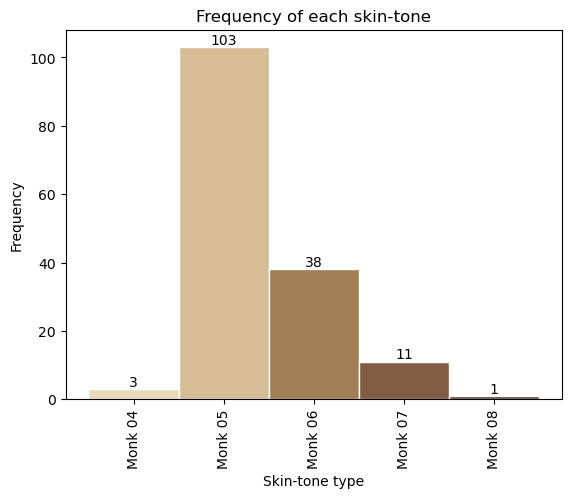

===============female_wrong===============


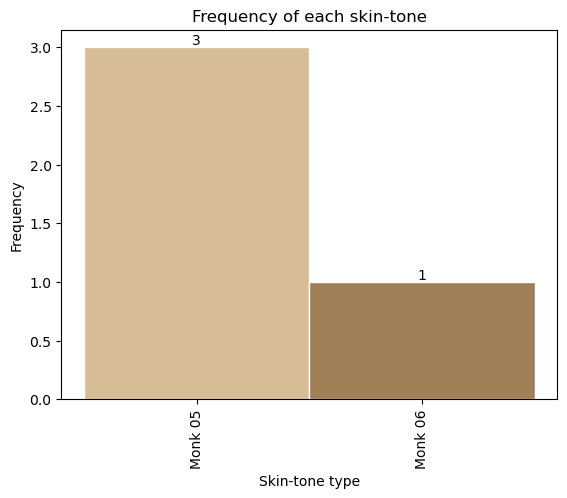

===============male_correct===============


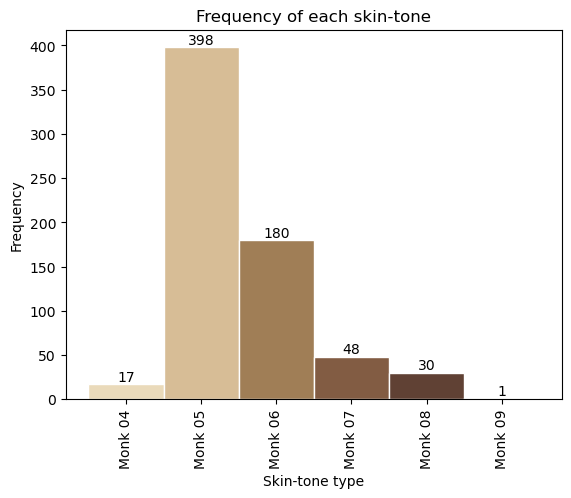

===============male_wrong===============


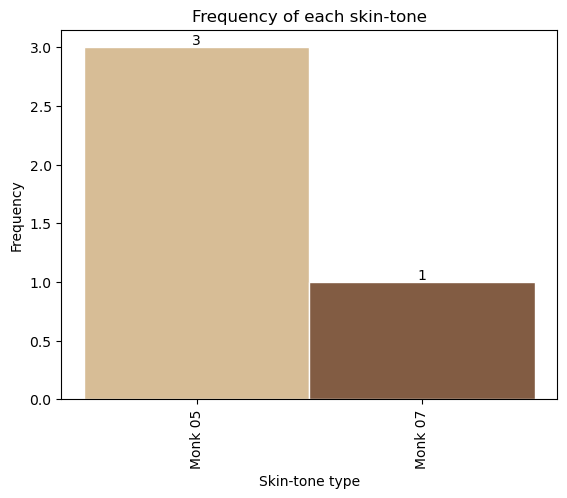

C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][correct_ind] = df[skin_tone][0] + df[skin_tone][2]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][wrong_ind] = df[skin_tone][1] + df[skin_tone][3]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3127628448.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

[674, '88.28', 4, '75.00', 156, '92.31', 4, '100.00', 830, '89.04', 8, '87.50']
                0 Monk 01  Monk 02 Monk 03  Monk 04 Monk 05  Monk 06 Monk 07  \
0    male_correct       0        0       0       17     398      180      48   
1      male_wrong       0        0       0        0       3        0       1   
2  female_correct       0        0       0        3     103       38      11   
3    female_wrong       0        0       0        0       3        1       0   
4         correct       0        0       0       20     501      218      59   
5           wrong       0        0       0        0       6        1       1   
6             674   88.28        4   75.00      156   92.31        4  100.00   

   Monk 08 Monk 09  Monk 10 less_than_M7  more_than_equal_M7  total  \
0       30       1        0          595                79.0  674.0   
1        0       0        0            3                 1.0    4.0   
2        1       0        0          144                12.0  156.

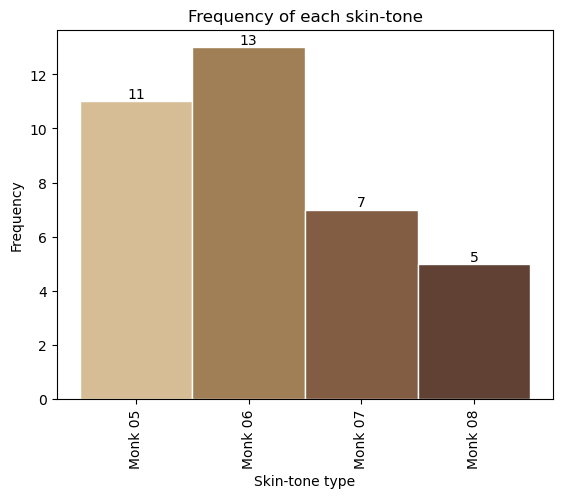

===============female_wrong===============


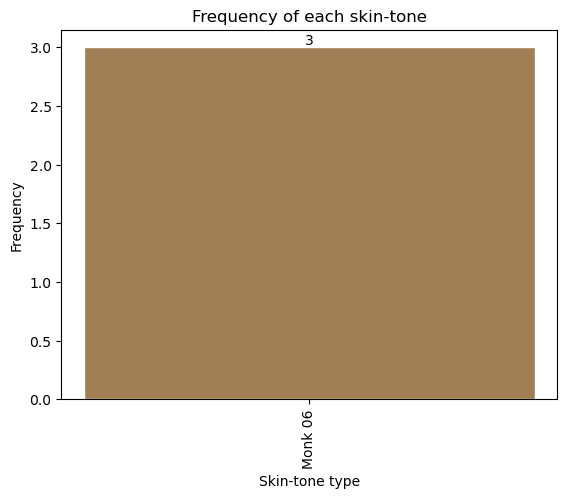

===============male_correct===============


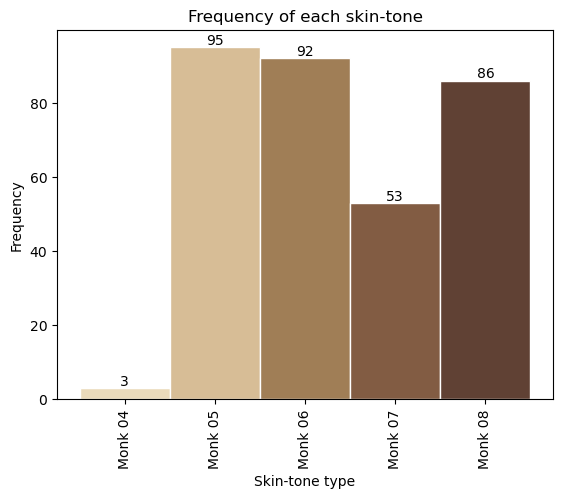

===============male_wrong===============


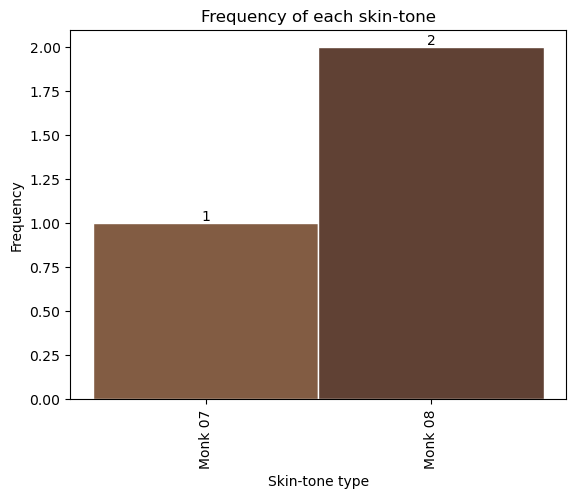

C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][correct_ind] = df[skin_tone][0] + df[skin_tone][2]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][wrong_ind] = df[skin_tone][1] + df[skin_tone][3]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3127628448.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

[329, '57.75', 3, '0.00', 36, '66.67', 3, '100.00', 365, '58.63', 6, '50.00']
                0 Monk 01  Monk 02 Monk 03  Monk 04 Monk 05  Monk 06 Monk 07  \
0    male_correct       0        0       0        3      95       92      53   
1      male_wrong       0        0       0        0       0        0       1   
2  female_correct       0        0       0        0      11       13       7   
3    female_wrong       0        0       0        0       0        3       0   
4         correct       0        0       0        3     106      105      60   
5           wrong       0        0       0        0       0        3       1   
6             329   57.75        3    0.00       36   66.67        3  100.00   

   Monk 08 Monk 09  Monk 10 less_than_M7  more_than_equal_M7  total  \
0       86       0        0          190               139.0  329.0   
1        2       0        0            0                 3.0    3.0   
2        5       0        0           24                12.0   36.0 

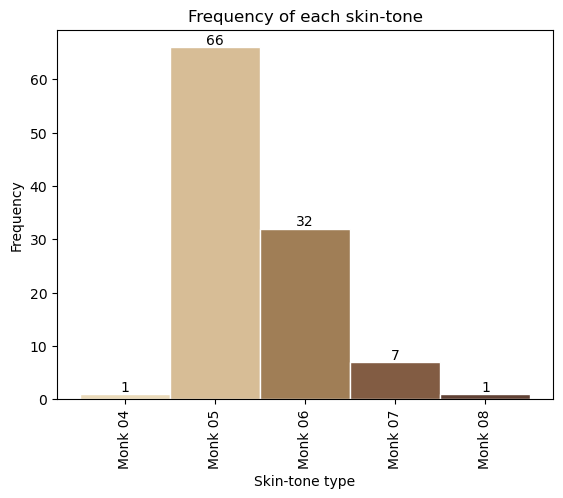

===============female_wrong===============


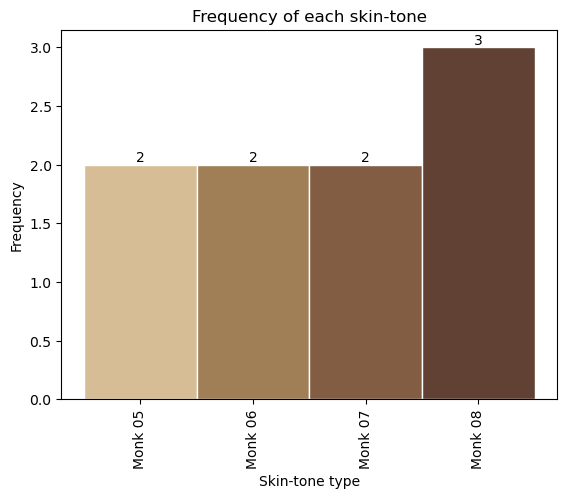

===============male_correct===============


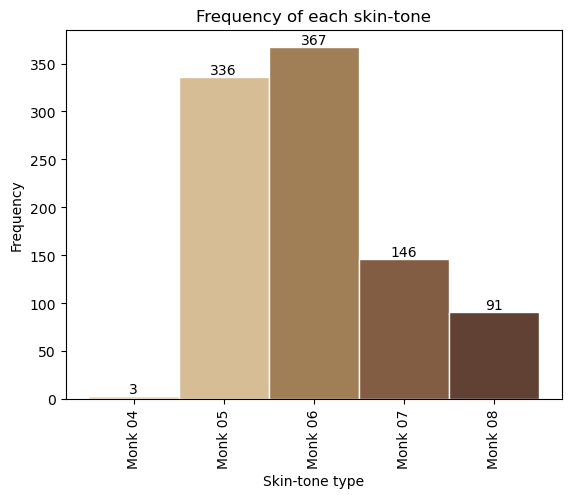

===============male_wrong===============


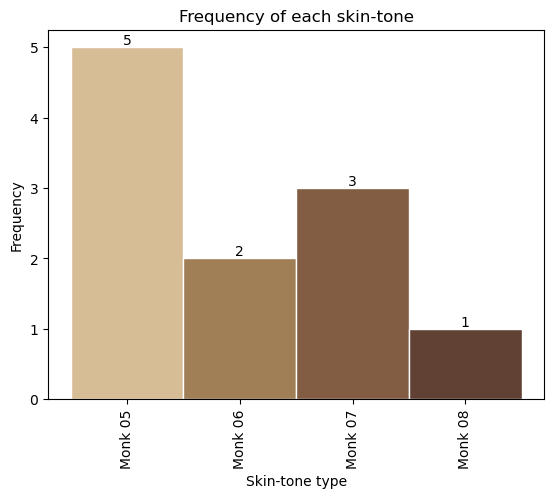

C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][correct_ind] = df[skin_tone][0] + df[skin_tone][2]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][wrong_ind] = df[skin_tone][1] + df[skin_tone][3]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3127628448.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

[943, '74.87', 11, '63.64', 107, '92.52', 9, '44.44', 1050, '76.67', 20, '55.00']
                0 Monk 01  Monk 02 Monk 03  Monk 04 Monk 05  Monk 06 Monk 07  \
0    male_correct       0        0       0        3     336      367     146   
1      male_wrong       0        0       0        0       5        2       3   
2  female_correct       0        0       0        1      66       32       7   
3    female_wrong       0        0       0        0       2        2       2   
4         correct       0        0       0        4     402      399     153   
5           wrong       0        0       0        0       7        4       5   
6             943   74.87       11   63.64      107   92.52        9   44.44   

   Monk 08 Monk 09  Monk 10 less_than_M7  more_than_equal_M7   total  \
0       91       0        0          706               237.0   943.0   
1        1       0        0            7                 4.0    11.0   
2        1       0        0           99                 8.0 

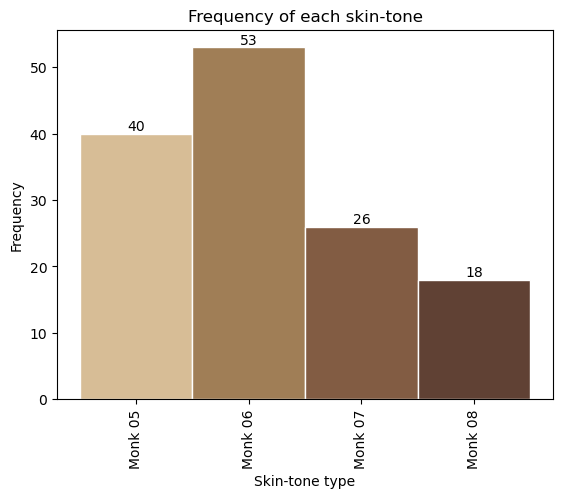

===============female_wrong===============


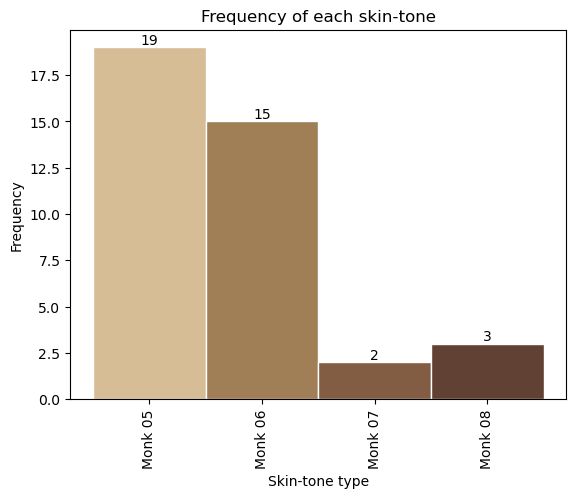

===============male_correct===============


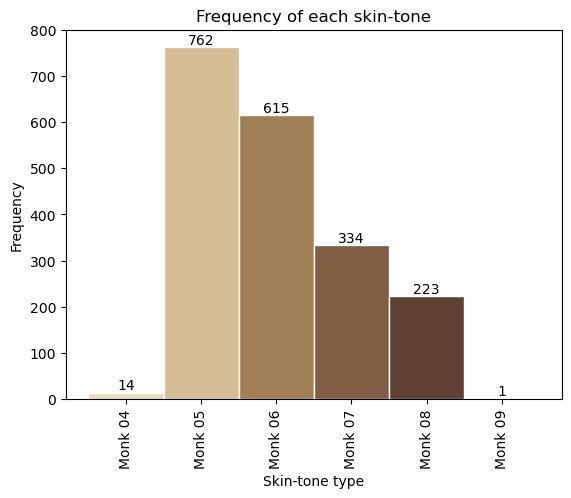

===============male_wrong===============


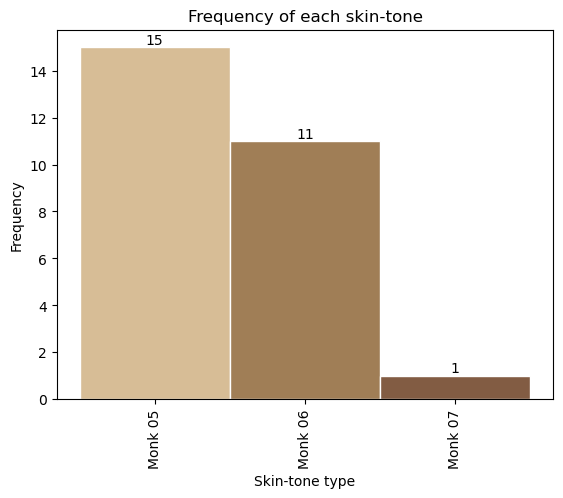

C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][correct_ind] = df[skin_tone][0] + df[skin_tone][2]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][wrong_ind] = df[skin_tone][1] + df[skin_tone][3]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3127628448.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

[1949, '71.37', 27, '96.30', 137, '67.88', 39, '87.18', 2086, '71.14', 66, '90.91']
                0 Monk 01  Monk 02 Monk 03  Monk 04 Monk 05  Monk 06 Monk 07  \
0    male_correct       0        0       0       14     762      615     334   
1      male_wrong       0        0       0        0      15       11       1   
2  female_correct       0        0       0        0      40       53      26   
3    female_wrong       0        0       0        0      19       15       2   
4         correct       0        0       0       14     802      668     360   
5           wrong       0        0       0        0      34       26       3   
6            1949   71.37       27   96.30      137   67.88       39   87.18   

   Monk 08 Monk 09  Monk 10 less_than_M7  more_than_equal_M7   total  \
0      223       1        0         1391               558.0  1949.0   
1        0       0        0           26                 1.0    27.0   
2       18       0        0           93                44.

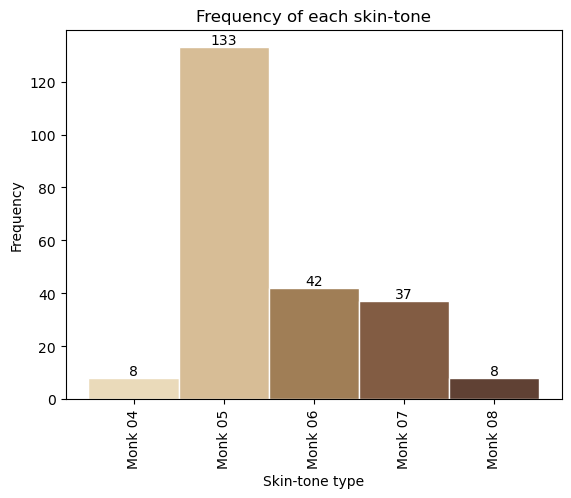

===============female_wrong===============


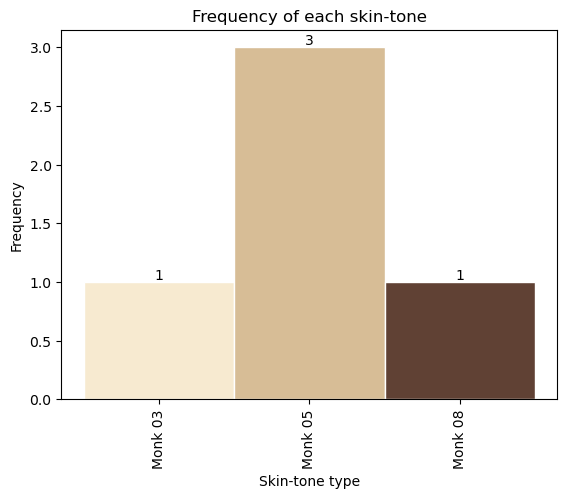

===============male_correct===============


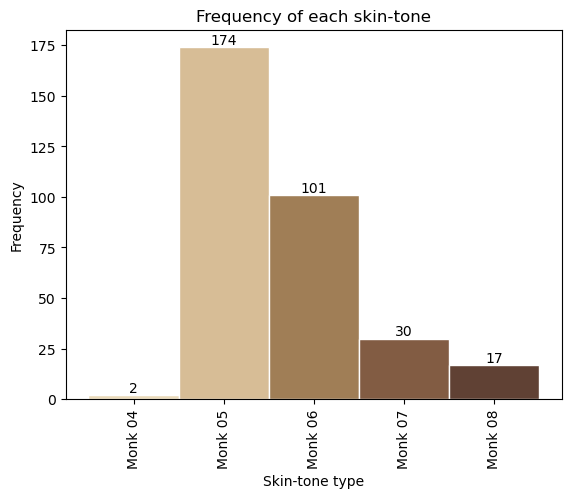

===============male_wrong===============


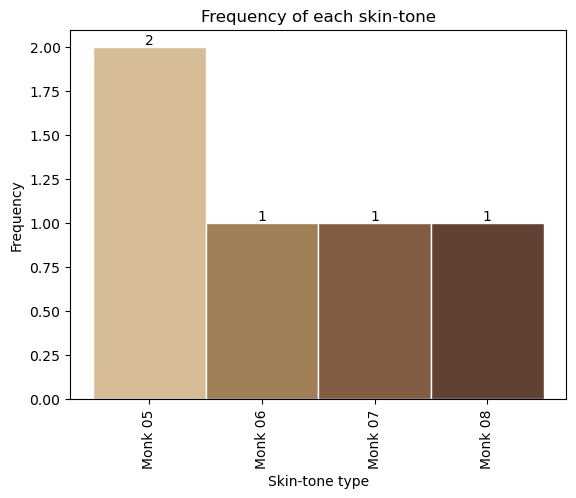

C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][correct_ind] = df[skin_tone][0] + df[skin_tone][2]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][wrong_ind] = df[skin_tone][1] + df[skin_tone][3]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3127628448.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

[324, '85.49', 5, '60.00', 228, '80.26', 5, '80.00', 552, '83.33', 10, '70.00']
                0 Monk 01  Monk 02 Monk 03  Monk 04 Monk 05  Monk 06 Monk 07  \
0    male_correct       0        0       0        2     174      101      30   
1      male_wrong       0        0       0        0       2        1       1   
2  female_correct       0        0       0        8     133       42      37   
3    female_wrong       0        0       1        0       3        0       0   
4         correct       0        0       0       10     307      143      67   
5           wrong       0        0       1        0       5        1       1   
6             324   85.49        5   60.00      228   80.26        5   80.00   

   Monk 08 Monk 09  Monk 10 less_than_M7  more_than_equal_M7  total  \
0       17       0        0          277                47.0  324.0   
1        1       0        0            3                 2.0    5.0   
2        8       0        0          183                45.0  228.

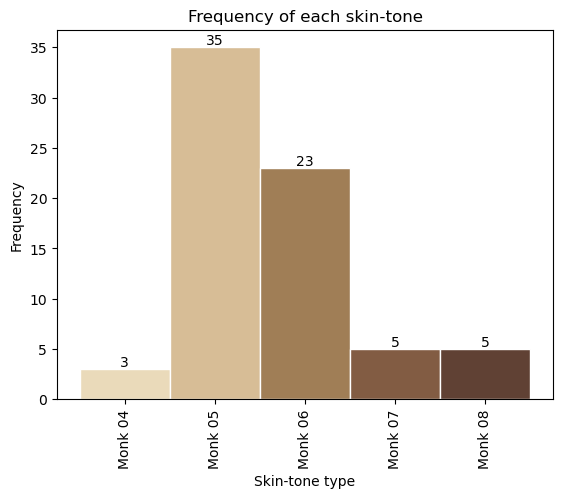

===============female_wrong===============


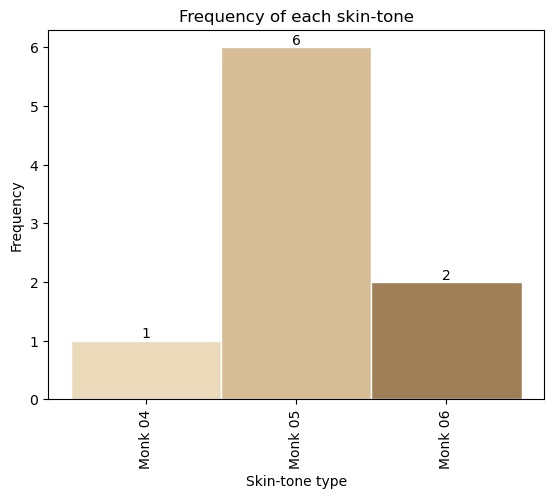

===============male_correct===============


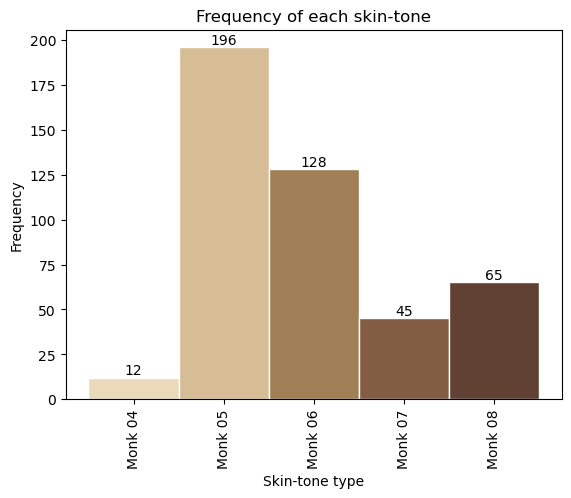

===============male_wrong===============


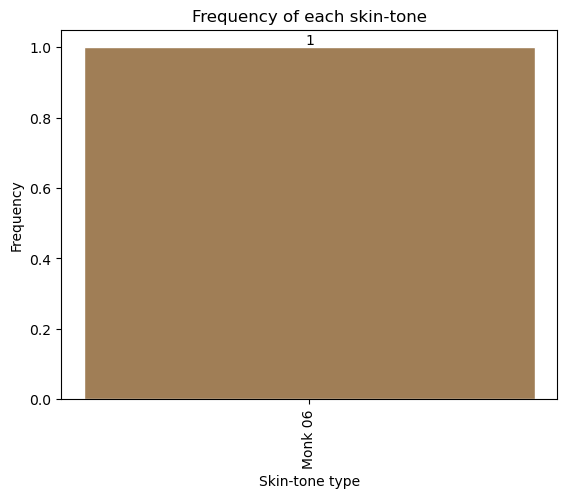

C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][correct_ind] = df[skin_tone][0] + df[skin_tone][2]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][wrong_ind] = df[skin_tone][1] + df[skin_tone][3]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3127628448.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

[446, '75.34', 1, '100.00', 71, '85.92', 9, '100.00', 517, '76.79', 10, '100.00']
                0 Monk 01  Monk 02 Monk 03  Monk 04 Monk 05  Monk 06 Monk 07  \
0    male_correct       0        0       0       12     196      128      45   
1      male_wrong       0        0       0        0       0        1       0   
2  female_correct       0        0       0        3      35       23       5   
3    female_wrong       0        0       0        1       6        2       0   
4         correct       0        0       0       15     231      151      50   
5           wrong       0        0       0        1       6        3       0   
6             446   75.34        1  100.00       71   85.92        9  100.00   

   Monk 08 Monk 09  Monk 10 less_than_M7  more_than_equal_M7  total  \
0       65       0        0          336               110.0  446.0   
1        0       0        0            1                 0.0    1.0   
2        5       0        0           61                10.0   7

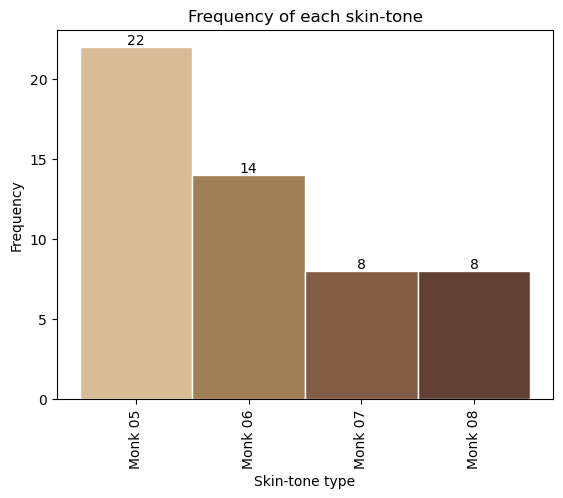

===============female_wrong===============


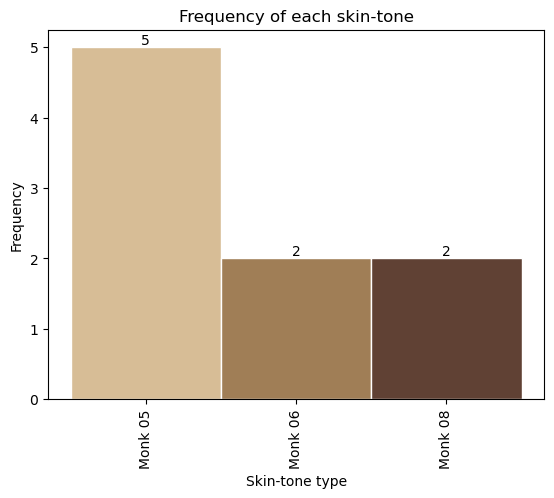

===============male_correct===============


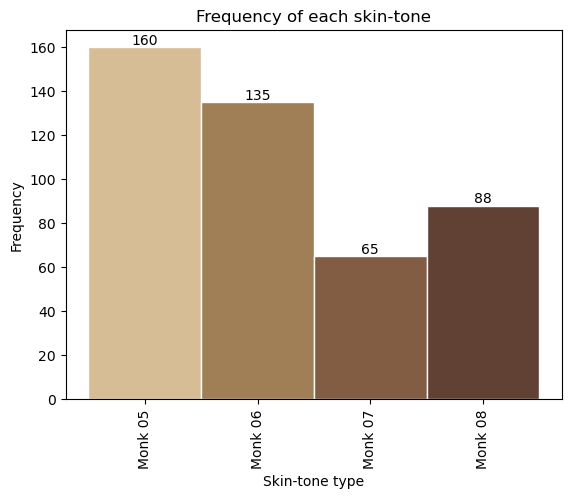

===============male_wrong===============


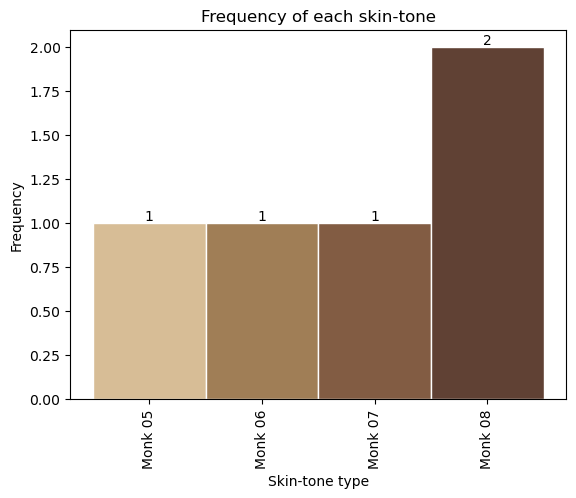

C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][correct_ind] = df[skin_tone][0] + df[skin_tone][2]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][wrong_ind] = df[skin_tone][1] + df[skin_tone][3]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3127628448.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

[448, '65.85', 5, '40.00', 52, '69.23', 9, '77.78', 500, '66.20', 14, '64.29']
                0 Monk 01  Monk 02 Monk 03  Monk 04 Monk 05  Monk 06 Monk 07  \
0    male_correct       0        0       0        0     160      135      65   
1      male_wrong       0        0       0        0       1        1       1   
2  female_correct       0        0       0        0      22       14       8   
3    female_wrong       0        0       0        0       5        2       0   
4         correct       0        0       0        0     182      149      73   
5           wrong       0        0       0        0       6        3       1   
6             448   65.85        5   40.00       52   69.23        9   77.78   

   Monk 08 Monk 09  Monk 10 less_than_M7  more_than_equal_M7  total  \
0       88       0        0          295               153.0  448.0   
1        2       0        0            2                 3.0    5.0   
2        8       0        0           36                16.0   52.0

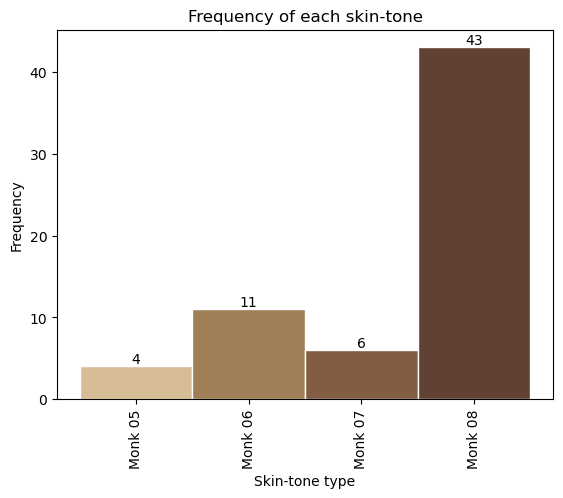

===============female_wrong===============


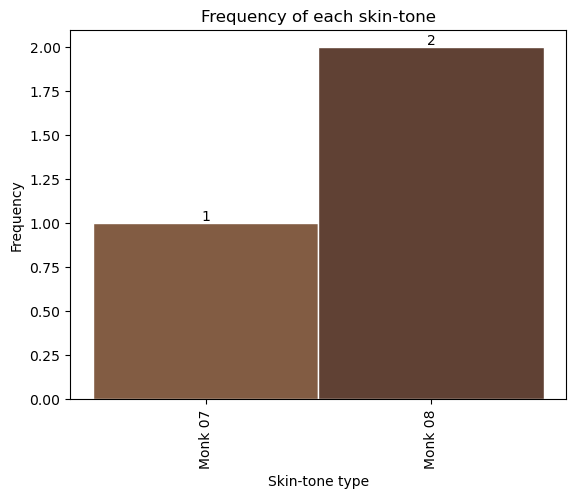

===============male_correct===============


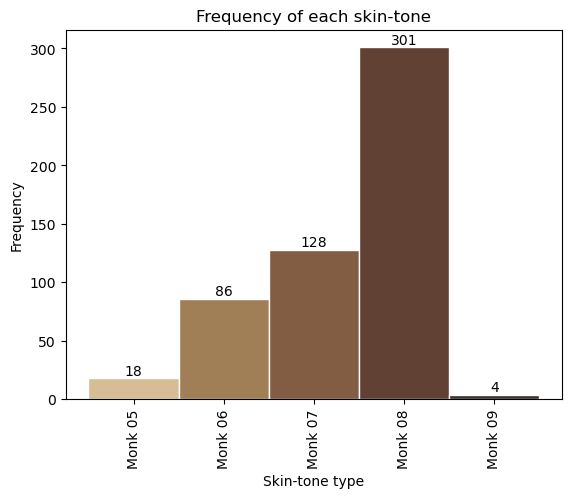

===============male_wrong===============


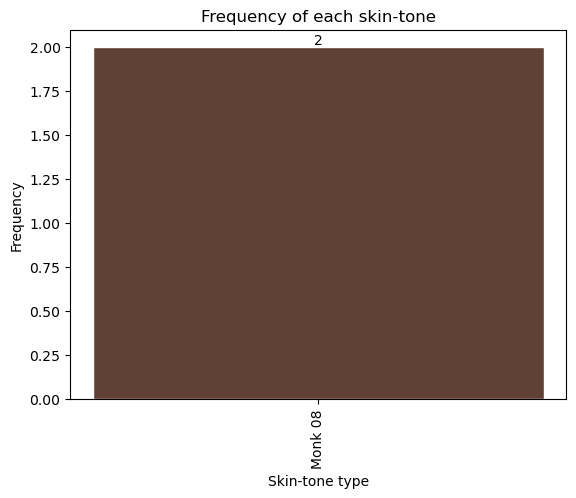

C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][correct_ind] = df[skin_tone][0] + df[skin_tone][2]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][wrong_ind] = df[skin_tone][1] + df[skin_tone][3]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3127628448.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

[537, '19.37', 2, '0.00', 64, '23.44', 3, '0.00', 601, '19.80', 5, '0.00']
                0 Monk 01  Monk 02 Monk 03  Monk 04 Monk 05  Monk 06 Monk 07  \
0    male_correct       0        0       0        0      18       86     128   
1      male_wrong       0        0       0        0       0        0       0   
2  female_correct       0        0       0        0       4       11       6   
3    female_wrong       0        0       0        0       0        0       1   
4         correct       0        0       0        0      22       97     134   
5           wrong       0        0       0        0       0        0       1   
6             537   19.37        2    0.00       64   23.44        3    0.00   

   Monk 08 Monk 09  Monk 10 less_than_M7  more_than_equal_M7  total  \
0      301       4        0          104               433.0  537.0   
1        2       0        0            0                 2.0    2.0   
2       43       0        0           15                49.0   64.0   


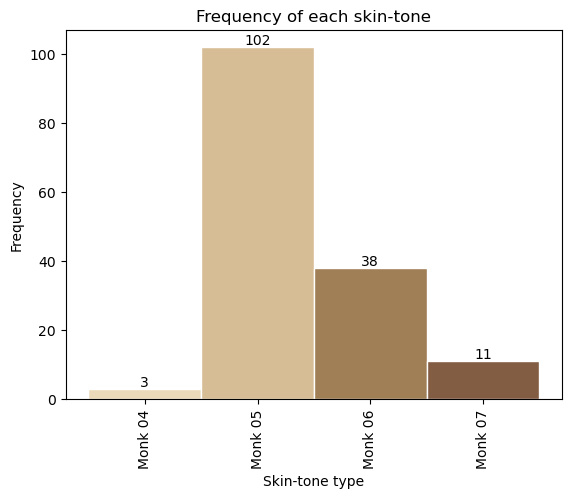

===============female_wrong===============


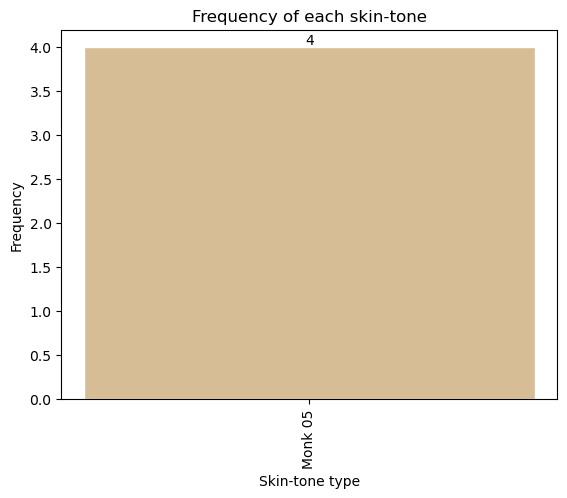

===============male_correct===============


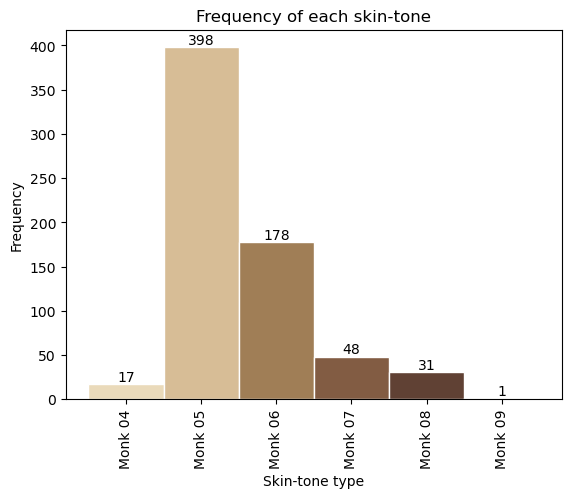

===============male_wrong===============


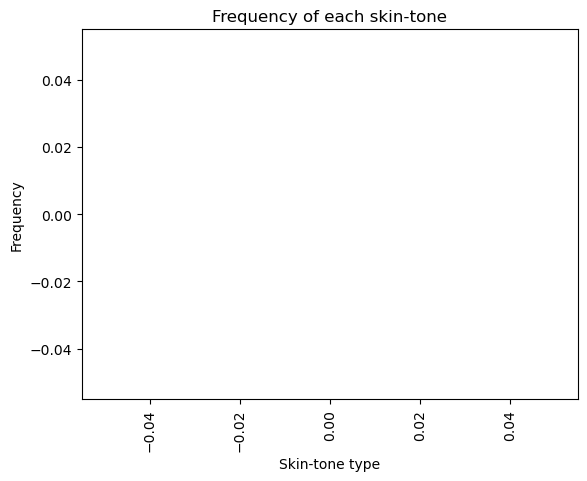

C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][correct_ind] = df[skin_tone][0] + df[skin_tone][2]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][wrong_ind] = df[skin_tone][1] + df[skin_tone][3]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:20: RuntimeWarning: invalid value encountered in scalar divide
  df.at[i,'percentage_less_than_equal_Monk-06'] = (df['less_than_M7'][i]/df['total'][i])*100
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\31276

[673, '88.11', 0, 'nan', 154, '92.86', 4, '100.00', 827, '89.00', 4, '100.00']
                0 Monk 01  Monk 02 Monk 03  Monk 04 Monk 05  Monk 06 Monk 07  \
0    male_correct       0        0       0       17     398      178      48   
1      male_wrong       0        0       0        0       0        0       0   
2  female_correct       0        0       0        3     102       38      11   
3    female_wrong       0        0       0        0       4        0       0   
4         correct       0        0       0       20     500      216      59   
5           wrong       0        0       0        0       4        0       0   
6             673   88.11        0     nan      154   92.86        4  100.00   

   Monk 08 Monk 09  Monk 10 less_than_M7  more_than_equal_M7  total  \
0       31       1        0          593                80.0  673.0   
1        0       0        0            0                 0.0    0.0   
2        0       0        0          143                11.0  154.0

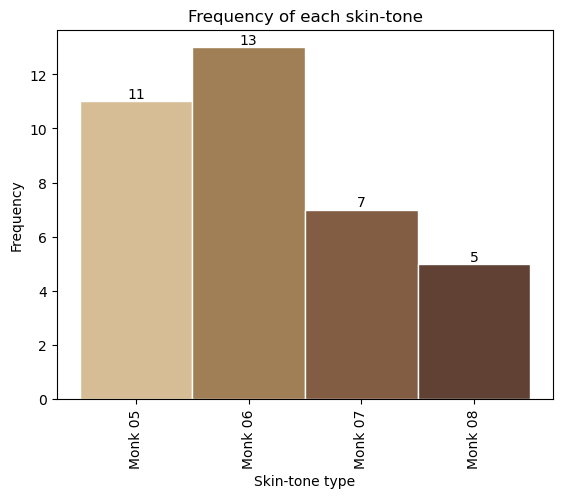

===============female_wrong===============


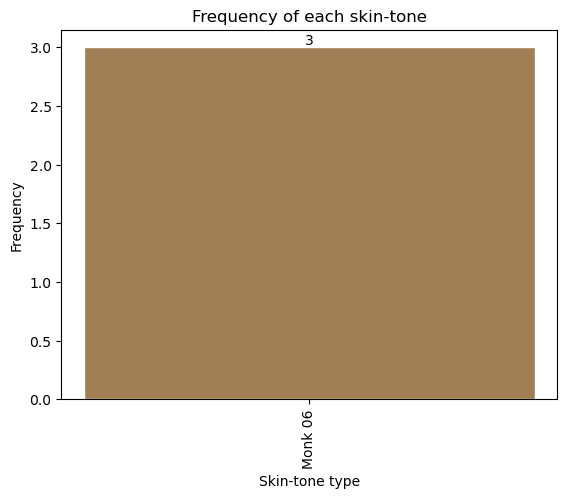

===============male_correct===============


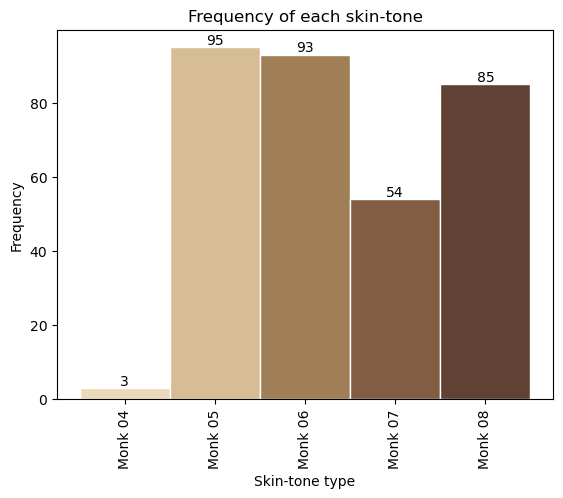

===============male_wrong===============


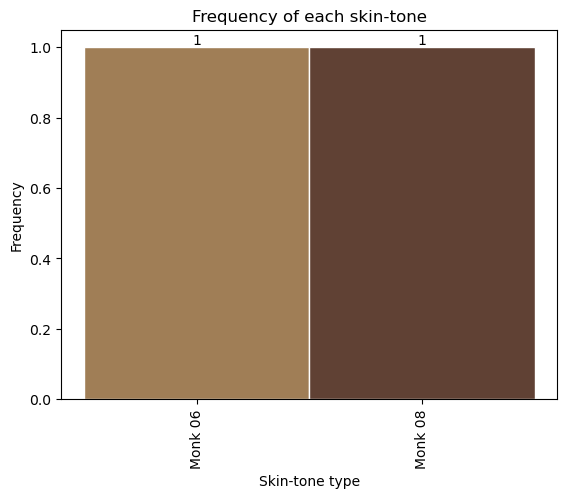

C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][correct_ind] = df[skin_tone][0] + df[skin_tone][2]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][wrong_ind] = df[skin_tone][1] + df[skin_tone][3]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3127628448.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

[330, '57.88', 2, '50.00', 36, '66.67', 3, '100.00', 366, '58.74', 5, '80.00']
                0 Monk 01  Monk 02 Monk 03  Monk 04 Monk 05  Monk 06 Monk 07  \
0    male_correct       0        0       0        3      95       93      54   
1      male_wrong       0        0       0        0       0        1       0   
2  female_correct       0        0       0        0      11       13       7   
3    female_wrong       0        0       0        0       0        3       0   
4         correct       0        0       0        3     106      106      61   
5           wrong       0        0       0        0       0        4       0   
6             330   57.88        2   50.00       36   66.67        3  100.00   

   Monk 08 Monk 09  Monk 10 less_than_M7  more_than_equal_M7  total  \
0       85       0        0          191               139.0  330.0   
1        1       0        0            1                 1.0    2.0   
2        5       0        0           24                12.0   36.0

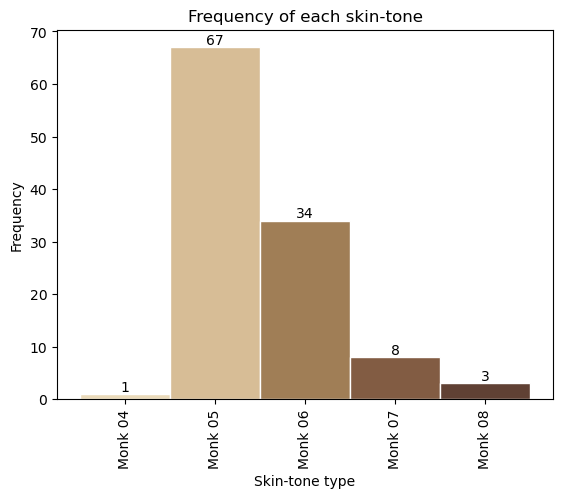

===============female_wrong===============


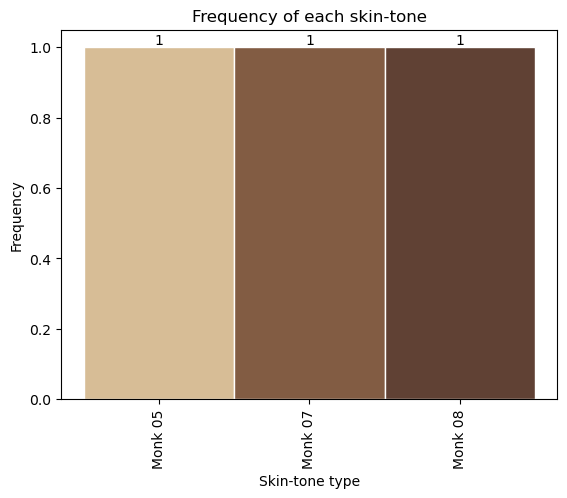

===============male_correct===============


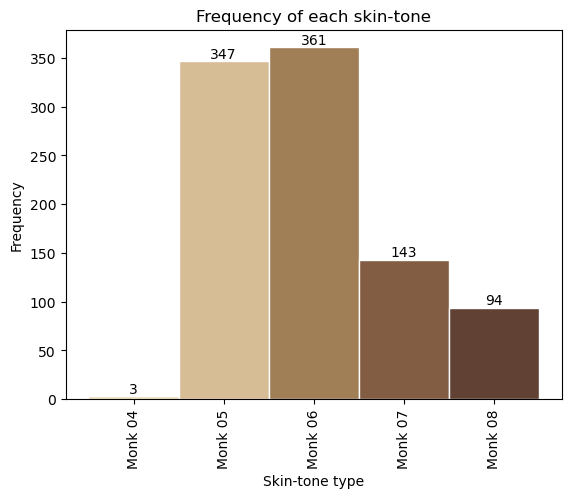

===============male_wrong===============


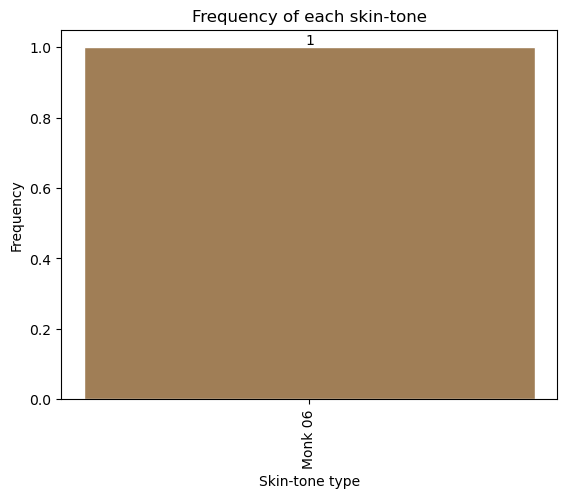

C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][correct_ind] = df[skin_tone][0] + df[skin_tone][2]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][wrong_ind] = df[skin_tone][1] + df[skin_tone][3]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3127628448.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

[948, '75.00', 1, '100.00', 113, '90.27', 3, '33.33', 1061, '76.63', 4, '50.00']
                0 Monk 01  Monk 02 Monk 03  Monk 04 Monk 05  Monk 06 Monk 07  \
0    male_correct       0        0       0        3     347      361     143   
1      male_wrong       0        0       0        0       0        1       0   
2  female_correct       0        0       0        1      67       34       8   
3    female_wrong       0        0       0        0       1        0       1   
4         correct       0        0       0        4     414      395     151   
5           wrong       0        0       0        0       1        1       1   
6             948   75.00        1  100.00      113   90.27        3   33.33   

   Monk 08 Monk 09  Monk 10 less_than_M7  more_than_equal_M7   total  \
0       94       0        0          711               237.0   948.0   
1        0       0        0            1                 0.0     1.0   
2        3       0        0          102                11.0  

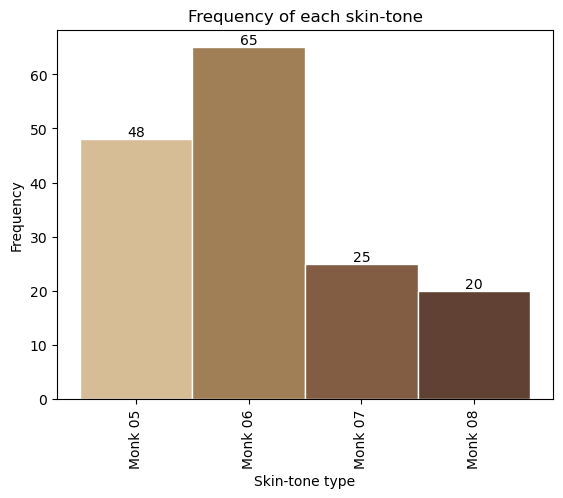

===============female_wrong===============


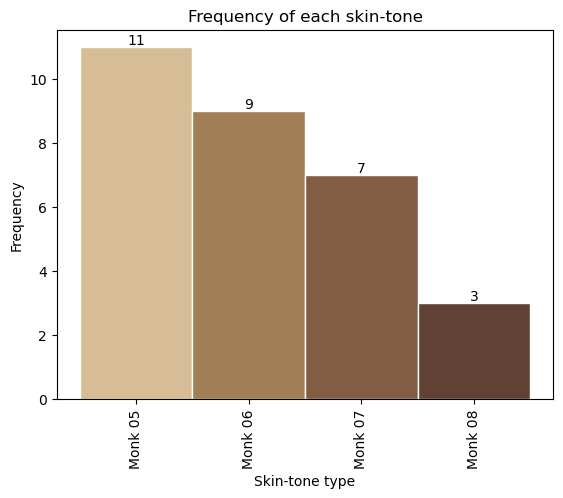

===============male_correct===============


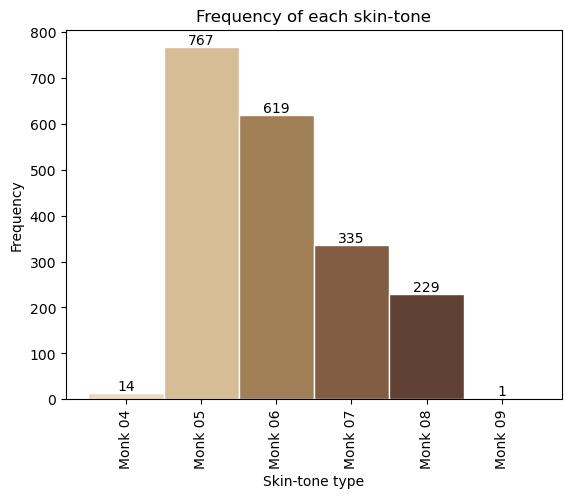

===============male_wrong===============


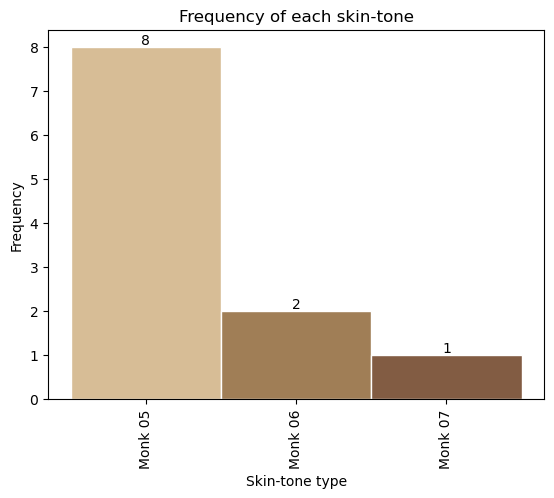

C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][correct_ind] = df[skin_tone][0] + df[skin_tone][2]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][wrong_ind] = df[skin_tone][1] + df[skin_tone][3]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3127628448.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

[1965, '71.25', 11, '90.91', 158, '71.52', 30, '66.67', 2123, '71.27', 41, '73.17']
                0 Monk 01  Monk 02 Monk 03  Monk 04 Monk 05  Monk 06 Monk 07  \
0    male_correct       0        0       0       14     767      619     335   
1      male_wrong       0        0       0        0       8        2       1   
2  female_correct       0        0       0        0      48       65      25   
3    female_wrong       0        0       0        0      11        9       7   
4         correct       0        0       0       14     815      684     360   
5           wrong       0        0       0        0      19       11       8   
6            1965   71.25       11   90.91      158   71.52       30   66.67   

   Monk 08 Monk 09  Monk 10 less_than_M7  more_than_equal_M7   total  \
0      229       1        0         1400               565.0  1965.0   
1        0       0        0           10                 1.0    11.0   
2       20       0        0          113                45.

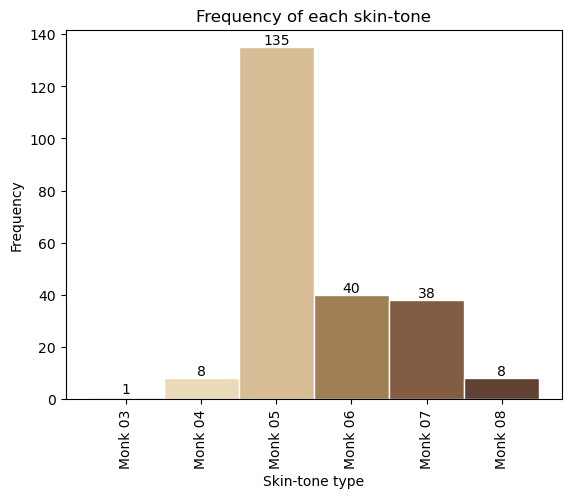

===============female_wrong===============


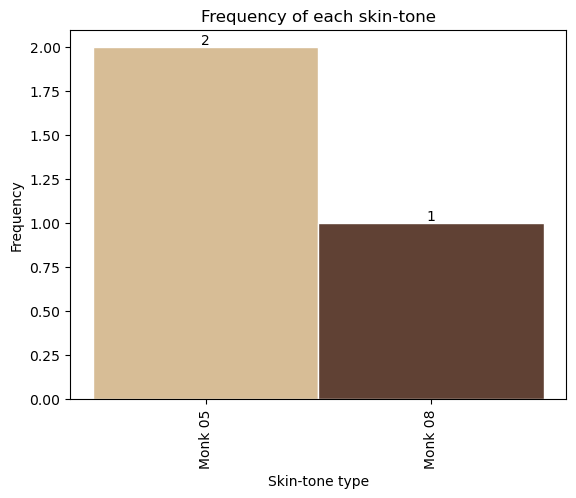

===============male_correct===============


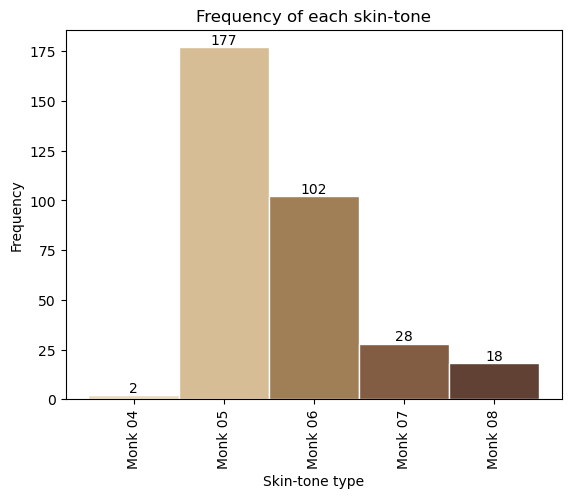

===============male_wrong===============


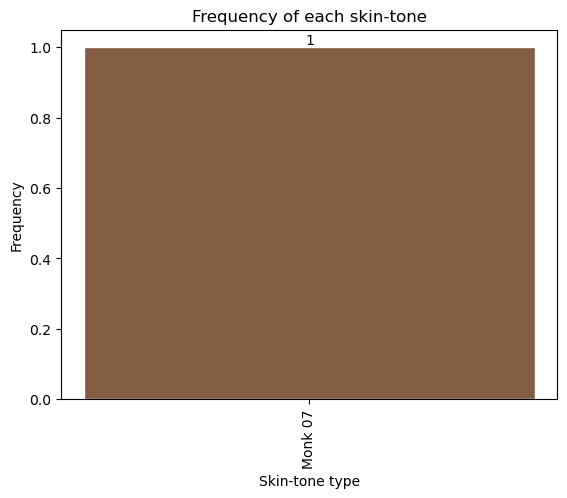

C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][correct_ind] = df[skin_tone][0] + df[skin_tone][2]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][wrong_ind] = df[skin_tone][1] + df[skin_tone][3]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3127628448.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

[327, '85.93', 1, '0.00', 230, '80.00', 3, '66.67', 557, '83.48', 4, '50.00']
                0 Monk 01  Monk 02 Monk 03  Monk 04 Monk 05  Monk 06 Monk 07  \
0    male_correct       0        0       0        2     177      102      28   
1      male_wrong       0        0       0        0       0        0       1   
2  female_correct       0        0       1        8     135       40      38   
3    female_wrong       0        0       0        0       2        0       0   
4         correct       0        0       1       10     312      142      66   
5           wrong       0        0       0        0       2        0       1   
6             327   85.93        1    0.00      230   80.00        3   66.67   

   Monk 08 Monk 09  Monk 10 less_than_M7  more_than_equal_M7  total  \
0       18       0        0          281                46.0  327.0   
1        0       0        0            0                 1.0    1.0   
2        8       0        0          184                46.0  230.0 

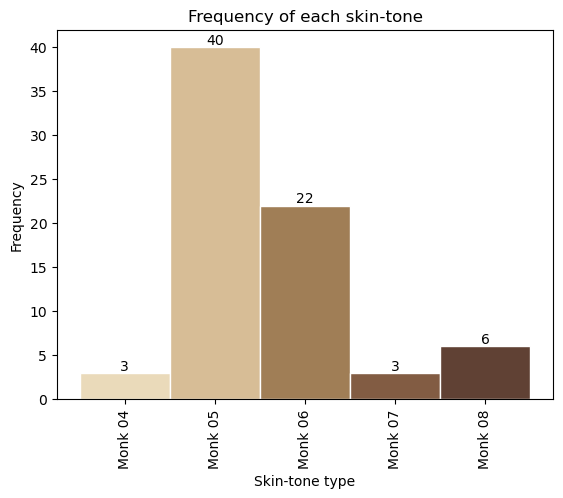

===============female_wrong===============


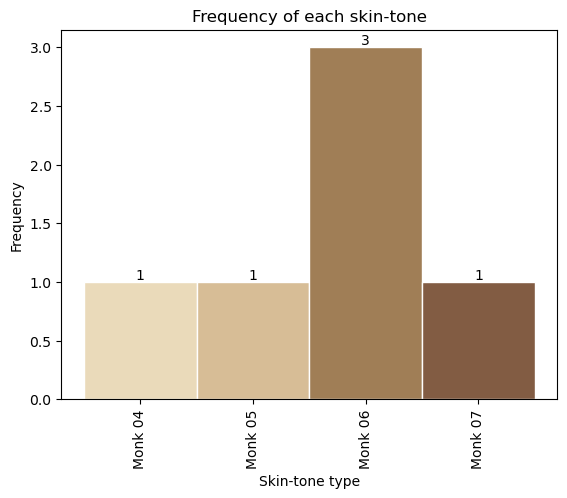

===============male_correct===============


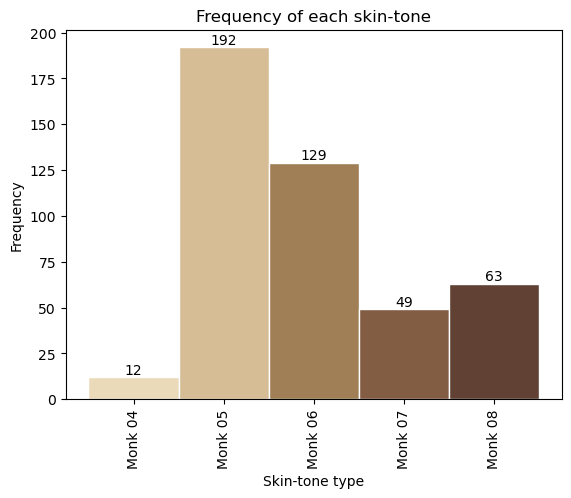

===============male_wrong===============
<class 'FileNotFoundError'>
(2, 'No such file or directory')
[Errno 2] No such file or directory: './../Skintone/skintone_result/azure/Pakistan/male_wrong/result.csv'
[445, '74.83', 0, 'nan', 74, '87.84', 6, '83.33', 519, '76.69', 6, '83.33']
                0 Monk 01  Monk 02 Monk 03  Monk 04 Monk 05  Monk 06 Monk 07  \
0    male_correct       0        0       0       12     192      129      49   
1      male_wrong       0        0       0        0       0        0       0   
2  female_correct       0        0       0        3      40       22       3   
3    female_wrong       0        0       0        1       1        3       1   
4         correct       0        0       0       15     232      151      52   
5           wrong       0        0       0        1       1        3       1   
6             445   74.83        0     nan       74   87.84        6   83.33   

   Monk 08 Monk 09  Monk 10 less_than_M7  more_than_equal_M7  total  \
0   

C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][correct_ind] = df[skin_tone][0] + df[skin_tone][2]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][wrong_ind] = df[skin_tone][1] + df[skin_tone][3]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:20: RuntimeWarning: invalid value encountered in scalar divide
  df.at[i,'percentage_less_than_equal_Monk-06'] = (df['less_than_M7'][i]/df['total'][i])*100
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\31276

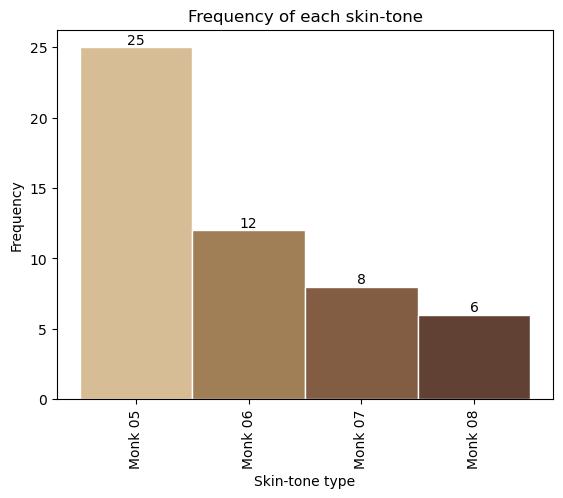

===============female_wrong===============


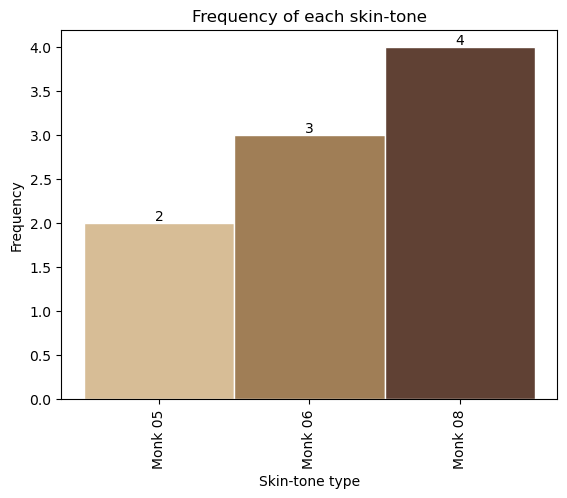

===============male_correct===============


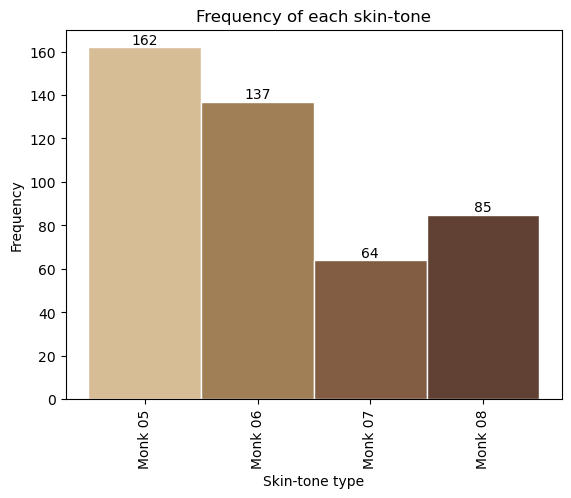

===============male_wrong===============
<class 'FileNotFoundError'>
(2, 'No such file or directory')
[Errno 2] No such file or directory: './../Skintone/skintone_result/azure/South Africa/male_wrong/result.csv'
[448, '66.74', 0, 'nan', 51, '72.55', 9, '55.56', 499, '67.33', 9, '55.56']
                0 Monk 01  Monk 02 Monk 03  Monk 04 Monk 05  Monk 06 Monk 07  \
0    male_correct       0        0       0        0     162      137      64   
1      male_wrong       0        0       0        0       0        0       0   
2  female_correct       0        0       0        0      25       12       8   
3    female_wrong       0        0       0        0       2        3       0   
4         correct       0        0       0        0     187      149      72   
5           wrong       0        0       0        0       2        3       0   
6             448   66.74        0     nan       51   72.55        9   55.56   

   Monk 08 Monk 09  Monk 10 less_than_M7  more_than_equal_M7  total  \


C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][correct_ind] = df[skin_tone][0] + df[skin_tone][2]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][wrong_ind] = df[skin_tone][1] + df[skin_tone][3]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:20: RuntimeWarning: invalid value encountered in scalar divide
  df.at[i,'percentage_less_than_equal_Monk-06'] = (df['less_than_M7'][i]/df['total'][i])*100
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\31276

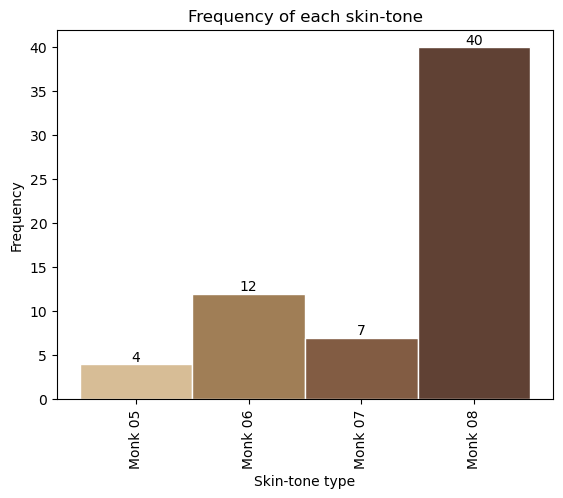

===============female_wrong===============


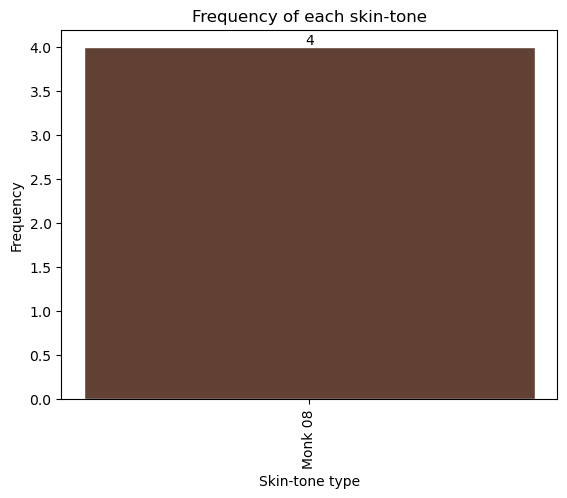

===============male_correct===============


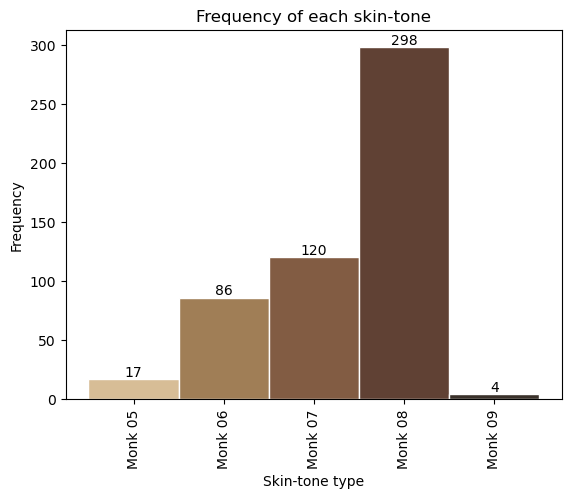

===============male_wrong===============
<class 'FileNotFoundError'>
(2, 'No such file or directory')
[Errno 2] No such file or directory: './../Skintone/skintone_result/azure/West Indies/male_wrong/result.csv'
[525, '19.62', 0, 'nan', 63, '25.40', 4, '0.00', 588, '20.24', 4, '0.00']
                0 Monk 01  Monk 02 Monk 03  Monk 04 Monk 05  Monk 06 Monk 07  \
0    male_correct       0        0       0        0      17       86     120   
1      male_wrong       0        0       0        0       0        0       0   
2  female_correct       0        0       0        0       4       12       7   
3    female_wrong       0        0       0        0       0        0       0   
4         correct       0        0       0        0      21       98     127   
5           wrong       0        0       0        0       0        0       0   
6             525   19.62        0     nan       63   25.40        4    0.00   

   Monk 08 Monk 09  Monk 10 less_than_M7  more_than_equal_M7  total  \
0  

C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][correct_ind] = df[skin_tone][0] + df[skin_tone][2]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][wrong_ind] = df[skin_tone][1] + df[skin_tone][3]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:20: RuntimeWarning: invalid value encountered in scalar divide
  df.at[i,'percentage_less_than_equal_Monk-06'] = (df['less_than_M7'][i]/df['total'][i])*100
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\31276

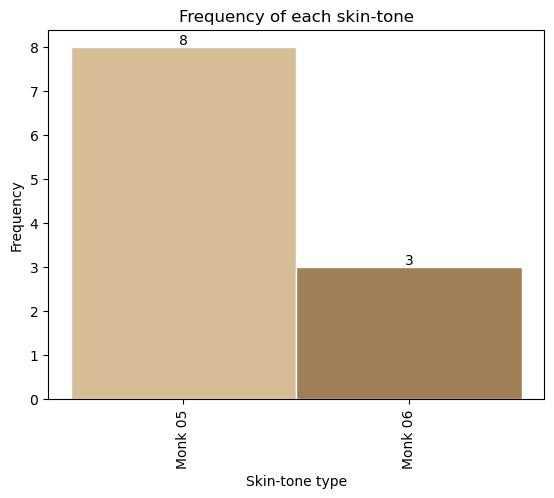

===============female_wrong===============


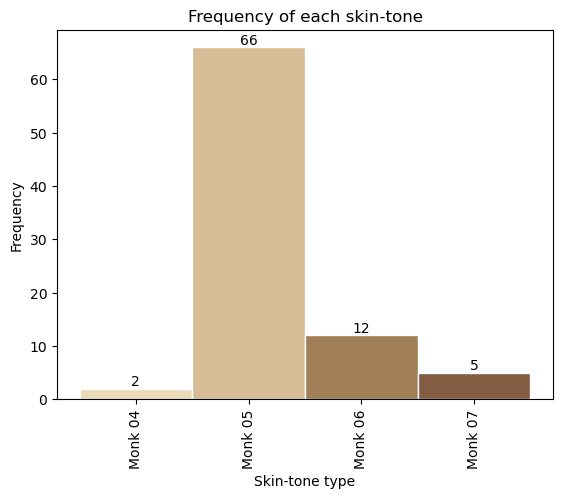

===============male_correct===============


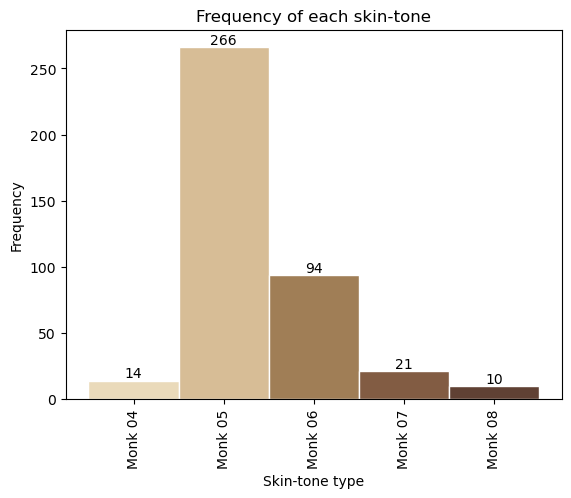

===============male_wrong===============
<class 'FileNotFoundError'>
(2, 'No such file or directory')
[Errno 2] No such file or directory: './../Skintone/skintone_result/deepface/Australia/male_wrong/result.csv'
[405, '92.35', 0, 'nan', 11, '100.00', 85, '94.12', 416, '92.55', 85, '94.12']
                0 Monk 01  Monk 02 Monk 03  Monk 04 Monk 05  Monk 06 Monk 07  \
0    male_correct       0        0       0       14     266       94      21   
1      male_wrong       0        0       0        0       0        0       0   
2  female_correct       0        0       0        0       8        3       0   
3    female_wrong       0        0       0        2      66       12       5   
4         correct       0        0       0       14     274       97      21   
5           wrong       0        0       0        2      66       12       5   
6             405   92.35        0     nan       11  100.00       85   94.12   

   Monk 08 Monk 09  Monk 10 less_than_M7  more_than_equal_M7  total 

C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][correct_ind] = df[skin_tone][0] + df[skin_tone][2]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][wrong_ind] = df[skin_tone][1] + df[skin_tone][3]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:20: RuntimeWarning: invalid value encountered in scalar divide
  df.at[i,'percentage_less_than_equal_Monk-06'] = (df['less_than_M7'][i]/df['total'][i])*100
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\31276

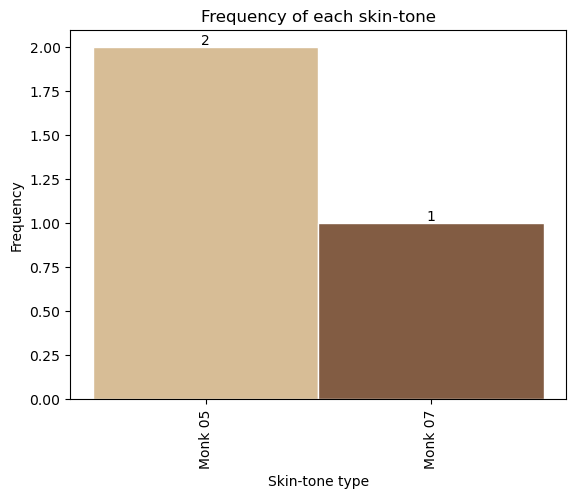

===============female_wrong===============


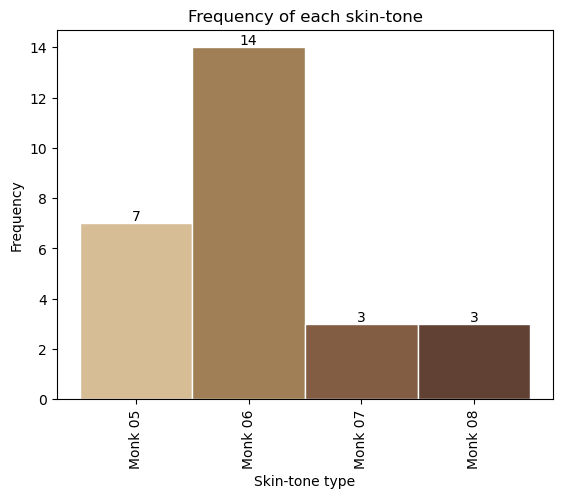

===============male_correct===============


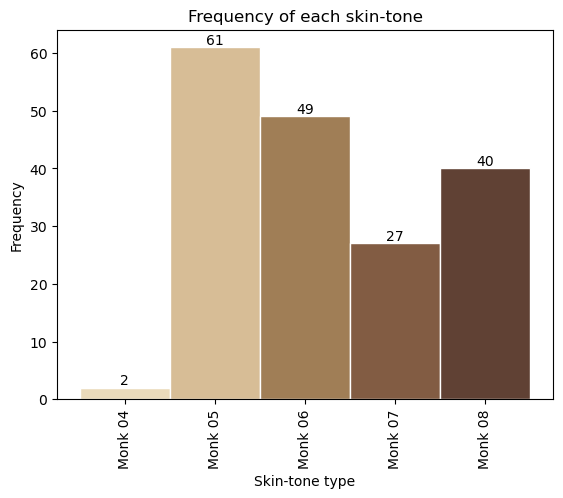

===============male_wrong===============


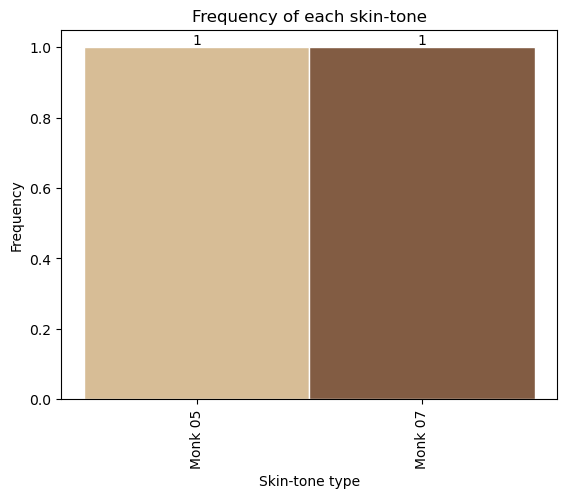

C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][correct_ind] = df[skin_tone][0] + df[skin_tone][2]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][wrong_ind] = df[skin_tone][1] + df[skin_tone][3]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3127628448.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

[179, '62.57', 2, '50.00', 3, '66.67', 27, '77.78', 182, '62.64', 29, '75.86']
                0 Monk 01  Monk 02 Monk 03  Monk 04 Monk 05  Monk 06 Monk 07  \
0    male_correct       0        0       0        2      61       49      27   
1      male_wrong       0        0       0        0       1        0       1   
2  female_correct       0        0       0        0       2        0       1   
3    female_wrong       0        0       0        0       7       14       3   
4         correct       0        0       0        2      63       49      28   
5           wrong       0        0       0        0       8       14       4   
6             179   62.57        2   50.00        3   66.67       27   77.78   

   Monk 08 Monk 09  Monk 10 less_than_M7  more_than_equal_M7  total  \
0       40       0        0          112                67.0  179.0   
1        0       0        0            1                 1.0    2.0   
2        0       0        0            2                 1.0    3.0

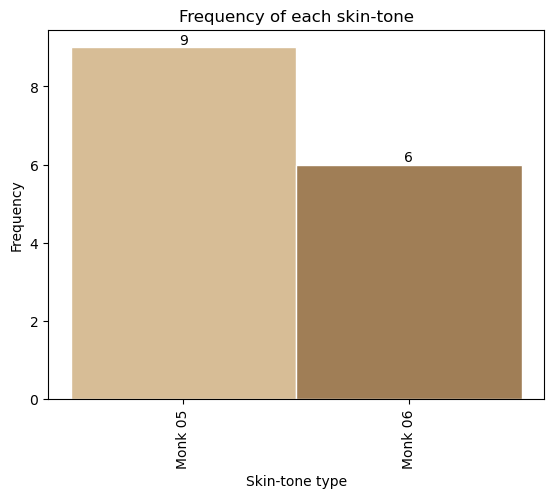

===============female_wrong===============


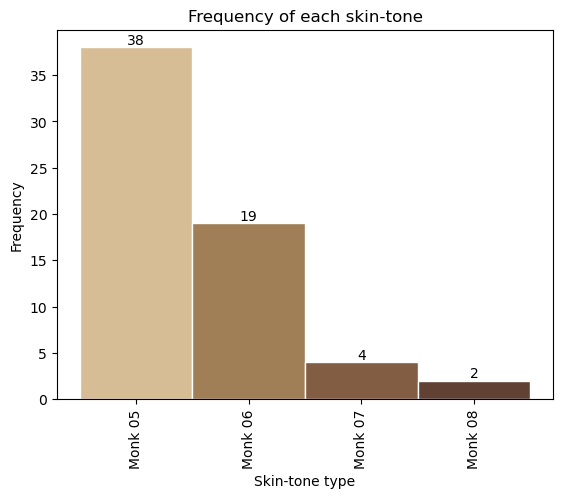

===============male_correct===============


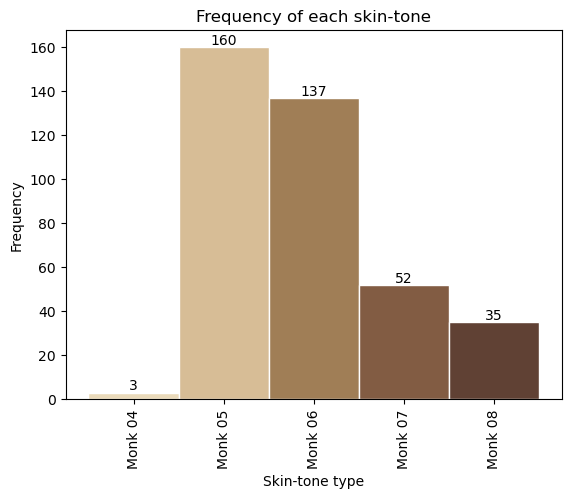

===============male_wrong===============


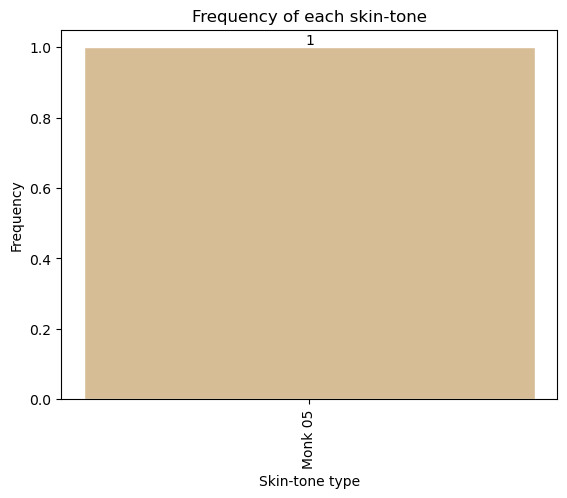

C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][correct_ind] = df[skin_tone][0] + df[skin_tone][2]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][wrong_ind] = df[skin_tone][1] + df[skin_tone][3]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3127628448.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

[387, '77.52', 1, '100.00', 15, '100.00', 63, '90.48', 402, '78.36', 64, '90.62']
                0 Monk 01  Monk 02 Monk 03  Monk 04 Monk 05  Monk 06 Monk 07  \
0    male_correct       0        0       0        3     160      137      52   
1      male_wrong       0        0       0        0       1        0       0   
2  female_correct       0        0       0        0       9        6       0   
3    female_wrong       0        0       0        0      38       19       4   
4         correct       0        0       0        3     169      143      52   
5           wrong       0        0       0        0      39       19       4   
6             387   77.52        1  100.00       15  100.00       63   90.48   

   Monk 08 Monk 09  Monk 10 less_than_M7  more_than_equal_M7  total  \
0       35       0        0          300                87.0  387.0   
1        0       0        0            1                 0.0    1.0   
2        0       0        0           15                 0.0   1

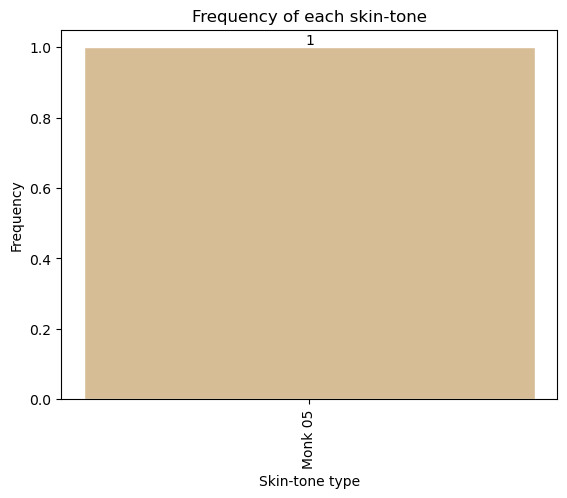

===============female_wrong===============


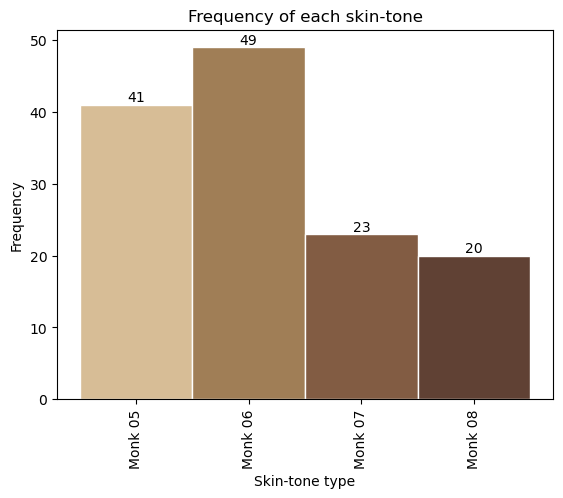

===============male_correct===============


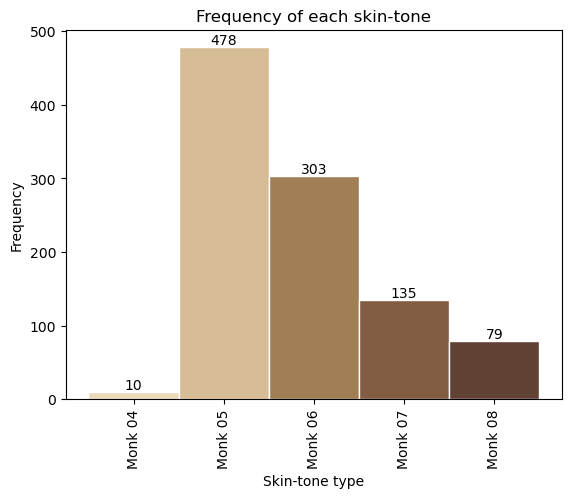

===============male_wrong===============


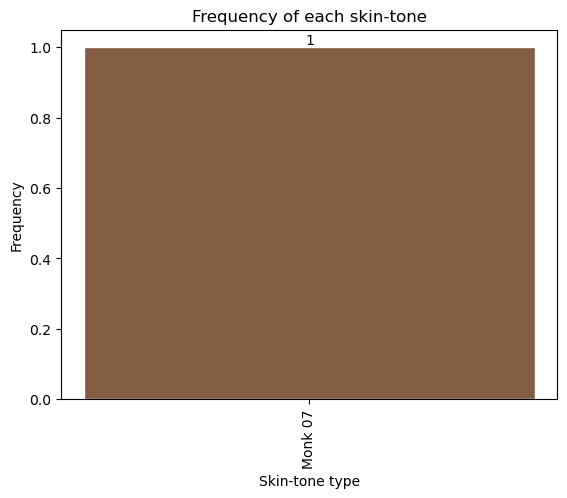

C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][correct_ind] = df[skin_tone][0] + df[skin_tone][2]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][wrong_ind] = df[skin_tone][1] + df[skin_tone][3]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3127628448.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

[1005, '78.71', 1, '0.00', 1, '100.00', 133, '67.67', 1006, '78.73', 134, '67.16']
                0 Monk 01  Monk 02 Monk 03  Monk 04 Monk 05  Monk 06 Monk 07  \
0    male_correct       0        0       0       10     478      303     135   
1      male_wrong       0        0       0        0       0        0       1   
2  female_correct       0        0       0        0       1        0       0   
3    female_wrong       0        0       0        0      41       49      23   
4         correct       0        0       0       10     479      303     135   
5           wrong       0        0       0        0      41       49      24   
6            1005   78.71        1    0.00        1  100.00      133   67.67   

   Monk 08 Monk 09  Monk 10 less_than_M7  more_than_equal_M7   total  \
0       79       0        0          791               214.0  1005.0   
1        0       0        0            0                 1.0     1.0   
2        0       0        0            1                 0.0

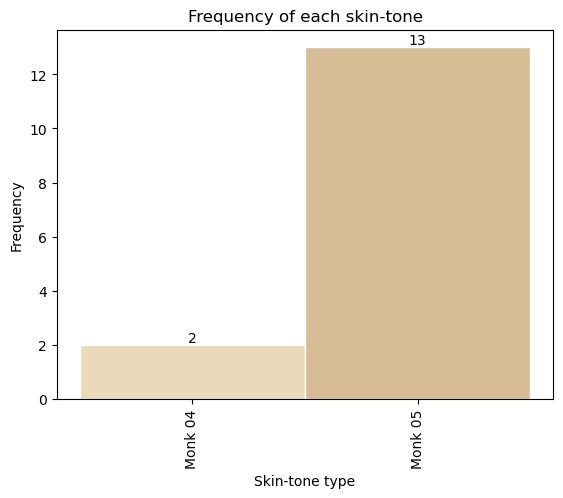

===============female_wrong===============


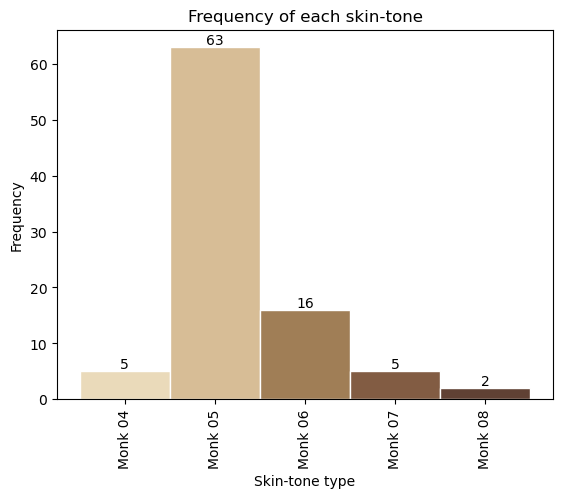

===============male_correct===============


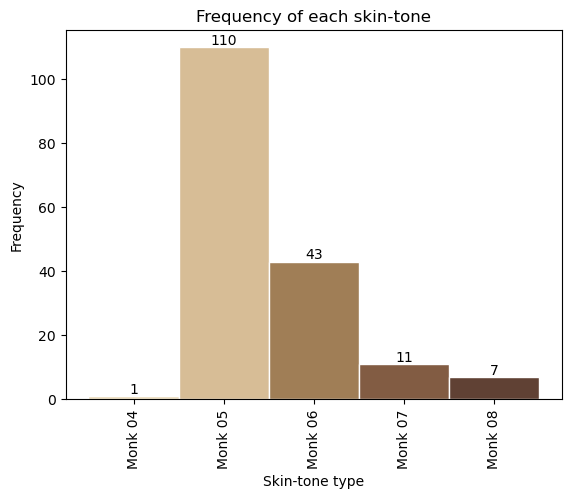

===============male_wrong===============
<class 'FileNotFoundError'>
(2, 'No such file or directory')
[Errno 2] No such file or directory: './../Skintone/skintone_result/deepface/New Zealand/male_wrong/result.csv'
[172, '89.53', 0, 'nan', 15, '100.00', 91, '92.31', 187, '90.37', 91, '92.31']
                0 Monk 01  Monk 02 Monk 03  Monk 04 Monk 05  Monk 06 Monk 07  \
0    male_correct       0        0       0        1     110       43      11   
1      male_wrong       0        0       0        0       0        0       0   
2  female_correct       0        0       0        2      13        0       0   
3    female_wrong       0        0       0        5      63       16       5   
4         correct       0        0       0        3     123       43      11   
5           wrong       0        0       0        5      63       16       5   
6             172   89.53        0     nan       15  100.00       91   92.31   

   Monk 08 Monk 09  Monk 10 less_than_M7  more_than_equal_M7  tota

C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][correct_ind] = df[skin_tone][0] + df[skin_tone][2]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][wrong_ind] = df[skin_tone][1] + df[skin_tone][3]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:20: RuntimeWarning: invalid value encountered in scalar divide
  df.at[i,'percentage_less_than_equal_Monk-06'] = (df['less_than_M7'][i]/df['total'][i])*100
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\31276

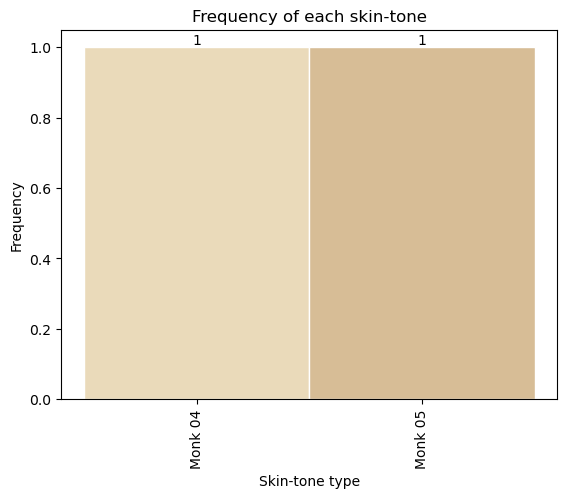

===============female_wrong===============


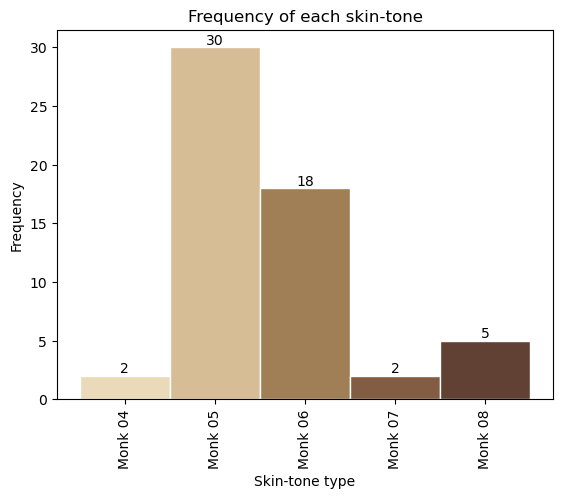

===============male_correct===============


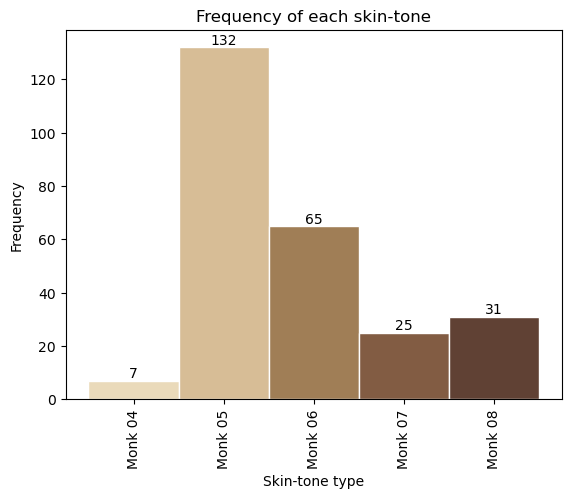

===============male_wrong===============


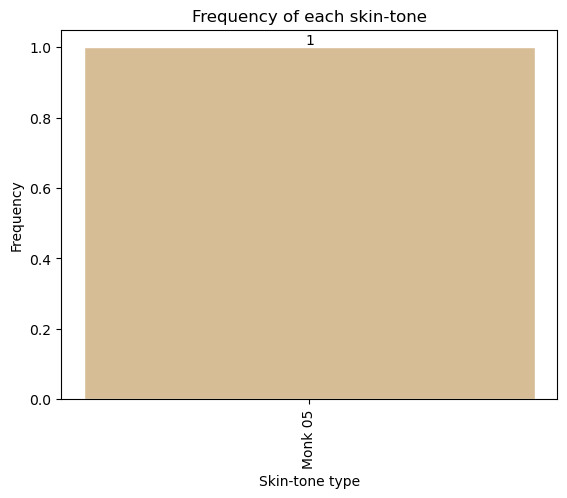

C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][correct_ind] = df[skin_tone][0] + df[skin_tone][2]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][wrong_ind] = df[skin_tone][1] + df[skin_tone][3]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3127628448.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

[260, '78.46', 1, '100.00', 2, '100.00', 57, '87.72', 262, '78.63', 58, '87.93']
                0 Monk 01  Monk 02 Monk 03  Monk 04 Monk 05  Monk 06 Monk 07  \
0    male_correct       0        0       0        7     132       65      25   
1      male_wrong       0        0       0        0       1        0       0   
2  female_correct       0        0       0        1       1        0       0   
3    female_wrong       0        0       0        2      30       18       2   
4         correct       0        0       0        8     133       65      25   
5           wrong       0        0       0        2      31       18       2   
6             260   78.46        1  100.00        2  100.00       57   87.72   

   Monk 08 Monk 09  Monk 10 less_than_M7  more_than_equal_M7  total  \
0       31       0        0          204                56.0  260.0   
1        0       0        0            1                 0.0    1.0   
2        0       0        0            2                 0.0    2

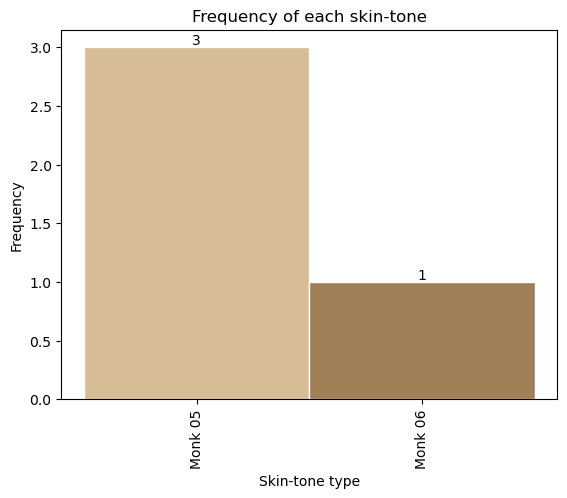

===============female_wrong===============


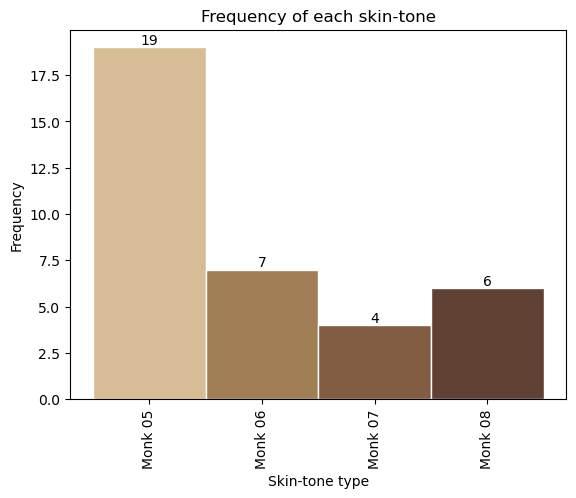

===============male_correct===============


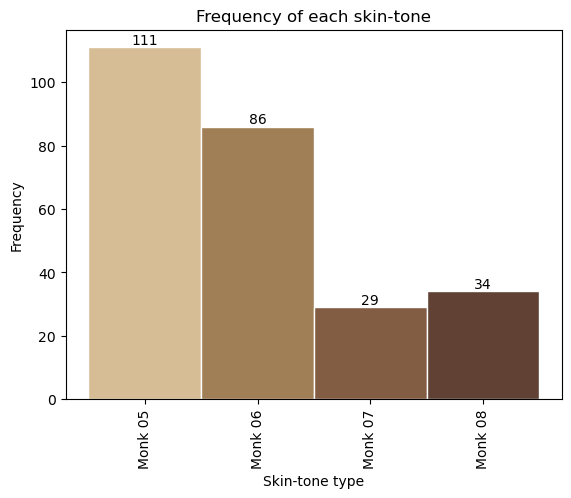

===============male_wrong===============


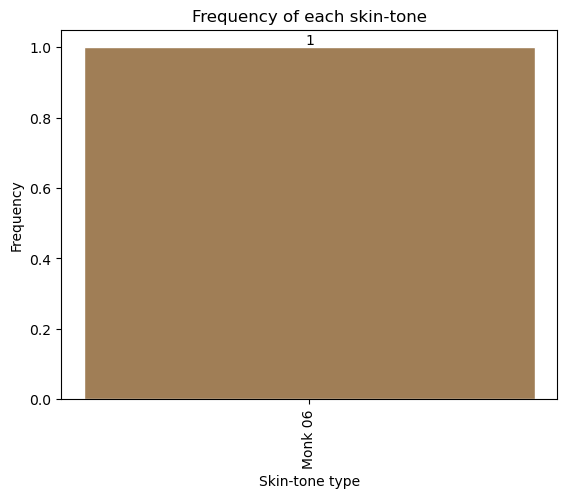

C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][correct_ind] = df[skin_tone][0] + df[skin_tone][2]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][wrong_ind] = df[skin_tone][1] + df[skin_tone][3]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3127628448.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

[260, '75.77', 1, '100.00', 4, '100.00', 36, '72.22', 264, '76.14', 37, '72.97']
                0 Monk 01  Monk 02 Monk 03  Monk 04 Monk 05  Monk 06 Monk 07  \
0    male_correct       0        0       0        0     111       86      29   
1      male_wrong       0        0       0        0       0        1       0   
2  female_correct       0        0       0        0       3        1       0   
3    female_wrong       0        0       0        0      19        7       4   
4         correct       0        0       0        0     114       87      29   
5           wrong       0        0       0        0      19        8       4   
6             260   75.77        1  100.00        4  100.00       36   72.22   

   Monk 08 Monk 09  Monk 10 less_than_M7  more_than_equal_M7  total  \
0       34       0        0          197                63.0  260.0   
1        0       0        0            1                 0.0    1.0   
2        0       0        0            4                 0.0    4

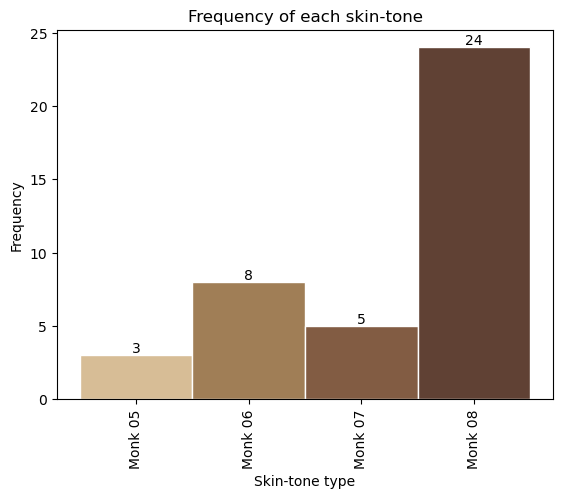

===============male_correct===============


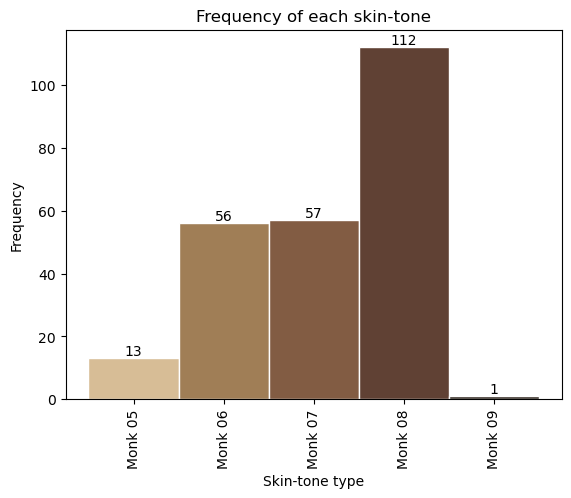

===============male_wrong===============
<class 'FileNotFoundError'>
(2, 'No such file or directory')
[Errno 2] No such file or directory: './../Skintone/skintone_result/deepface/West Indies/male_wrong/result.csv'
[239, '28.87', 0, 'nan', 0, 'nan', 40, '27.50', 239, '28.87', 40, '27.50']
                0 Monk 01  Monk 02 Monk 03  Monk 04 Monk 05  Monk 06 Monk 07  \
0    male_correct       0        0       0        0      13       56      57   
1      male_wrong       0        0       0        0       0        0       0   
2  female_correct       0        0       0        0       0        0       0   
3    female_wrong       0        0       0        0       3        8       5   
4         correct       0        0       0        0      13       56      57   
5           wrong       0        0       0        0       3        8       5   
6             239   28.87        0     nan        0     nan       40   27.50   

   Monk 08 Monk 09  Monk 10 less_than_M7  more_than_equal_M7  total  \

C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][correct_ind] = df[skin_tone][0] + df[skin_tone][2]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][wrong_ind] = df[skin_tone][1] + df[skin_tone][3]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:20: RuntimeWarning: invalid value encountered in scalar divide
  df.at[i,'percentage_less_than_equal_Monk-06'] = (df['less_than_M7'][i]/df['total'][i])*100
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\31276

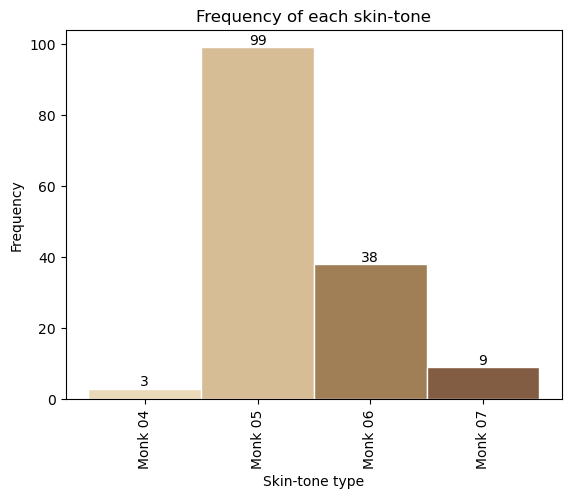

===============female_wrong===============


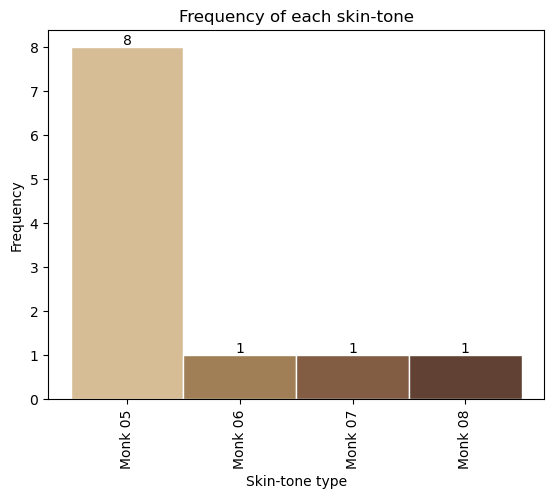

===============male_correct===============


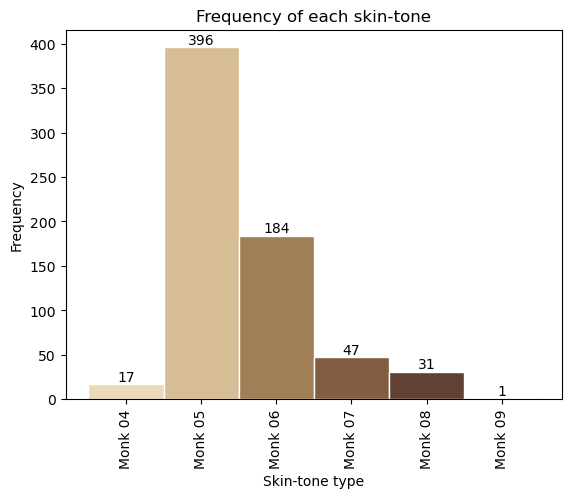

===============male_wrong===============


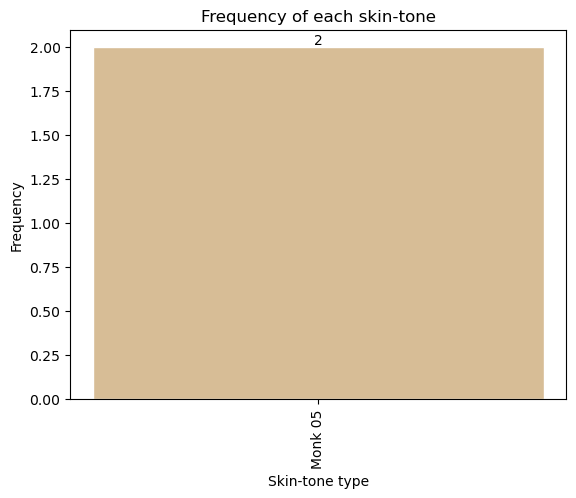

C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][correct_ind] = df[skin_tone][0] + df[skin_tone][2]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][wrong_ind] = df[skin_tone][1] + df[skin_tone][3]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3127628448.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

[676, '88.31', 2, '100.00', 149, '93.96', 11, '81.82', 825, '89.33', 13, '84.62']
                0 Monk 01  Monk 02 Monk 03  Monk 04 Monk 05  Monk 06 Monk 07  \
0    male_correct       0        0       0       17     396      184      47   
1      male_wrong       0        0       0        0       2        0       0   
2  female_correct       0        0       0        3      99       38       9   
3    female_wrong       0        0       0        0       8        1       1   
4         correct       0        0       0       20     495      222      56   
5           wrong       0        0       0        0      10        1       1   
6             676   88.31        2  100.00      149   93.96       11   81.82   

   Monk 08 Monk 09  Monk 10 less_than_M7  more_than_equal_M7  total  \
0       31       1        0          597                79.0  676.0   
1        0       0        0            2                 0.0    2.0   
2        0       0        0          140                 9.0  14

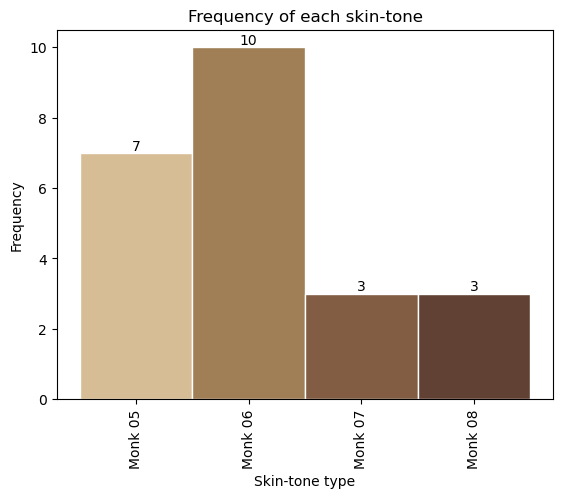

===============female_wrong===============


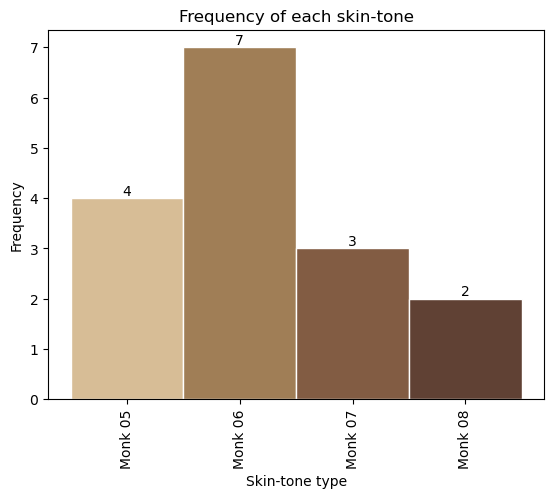

===============male_correct===============


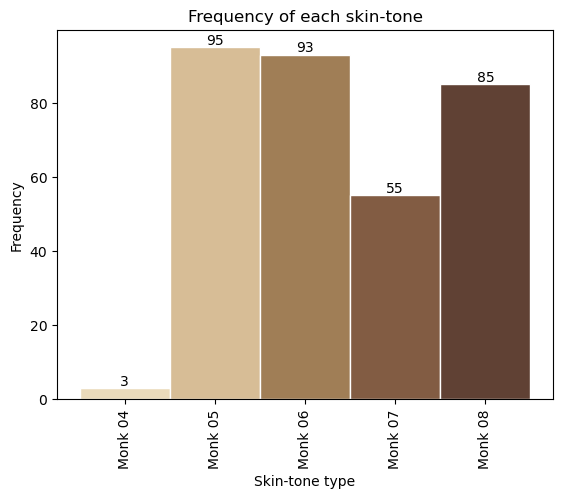

===============male_wrong===============


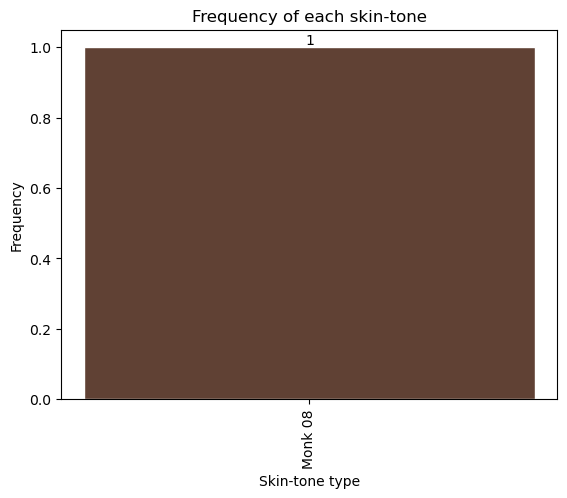

C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][correct_ind] = df[skin_tone][0] + df[skin_tone][2]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][wrong_ind] = df[skin_tone][1] + df[skin_tone][3]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3127628448.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

[331, '57.70', 1, '0.00', 23, '73.91', 16, '68.75', 354, '58.76', 17, '64.71']
                0 Monk 01  Monk 02 Monk 03  Monk 04 Monk 05  Monk 06 Monk 07  \
0    male_correct       0        0       0        3      95       93      55   
1      male_wrong       0        0       0        0       0        0       0   
2  female_correct       0        0       0        0       7       10       3   
3    female_wrong       0        0       0        0       4        7       3   
4         correct       0        0       0        3     102      103      58   
5           wrong       0        0       0        0       4        7       3   
6             331   57.70        1    0.00       23   73.91       16   68.75   

   Monk 08 Monk 09  Monk 10 less_than_M7  more_than_equal_M7  total  \
0       85       0        0          191               140.0  331.0   
1        1       0        0            0                 1.0    1.0   
2        3       0        0           17                 6.0   23.0

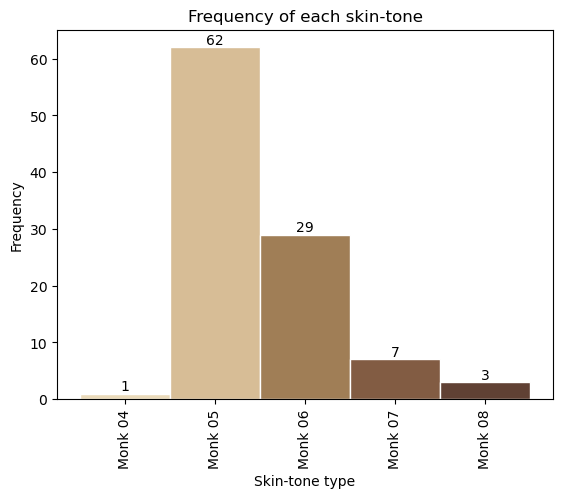

===============female_wrong===============


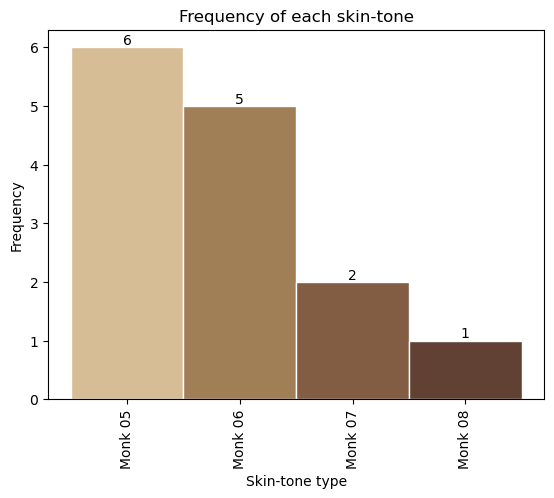

===============male_correct===============


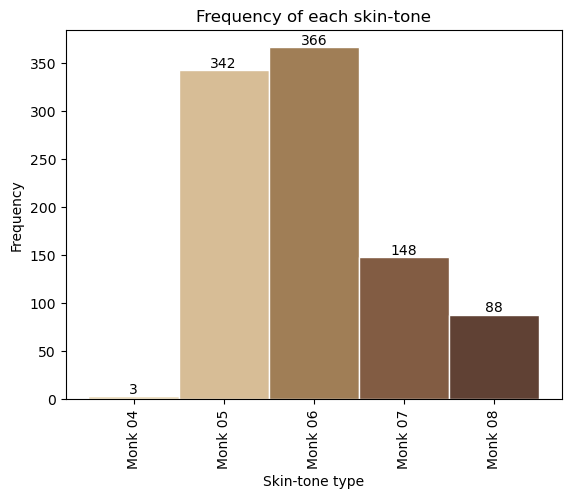

===============male_wrong===============


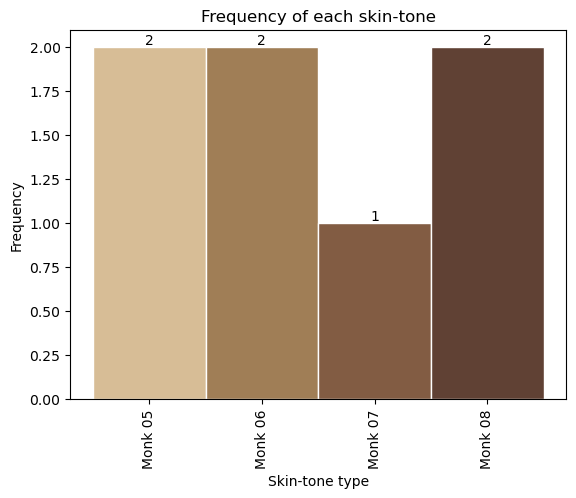

C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][correct_ind] = df[skin_tone][0] + df[skin_tone][2]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][wrong_ind] = df[skin_tone][1] + df[skin_tone][3]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3127628448.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

[947, '75.08', 7, '57.14', 102, '90.20', 14, '78.57', 1049, '76.55', 21, '71.43']
                0 Monk 01  Monk 02 Monk 03  Monk 04 Monk 05  Monk 06 Monk 07  \
0    male_correct       0        0       0        3     342      366     148   
1      male_wrong       0        0       0        0       2        2       1   
2  female_correct       0        0       0        1      62       29       7   
3    female_wrong       0        0       0        0       6        5       2   
4         correct       0        0       0        4     404      395     155   
5           wrong       0        0       0        0       8        7       3   
6             947   75.08        7   57.14      102   90.20       14   78.57   

   Monk 08 Monk 09  Monk 10 less_than_M7  more_than_equal_M7   total  \
0       88       0        0          711               236.0   947.0   
1        2       0        0            4                 3.0     7.0   
2        3       0        0           92                10.0 

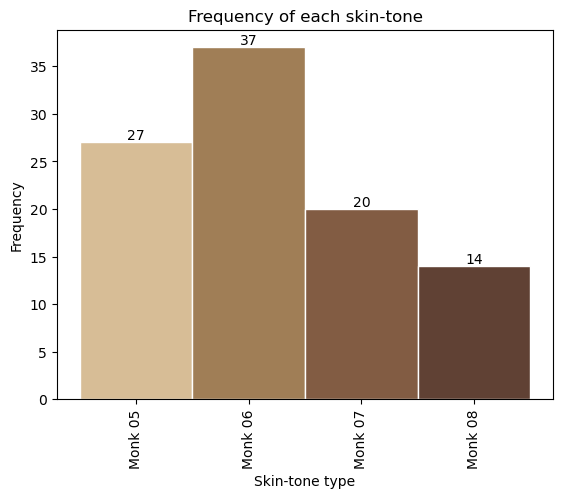

===============female_wrong===============


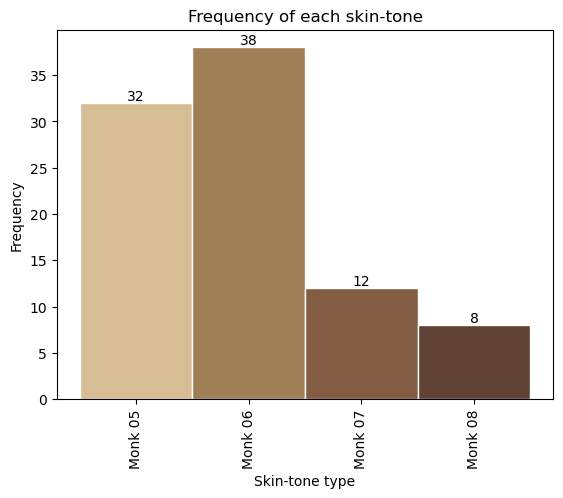

===============male_correct===============


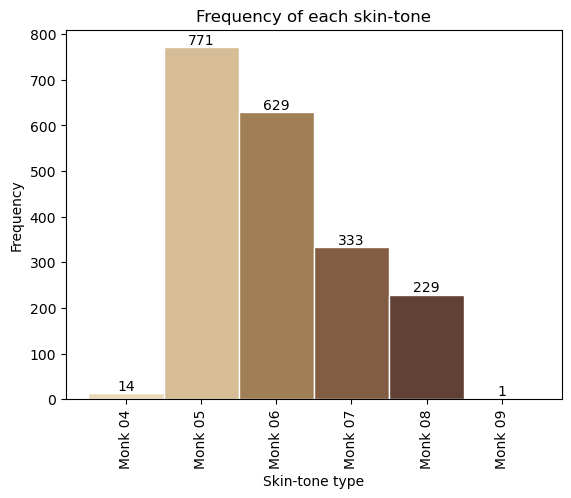

===============male_wrong===============


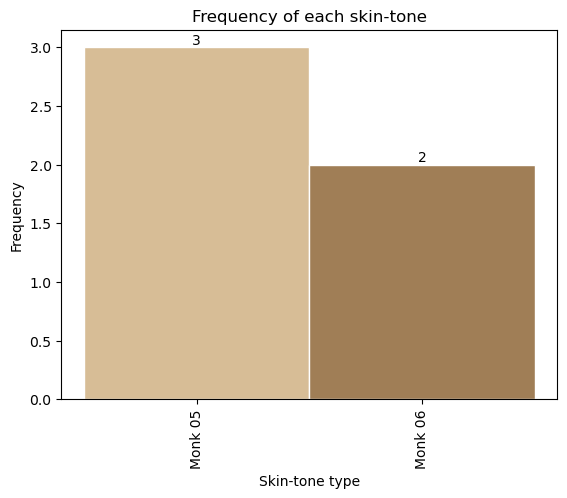

C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][correct_ind] = df[skin_tone][0] + df[skin_tone][2]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][wrong_ind] = df[skin_tone][1] + df[skin_tone][3]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3127628448.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

[1977, '71.52', 5, '100.00', 98, '65.31', 90, '77.78', 2075, '71.23', 95, '78.95']
                0 Monk 01  Monk 02 Monk 03  Monk 04 Monk 05  Monk 06 Monk 07  \
0    male_correct       0        0       0       14     771      629     333   
1      male_wrong       0        0       0        0       3        2       0   
2  female_correct       0        0       0        0      27       37      20   
3    female_wrong       0        0       0        0      32       38      12   
4         correct       0        0       0       14     798      666     353   
5           wrong       0        0       0        0      35       40      12   
6            1977   71.52        5  100.00       98   65.31       90   77.78   

   Monk 08 Monk 09  Monk 10 less_than_M7  more_than_equal_M7   total  \
0      229       1        0         1414               563.0  1977.0   
1        0       0        0            5                 0.0     5.0   
2       14       0        0           64                34.0

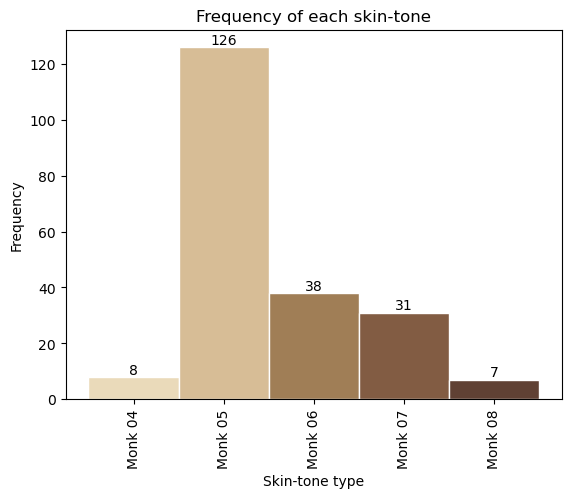

===============female_wrong===============


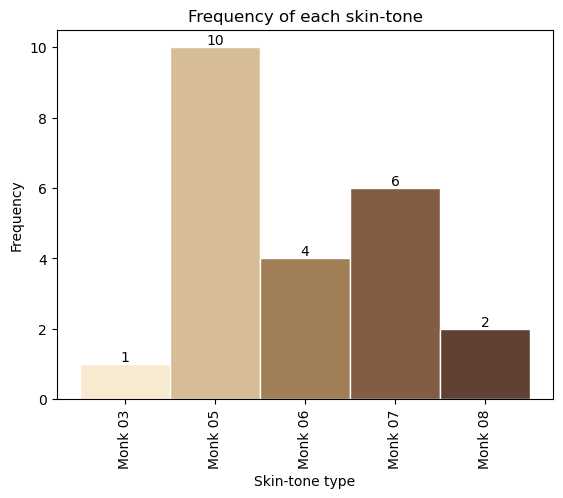

===============male_correct===============


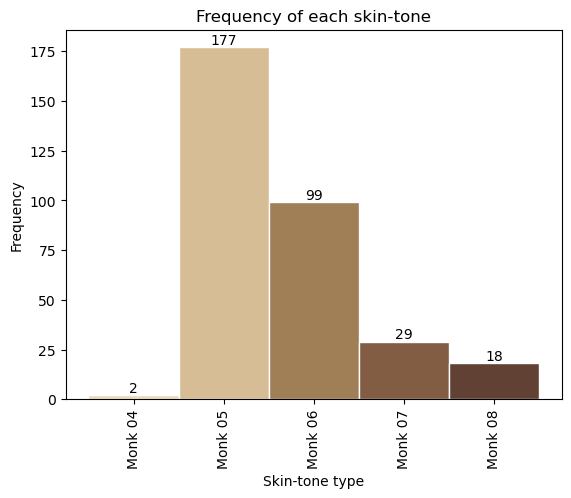

===============male_wrong===============


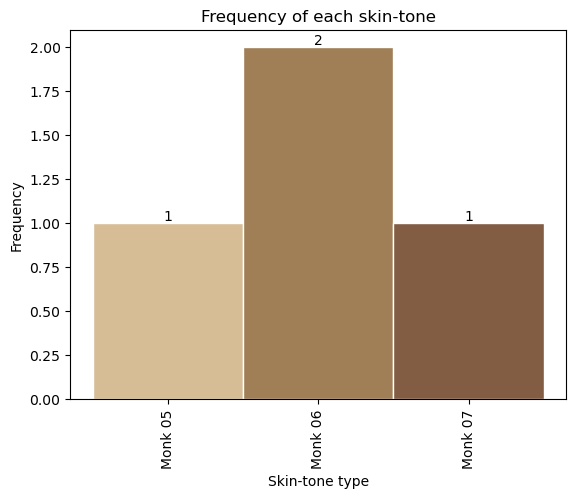

C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][correct_ind] = df[skin_tone][0] + df[skin_tone][2]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][wrong_ind] = df[skin_tone][1] + df[skin_tone][3]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3127628448.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

[325, '85.54', 4, '75.00', 210, '81.90', 23, '65.22', 535, '84.11', 27, '66.67']
                0 Monk 01  Monk 02 Monk 03  Monk 04 Monk 05  Monk 06 Monk 07  \
0    male_correct       0        0       0        2     177       99      29   
1      male_wrong       0        0       0        0       1        2       1   
2  female_correct       0        0       0        8     126       38      31   
3    female_wrong       0        0       1        0      10        4       6   
4         correct       0        0       0       10     303      137      60   
5           wrong       0        0       1        0      11        6       7   
6             325   85.54        4   75.00      210   81.90       23   65.22   

   Monk 08 Monk 09  Monk 10 less_than_M7  more_than_equal_M7  total  \
0       18       0        0          278                47.0  325.0   
1        0       0        0            3                 1.0    4.0   
2        7       0        0          172                38.0  210

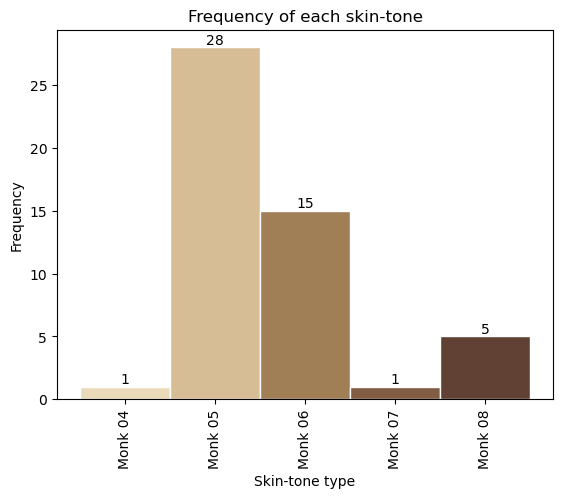

===============female_wrong===============


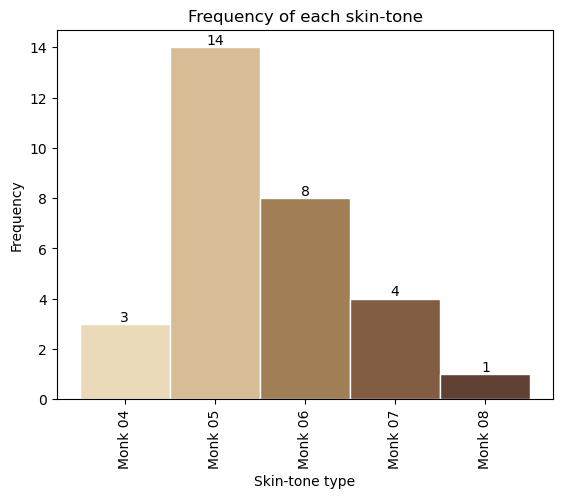

===============male_correct===============


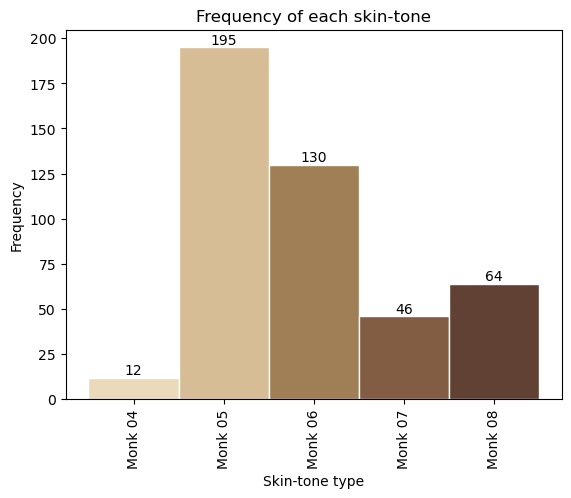

===============male_wrong===============
<class 'FileNotFoundError'>
(2, 'No such file or directory')
[Errno 2] No such file or directory: './../Skintone/skintone_result/facepp/Pakistan/male_wrong/result.csv'
[447, '75.39', 0, 'nan', 50, '88.00', 30, '83.33', 497, '76.66', 30, '83.33']
                0 Monk 01  Monk 02 Monk 03  Monk 04 Monk 05  Monk 06 Monk 07  \
0    male_correct       0        0       0       12     195      130      46   
1      male_wrong       0        0       0        0       0        0       0   
2  female_correct       0        0       0        1      28       15       1   
3    female_wrong       0        0       0        3      14        8       4   
4         correct       0        0       0       13     223      145      47   
5           wrong       0        0       0        3      14        8       4   
6             447   75.39        0     nan       50   88.00       30   83.33   

   Monk 08 Monk 09  Monk 10 less_than_M7  more_than_equal_M7  total  \
0

C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][correct_ind] = df[skin_tone][0] + df[skin_tone][2]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][wrong_ind] = df[skin_tone][1] + df[skin_tone][3]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:20: RuntimeWarning: invalid value encountered in scalar divide
  df.at[i,'percentage_less_than_equal_Monk-06'] = (df['less_than_M7'][i]/df['total'][i])*100
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\31276

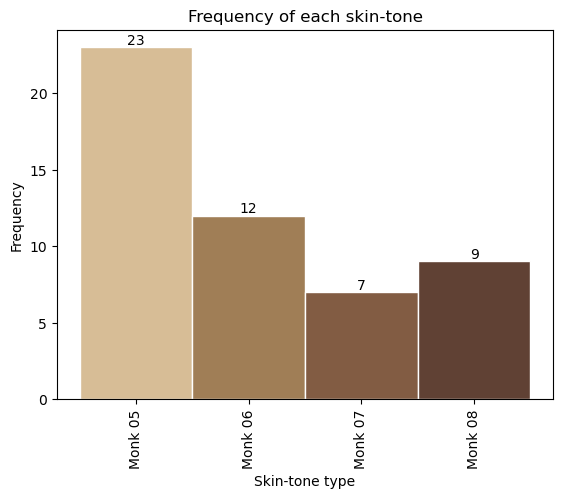

===============female_wrong===============


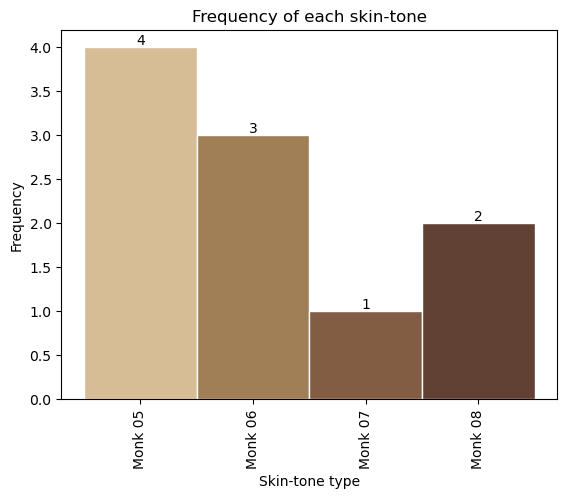

===============male_correct===============


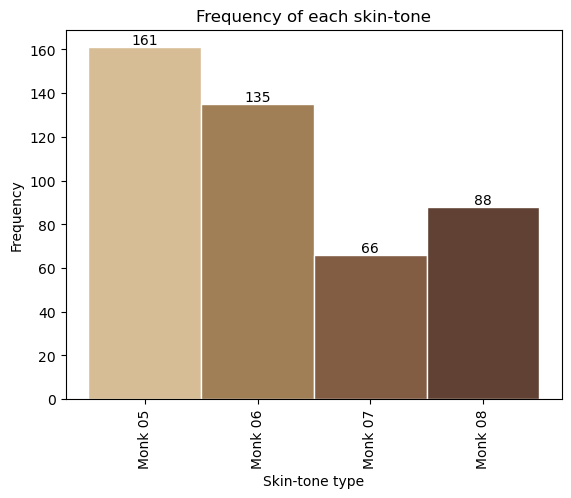

===============male_wrong===============


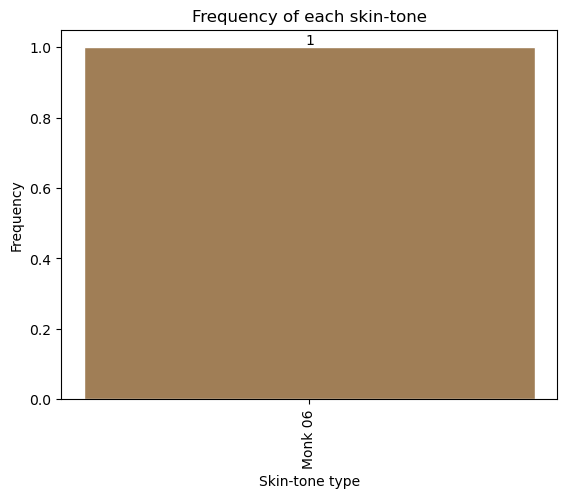

C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][correct_ind] = df[skin_tone][0] + df[skin_tone][2]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][wrong_ind] = df[skin_tone][1] + df[skin_tone][3]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3127628448.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

[450, '65.78', 1, '100.00', 51, '68.63', 10, '70.00', 501, '66.07', 11, '72.73']
                0 Monk 01  Monk 02 Monk 03  Monk 04 Monk 05  Monk 06 Monk 07  \
0    male_correct       0        0       0        0     161      135      66   
1      male_wrong       0        0       0        0       0        1       0   
2  female_correct       0        0       0        0      23       12       7   
3    female_wrong       0        0       0        0       4        3       1   
4         correct       0        0       0        0     184      147      73   
5           wrong       0        0       0        0       4        4       1   
6             450   65.78        1  100.00       51   68.63       10   70.00   

   Monk 08 Monk 09  Monk 10 less_than_M7  more_than_equal_M7  total  \
0       88       0        0          296               154.0  450.0   
1        0       0        0            1                 0.0    1.0   
2        9       0        0           35                16.0   51

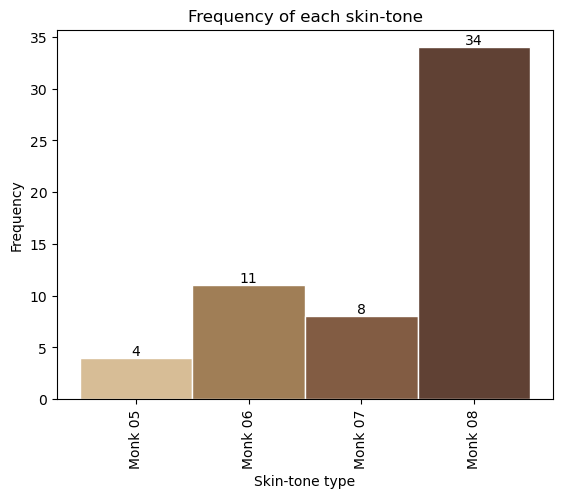

===============female_wrong===============


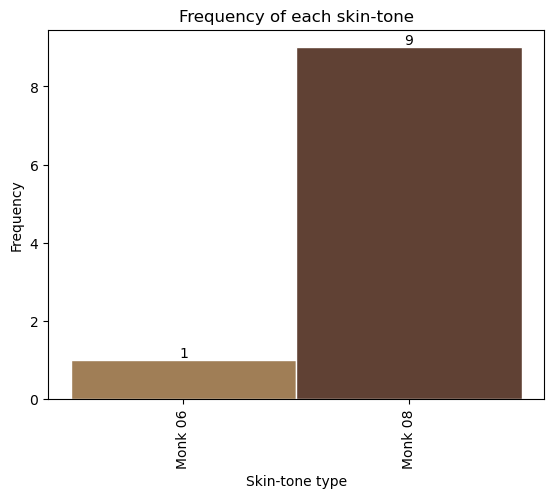

===============male_correct===============


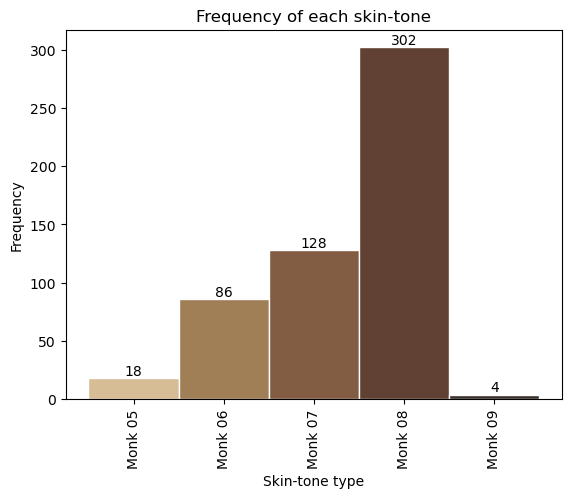

===============male_wrong===============


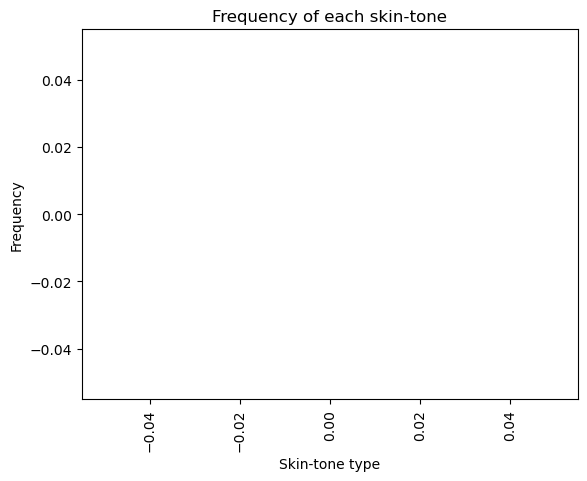

C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][correct_ind] = df[skin_tone][0] + df[skin_tone][2]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][wrong_ind] = df[skin_tone][1] + df[skin_tone][3]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:20: RuntimeWarning: invalid value encountered in scalar divide
  df.at[i,'percentage_less_than_equal_Monk-06'] = (df['less_than_M7'][i]/df['total'][i])*100
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\31276

[538, '19.33', 0, 'nan', 57, '26.32', 10, '10.00', 595, '20.00', 10, '10.00']
                0 Monk 01  Monk 02 Monk 03  Monk 04 Monk 05  Monk 06 Monk 07  \
0    male_correct       0        0       0        0      18       86     128   
1      male_wrong       0        0       0        0       0        0       0   
2  female_correct       0        0       0        0       4       11       8   
3    female_wrong       0        0       0        0       0        1       0   
4         correct       0        0       0        0      22       97     136   
5           wrong       0        0       0        0       0        1       0   
6             538   19.33        0     nan       57   26.32       10   10.00   

   Monk 08 Monk 09  Monk 10 less_than_M7  more_than_equal_M7  total  \
0      302       4        0          104               434.0  538.0   
1        0       0        0            0                 0.0    0.0   
2       34       0        0           15                42.0   57.0 

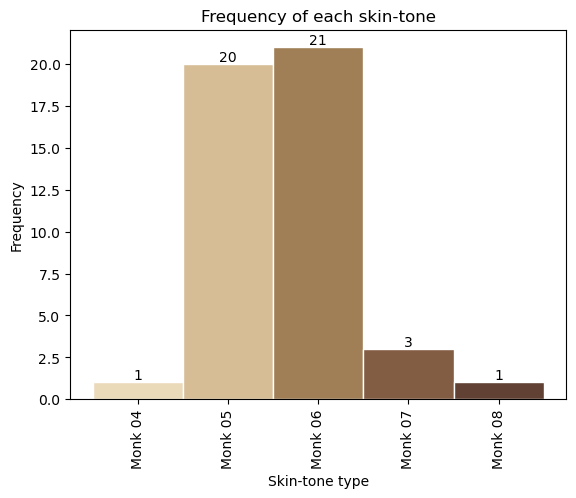

===============female_wrong===============


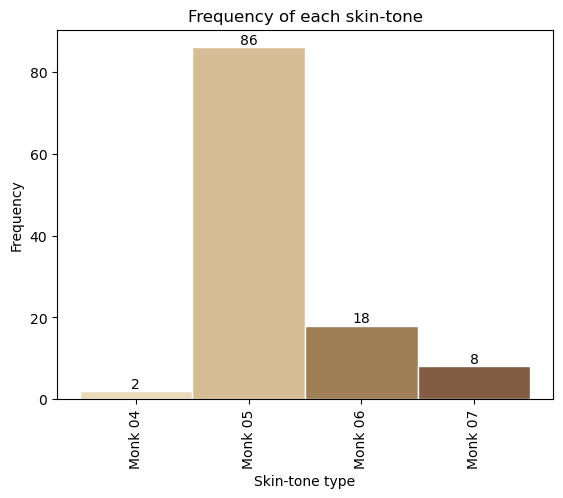

===============male_correct===============


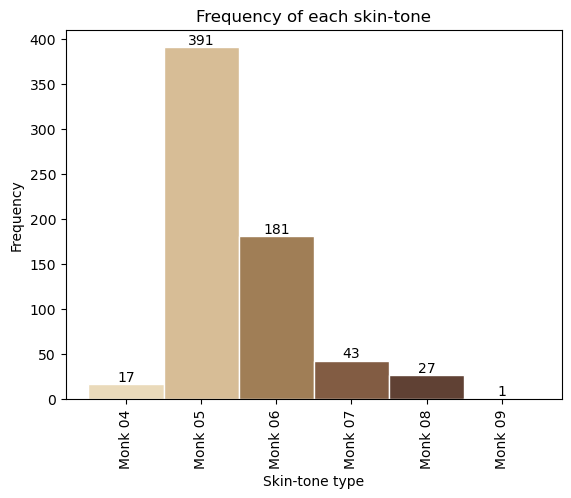

===============male_wrong===============


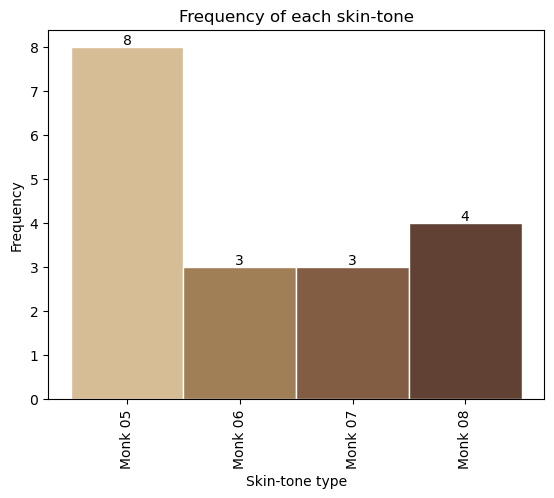

C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][correct_ind] = df[skin_tone][0] + df[skin_tone][2]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][wrong_ind] = df[skin_tone][1] + df[skin_tone][3]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3127628448.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

[660, '89.24', 18, '61.11', 46, '91.30', 114, '92.98', 706, '89.38', 132, '88.64']
                0 Monk 01  Monk 02 Monk 03  Monk 04 Monk 05  Monk 06 Monk 07  \
0    male_correct       0        0       0       17     391      181      43   
1      male_wrong       0        0       0        0       8        3       3   
2  female_correct       0        0       0        1      20       21       3   
3    female_wrong       0        0       0        2      86       18       8   
4         correct       0        0       0       18     411      202      46   
5           wrong       0        0       0        2      94       21      11   
6             660   89.24       18   61.11       46   91.30      114   92.98   

   Monk 08 Monk 09  Monk 10 less_than_M7  more_than_equal_M7  total  \
0       27       1        0          589                71.0  660.0   
1        4       0        0           11                 7.0   18.0   
2        1       0        0           42                 4.0   

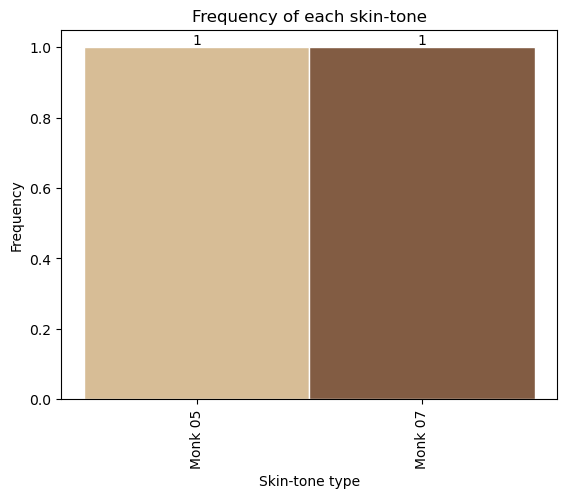

===============female_wrong===============


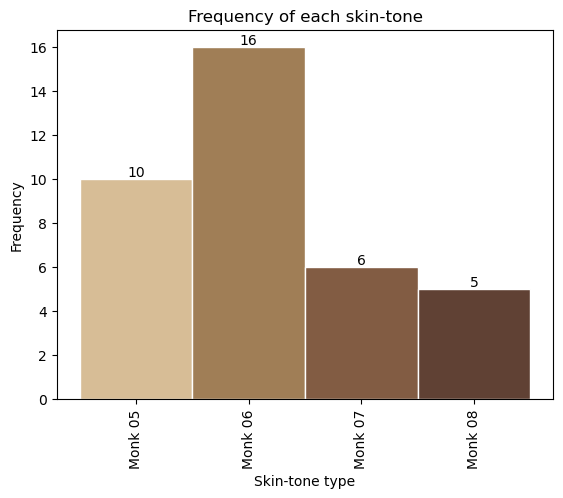

===============male_correct===============


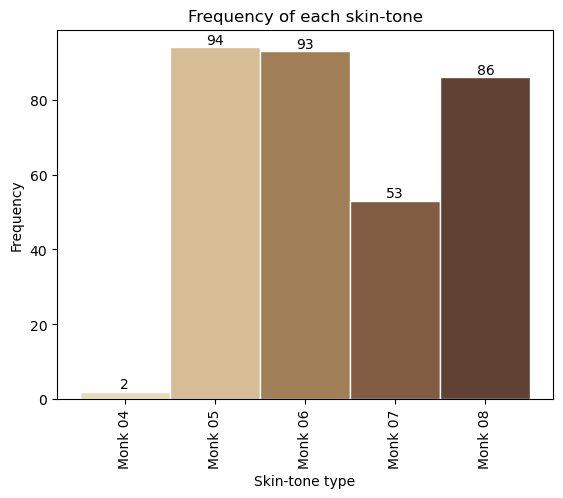

===============male_wrong===============


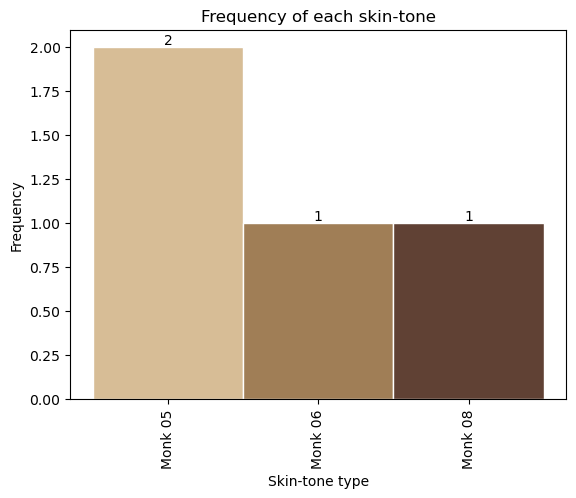

C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][correct_ind] = df[skin_tone][0] + df[skin_tone][2]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][wrong_ind] = df[skin_tone][1] + df[skin_tone][3]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3127628448.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

[328, '57.62', 4, '75.00', 2, '50.00', 37, '70.27', 330, '57.58', 41, '70.73']
                0 Monk 01  Monk 02 Monk 03  Monk 04 Monk 05  Monk 06 Monk 07  \
0    male_correct       0        0       0        2      94       93      53   
1      male_wrong       0        0       0        0       2        1       0   
2  female_correct       0        0       0        0       1        0       1   
3    female_wrong       0        0       0        0      10       16       6   
4         correct       0        0       0        2      95       93      54   
5           wrong       0        0       0        0      12       17       6   
6             328   57.62        4   75.00        2   50.00       37   70.27   

   Monk 08 Monk 09  Monk 10 less_than_M7  more_than_equal_M7  total  \
0       86       0        0          189               139.0  328.0   
1        1       0        0            3                 1.0    4.0   
2        0       0        0            1                 1.0    2.0

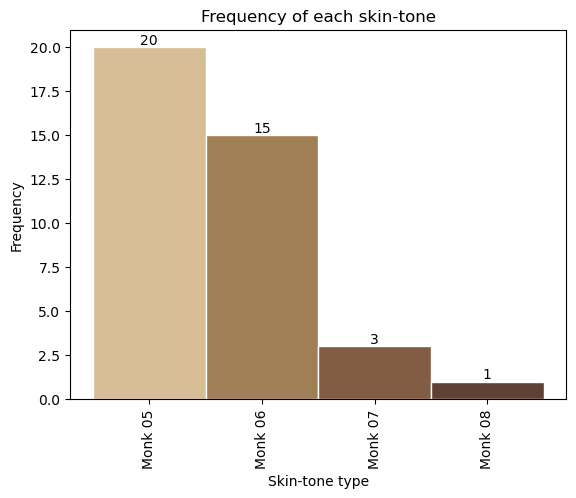

===============female_wrong===============


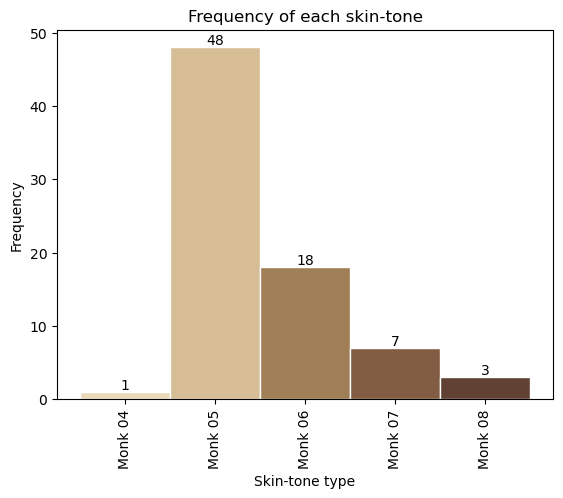

===============male_correct===============


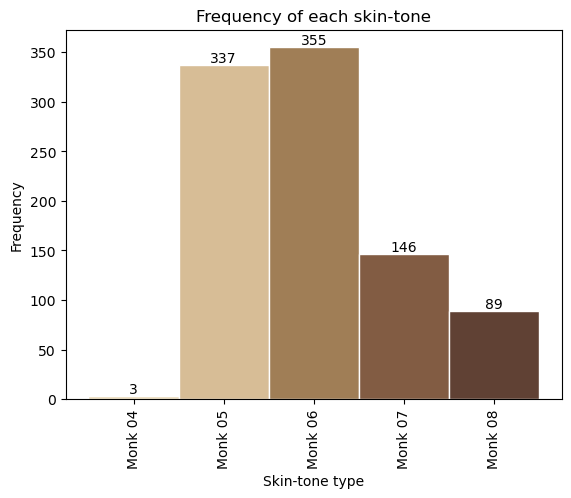

===============male_wrong===============


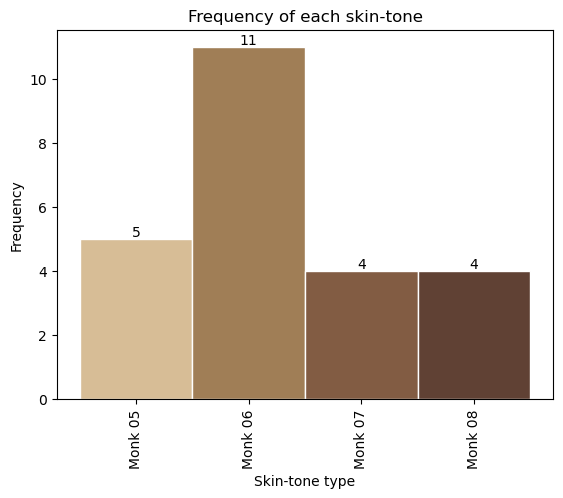

C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][correct_ind] = df[skin_tone][0] + df[skin_tone][2]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][wrong_ind] = df[skin_tone][1] + df[skin_tone][3]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3127628448.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

[930, '74.73', 24, '66.67', 39, '89.74', 77, '87.01', 969, '75.34', 101, '82.18']
                0 Monk 01  Monk 02 Monk 03  Monk 04 Monk 05  Monk 06 Monk 07  \
0    male_correct       0        0       0        3     337      355     146   
1      male_wrong       0        0       0        0       5       11       4   
2  female_correct       0        0       0        0      20       15       3   
3    female_wrong       0        0       0        1      48       18       7   
4         correct       0        0       0        3     357      370     149   
5           wrong       0        0       0        1      53       29      11   
6             930   74.73       24   66.67       39   89.74       77   87.01   

   Monk 08 Monk 09  Monk 10 less_than_M7  more_than_equal_M7  total  \
0       89       0        0          695               235.0  930.0   
1        4       0        0           16                 8.0   24.0   
2        1       0        0           35                 4.0   3

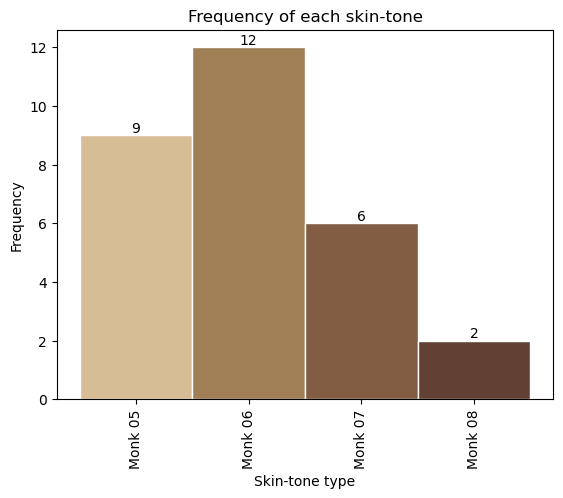

===============female_wrong===============


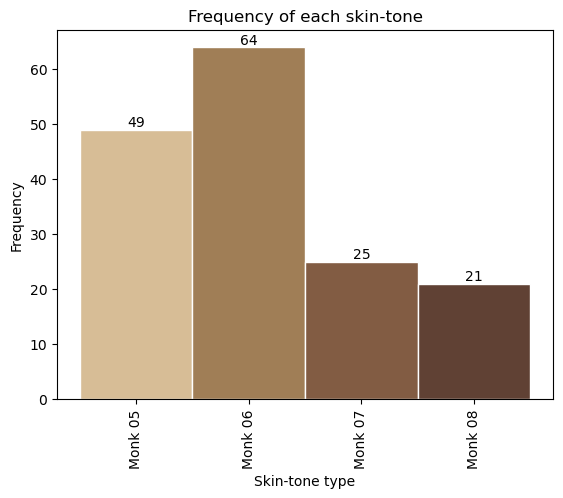

===============male_correct===============


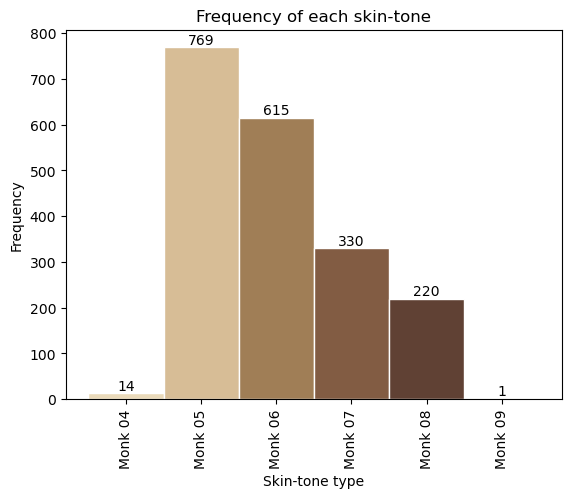

===============male_wrong===============


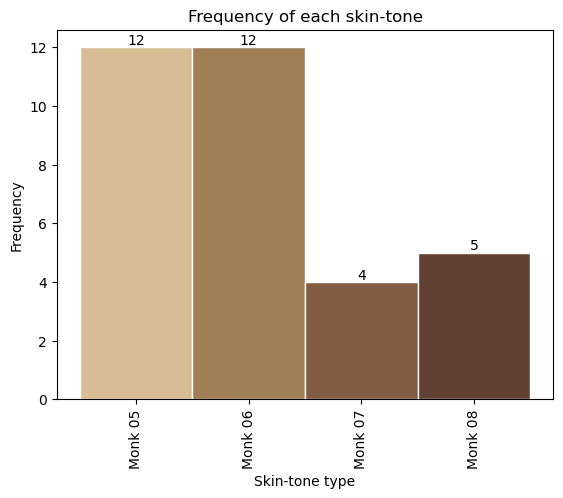

C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][correct_ind] = df[skin_tone][0] + df[skin_tone][2]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][wrong_ind] = df[skin_tone][1] + df[skin_tone][3]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3127628448.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

[1949, '71.73', 33, '72.73', 29, '72.41', 159, '71.07', 1978, '71.74', 192, '71.35']
                0 Monk 01  Monk 02 Monk 03  Monk 04 Monk 05  Monk 06 Monk 07  \
0    male_correct       0        0       0       14     769      615     330   
1      male_wrong       0        0       0        0      12       12       4   
2  female_correct       0        0       0        0       9       12       6   
3    female_wrong       0        0       0        0      49       64      25   
4         correct       0        0       0       14     778      627     336   
5           wrong       0        0       0        0      61       76      29   
6            1949   71.73       33   72.73       29   72.41      159   71.07   

   Monk 08 Monk 09  Monk 10 less_than_M7  more_than_equal_M7   total  \
0      220       1        0         1398               551.0  1949.0   
1        5       0        0           24                 9.0    33.0   
2        2       0        0           21                 8

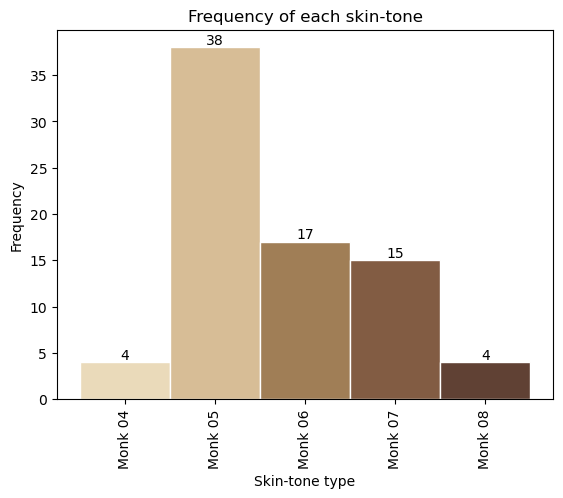

===============female_wrong===============


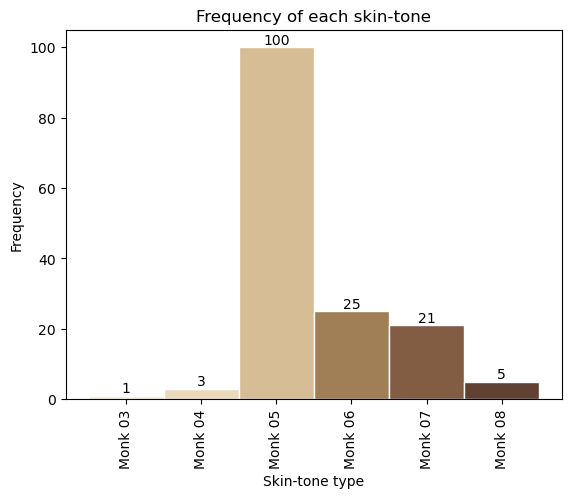

===============male_correct===============


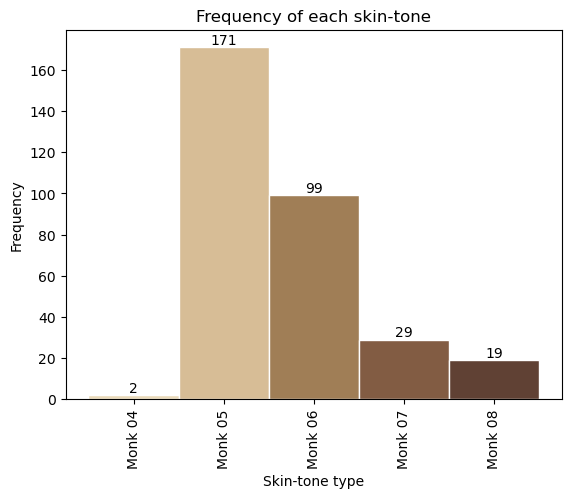

===============male_wrong===============


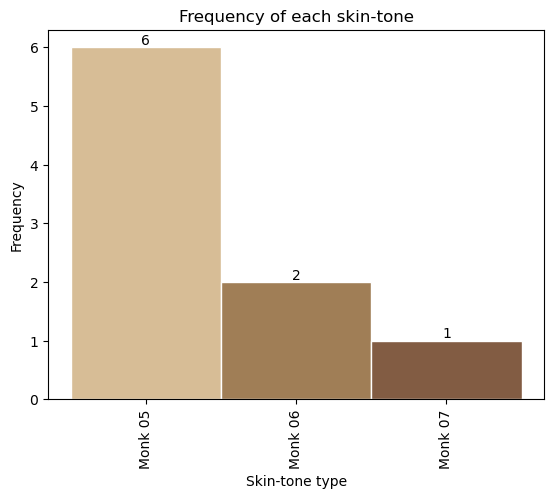

C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][correct_ind] = df[skin_tone][0] + df[skin_tone][2]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][wrong_ind] = df[skin_tone][1] + df[skin_tone][3]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3127628448.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

[320, '85.00', 9, '88.89', 78, '75.64', 155, '83.23', 398, '83.17', 164, '83.54']
                0 Monk 01  Monk 02 Monk 03  Monk 04 Monk 05  Monk 06 Monk 07  \
0    male_correct       0        0       0        2     171       99      29   
1      male_wrong       0        0       0        0       6        2       1   
2  female_correct       0        0       0        4      38       17      15   
3    female_wrong       0        0       1        3     100       25      21   
4         correct       0        0       0        6     209      116      44   
5           wrong       0        0       1        3     106       27      22   
6             320   85.00        9   88.89       78   75.64      155   83.23   

   Monk 08 Monk 09  Monk 10 less_than_M7  more_than_equal_M7  total  \
0       19       0        0          272                48.0  320.0   
1        0       0        0            8                 1.0    9.0   
2        4       0        0           59                19.0   7

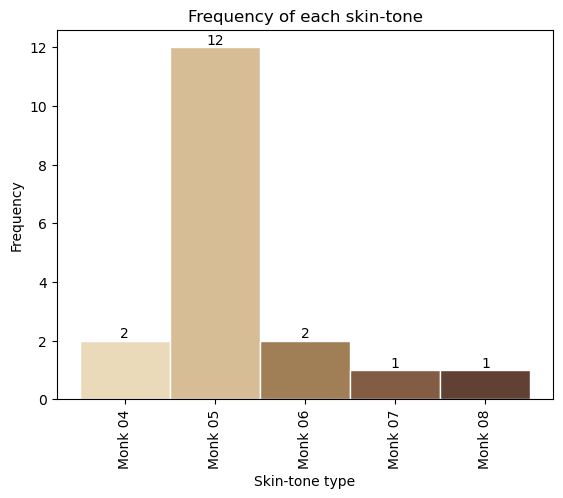

===============female_wrong===============


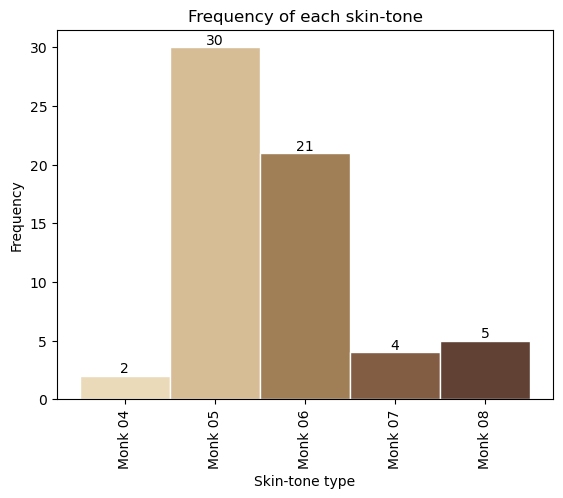

===============male_correct===============


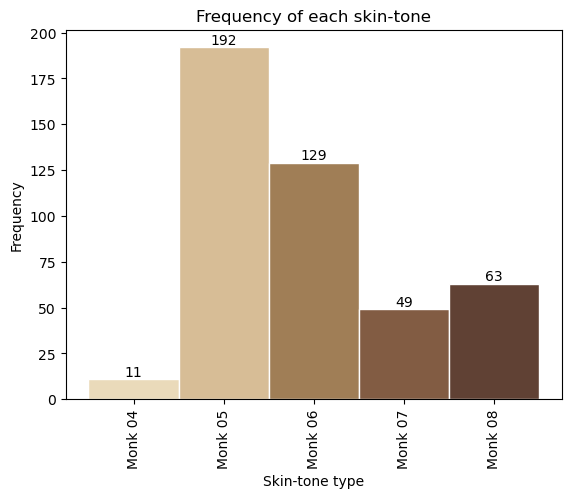

===============male_wrong===============


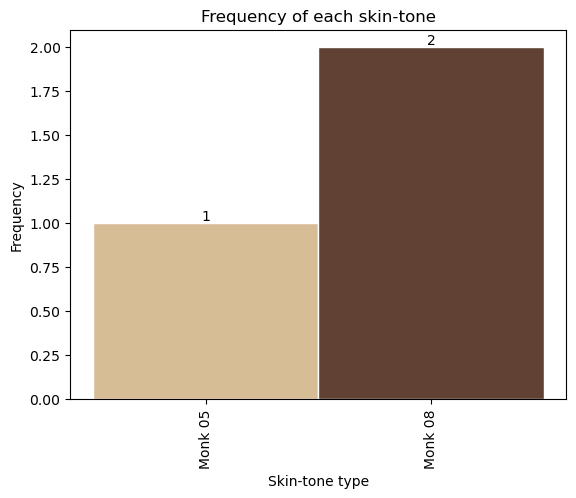

C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][correct_ind] = df[skin_tone][0] + df[skin_tone][2]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][wrong_ind] = df[skin_tone][1] + df[skin_tone][3]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3127628448.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

[444, '74.77', 3, '33.33', 18, '88.89', 62, '85.48', 462, '75.32', 65, '83.08']
                0 Monk 01  Monk 02 Monk 03  Monk 04 Monk 05  Monk 06 Monk 07  \
0    male_correct       0        0       0       11     192      129      49   
1      male_wrong       0        0       0        0       1        0       0   
2  female_correct       0        0       0        2      12        2       1   
3    female_wrong       0        0       0        2      30       21       4   
4         correct       0        0       0       13     204      131      50   
5           wrong       0        0       0        2      31       21       4   
6             444   74.77        3   33.33       18   88.89       62   85.48   

   Monk 08 Monk 09  Monk 10 less_than_M7  more_than_equal_M7  total  \
0       63       0        0          332               112.0  444.0   
1        2       0        0            1                 2.0    3.0   
2        1       0        0           16                 2.0   18.

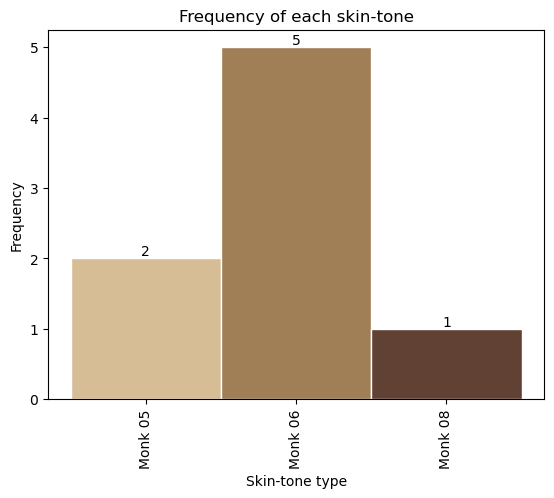

===============female_wrong===============


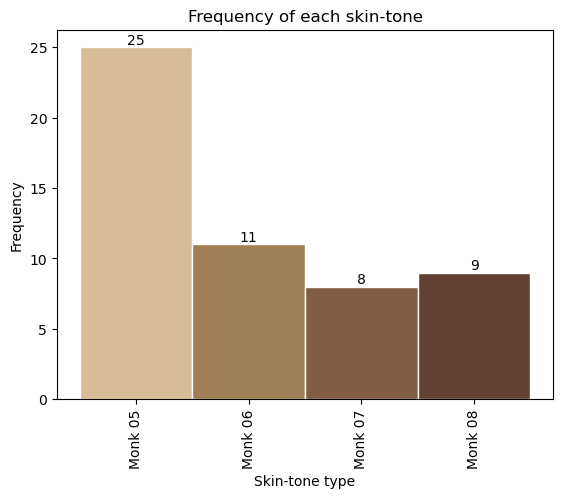

===============male_correct===============


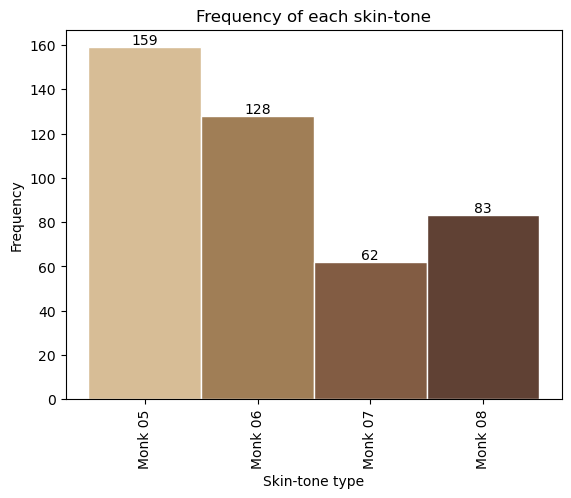

===============male_wrong===============


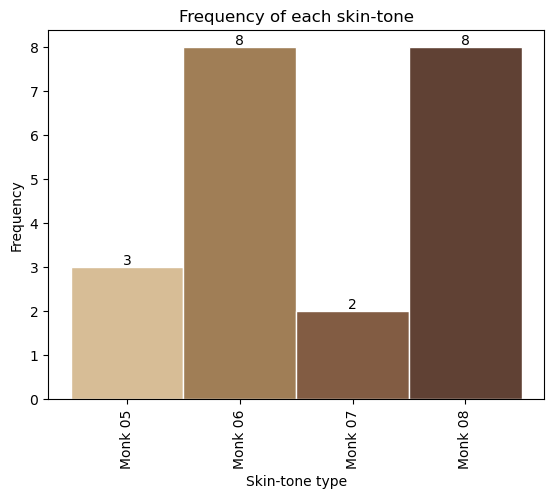

C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][correct_ind] = df[skin_tone][0] + df[skin_tone][2]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][wrong_ind] = df[skin_tone][1] + df[skin_tone][3]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3127628448.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

[432, '66.44', 21, '52.38', 8, '87.50', 53, '67.92', 440, '66.82', 74, '63.51']
                0 Monk 01  Monk 02 Monk 03  Monk 04 Monk 05  Monk 06 Monk 07  \
0    male_correct       0        0       0        0     159      128      62   
1      male_wrong       0        0       0        0       3        8       2   
2  female_correct       0        0       0        0       2        5       0   
3    female_wrong       0        0       0        0      25       11       8   
4         correct       0        0       0        0     161      133      62   
5           wrong       0        0       0        0      28       19      10   
6             432   66.44       21   52.38        8   87.50       53   67.92   

   Monk 08 Monk 09  Monk 10 less_than_M7  more_than_equal_M7  total  \
0       83       0        0          287               145.0  432.0   
1        8       0        0           11                10.0   21.0   
2        1       0        0            7                 1.0    8.

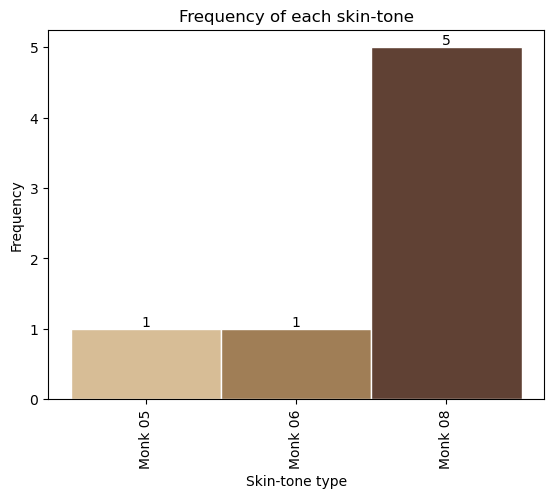

===============female_wrong===============


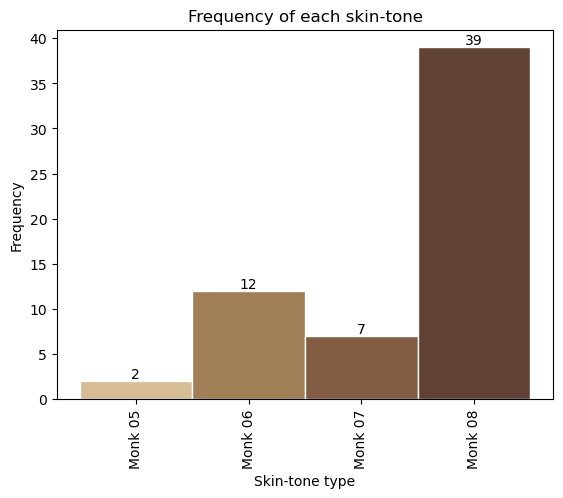

===============male_correct===============


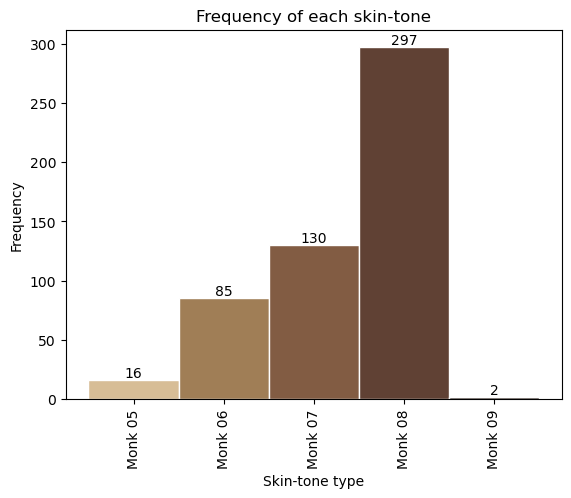

===============male_wrong===============


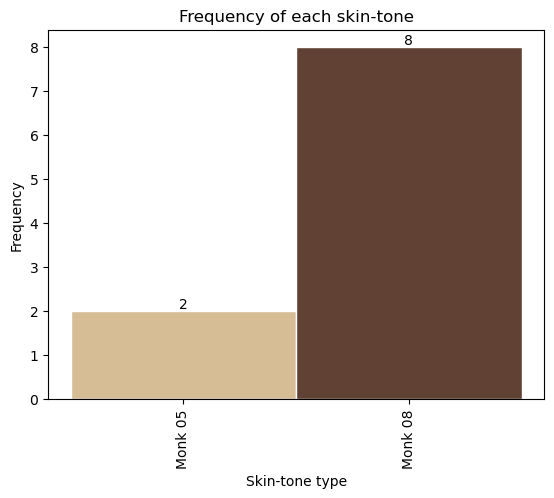

[530, '19.06', 10, '20.00', 7, '28.57', 60, '23.33', 537, '19.18', 70, '22.86']
                0 Monk 01  Monk 02 Monk 03  Monk 04 Monk 05  Monk 06 Monk 07  \
0    male_correct       0        0       0        0      16       85     130   
1      male_wrong       0        0       0        0       2        0       0   
2  female_correct       0        0       0        0       1        1       0   
3    female_wrong       0        0       0        0       2       12       7   
4         correct       0        0       0        0      17       86     130   
5           wrong       0        0       0        0       4       12       7   
6             530   19.06       10   20.00        7   28.57       60   23.33   

   Monk 08 Monk 09  Monk 10 less_than_M7  more_than_equal_M7  total  \
0      297       2        0          101               429.0  530.0   
1        8       0        0            2                 8.0   10.0   
2        5       0        0            2                 5.0    7.

C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][correct_ind] = df[skin_tone][0] + df[skin_tone][2]
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\3454106515.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[skin_tone][wrong_ind] = df[skin_tone][1] + df[skin_tone][3]


In [18]:
def create_folder(path):
    try:
        os.mkdir(path)
    except:
        pass

def hex_to_lab(hex_color):
    # Convert hex color to sRGBColor
    rgb_color = sRGBColor.new_from_rgb_hex(hex_color)
    # Convert sRGBColor to LabColor
    lab_color = convert_color(rgb_color, LabColor)
    return lab_color

for i in range(len(std_skin_tones)):
    skin_tone_ind[std_skin_tones[i]] = i

    
def skin_tone_analysis(inp_path,out_path,valid_img_path):
    out_path += "plots_RGB_DISTANCE"
    create_folder(out_path)
    std_skin_tones = ["#f6ede4","#f3e7db","#f7ead0","#eadaba","#d7bd96","#a07e56","#825c43","#604134","#3a312a","#292420"]
#     ALL_APIS = ['facepp','azure','aws']
    ALL_APIS = os.listdir(inp_path)
    for API_NAME in ALL_APIS:
        print("API-NAME : "+API_NAME)
        out_path_api = out_path+"/"+API_NAME
        create_folder(out_path_api)
        path_api = inp_path+API_NAME
        countries = os.listdir(path_api)
        for country in countries:
            print("################"+country+"################")
            # Getting the valid image path (CSV file where status of the each image file is written)
            valid_img_path_country = valid_img_path+"/"+country+".csv"
            # Loading it into dataframe
            df_valid = pd.read_csv(valid_img_path_country)
            
            out_path_country = out_path_api+"/"+country
            create_folder(out_path_country)
            path_country = path_api+"/"+country
            img_types = os.listdir(path_country)
            ## df_csv used to store the result in csv file
            df_csv = pd.DataFrame(img_types_list)
            for col in std_skin_tone_names:
                df_csv[col] = 0
                
            for img_type in img_types: # [male_correct,male_wrong,..]
                print("==============="+img_type+"===============")
                out_path_img_type = out_path_country+"/"+img_type
                img_type_path = path_country+"/"+img_type+"/"
                try:
                    df_org = pd.read_csv(img_type_path+"result.csv")
                    df = df_org[['file','dominant_1']]
                    df["class"] = None
                    # Validate the images for which skin-tone graph will be plotted
                    df['valid'] = None
                    for i in range(len(df)):
                        close_tone = ""
                        dist = 150
                        lab_col_img = hex_to_lab(df['dominant_1'][i])
                        for std_skin_tone in std_skin_tones:
                            newDist = rgb_distance(hex_to_rgb(df['dominant_1'][i]),hex_to_rgb(std_skin_tone))
#                             newDist = delta_e_cie2000(lab_col_img,hex_to_lab(std_skin_tone))
                            if newDist < dist:
                                dist = newDist
                                close_tone = std_skin_tone
                        file_name = df['file'][i].split('-')[0]
                        df.at[i,'class'] = close_tone
                        df.at[i,'file'] = file_name
                        ## finding entry in the valid DF
                        rowInd = df_valid.index[df_valid['fileName'] == file_name+".jpg"].tolist()[0]
                        status = df_valid['status'][rowInd]
                        if status == "OK":
                            df.at[i,'valid'] = 1
#                     print(df)
                    # Keep only the valid records
                    df = df[df['valid'] == 1]
                    ## call the function to plot the graphs
                    make_analysis_and_plot(df,out_path_img_type,df_csv,img_type)
                except Exception as inst:
                    print(type(inst))    # the exception type
                    print(inst.args)     # arguments stored in .args
                    print(inst) 
#                 break
            process_csv(df_csv,out_path_country)
#             break
#         break

# API_NAMES = ['facepp','aws','azure','deepface']
inp_path = "./../Skintone/skintone_result/"
out_path = "./../Skintone/"
image_path = "./../correction/status_csv_files"

skin_tone_analysis(inp_path,out_path,image_path)

## Skin tone graph plot country wise (ALL Images)

In [9]:
from colormath.color_objects import LabColor, sRGBColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import collections

In [25]:
std_skin_tones = ["#f6ede4","#f3e7db","#f7ead0","#eadaba","#d7bd96","#a07e56","#825c43","#604134","#3a312a","#292420"]
std_skin_tone_names = ['Monk 01','Monk 02','Monk 03','Monk 04','Monk 05','Monk 06','Monk 07','Monk 08','Monk 09','Monk 10']
img_types_list = ['male_correct','male_wrong','female_correct','female_wrong','correct','wrong'] 
img_types_list_ind = {}
for i in range(len(img_types_list)):
    img_types_list_ind[img_types_list[i]] = i
skin_tone_ind = {}
colDict = {}
colNameDict = {}
hexToMonk = {} ## Hex code to Monk color name
for i in range(len(std_skin_tones)):
    skin_tone_ind[std_skin_tones[i]] = i
    colDict[i] = std_skin_tones[i]
    colNameDict[i] = std_skin_tone_names[i]

for i in range(len(std_skin_tones)):
    hexToMonk[std_skin_tones[i]] = std_skin_tone_names[i]

def create_folder(path):
    try:
        os.mkdir(path)
    except:
        pass

def hex_to_lab(hex_color):
    # Convert hex color to sRGBColor
    rgb_color = sRGBColor.new_from_rgb_hex(hex_color)
    # Convert sRGBColor to LabColor
    lab_color = convert_color(rgb_color, LabColor)
    return lab_color

def save_skin_tone_class(df,out_path):
    df = df[['file','class']]
    df = df.drop_duplicates(subset='file', keep='first')
    df = df.reset_index()
    df = df.drop('index',axis = 1)
    for i in range(len(df)):
        df.at[i,'class'] = hexToMonk[df['class'][i]]
    print(df)
    df.to_csv(out_path+'.csv',index = False)
    
def make_analysis_and_plot(df,out_path):
    skin_tone_class = list(df['class'])
    for i in range(len(skin_tone_class)):
        skin_tone_class[i] = skin_tone_ind[skin_tone_class[i]]
    skin_tone_class.sort()
#     plt.figure()
#     for i in range(len(skin_tone_class)):
#         plt.bar(i,skin_tone_class[i],color = colDict[skin_tone_class[i]],width=1)
#     plt.xlabel("Number of images")
#     plt.ylabel("Skin-tone type")
#     plt.title("Number of images with different skin-tone")
#     plt.yticks(np.arange(0,10),std_skin_tone_names)
#     plt.xlim(left = 0)
#     plt.savefig(out_path+"_bar.png",dpi = 300,bbox_inches = 'tight')
#     plt.show()    
    
    skin_tone_class_hist = skin_tone_class.copy()
    unique_color_ind = list(set(skin_tone_class_hist))
    for i in range(len(skin_tone_class_hist)):
        skin_tone_class_hist[i] = colNameDict[skin_tone_class_hist[i]]
    
    ### Store the results in csv file
    monk_freq = {}
    for col_tone in std_skin_tone_names:
        monk_freq[col_tone] = 0

    for skin_tone in skin_tone_class_hist:
        monk_freq[skin_tone] += 1
    print(monk_freq)
    key_list = list(monk_freq.keys())
    total = 0
    less_than_07 = 0
    more_than_equal_07 = 0
    for key in monk_freq:
        total += monk_freq[key]
    for key in key_list[:6]:
#         print(monk_freq[key])
        less_than_07 += monk_freq[key]
    print()
    for key in key_list[6:]:
#         print(monk_freq[key])
        more_than_equal_07 += monk_freq[key]
    print(total)
    print("Less than equal Monk 06")
    print((less_than_07/total)*100)
    print("More than equal Monk 07")
    print((more_than_equal_07/total)*100)
    
    fig, ax = plt.subplots()
    N, bins, patches = ax.hist(skin_tone_class_hist, edgecolor='white',bins=np.arange(len(set(skin_tone_class_hist))+1)-0.5)
    plt.xlabel("Skin-tone type")
    plt.ylabel("Frequency")
    plt.title("Frequency of each skin-tone")
    plt.xticks(rotation = 90)
    for i in range(len(unique_color_ind)):
        patches[i].set_facecolor(std_skin_tones[unique_color_ind[i]])
    for count, patch in zip(N, patches):
        x = patch.get_x() + patch.get_width() / 2
        y = patch.get_height()
        plt.text(x, y, str(int(count)), ha='center', va='bottom')
    plt.savefig(out_path+"_hist.png",dpi = 300,bbox_inches = 'tight')
#     plt.show()
    
    
def skin_tone_analysis(inp_path,out_path,valid_img_path,out_csv):
    create_folder(out_path)
    out_path += "plots_countrywise"
    std_skin_tones = ["#f6ede4","#f3e7db","#f7ead0","#eadaba","#d7bd96","#a07e56","#825c43","#604134","#3a312a","#292420"]
    create_folder(out_path)
    create_folder(out_csv)
    countries = os.listdir(inp_path)
    for country in countries:
        print("################ "+country+" ################")
        # Getting the valid image path (CSV file where status of the each image file is written)
        valid_img_path_country = valid_img_path+"/"+country+".csv"
        out_csv_country = out_csv+"/"+country
        # Loading it into dataframe
        df_valid = pd.read_csv(valid_img_path_country)
        
        inp_path_country = inp_path+"/"+country+"/"
        out_path_country = out_path+"/"+country
        df_org = pd.read_csv(inp_path_country+"result.csv")
        df = df_org[['file','dominant_1']]
        df["class"] = None
        # Validate the images for which skin-tone graph will be plotted
        df['valid'] = None
        
        for i in range(len(df)):
            close_tone = ""
            dist = 150
            lab_col_img = hex_to_lab(df['dominant_1'][i])
            for std_skin_tone in std_skin_tones:
                newDist = rgb_distance(hex_to_rgb(df['dominant_1'][i]),hex_to_rgb(std_skin_tone))
#                 newDist = delta_e_cie2000(lab_col_img,hex_to_lab(std_skin_tone))
                if newDist < dist:
                    dist = newDist
                    close_tone = std_skin_tone
            file_name = df['file'][i].split('-')[0]
            df.at[i,'class'] = close_tone
            df.at[i,'file'] = file_name
            ## finding entry in the valid DF
            rowInd = df_valid.index[df_valid['fileName'] == file_name+".jpg"].tolist()[0]
            status = df_valid['status'][rowInd]
            if status == "OK":
                df.at[i,'valid'] = 1
                
        # Keep only the valid records
        df = df[df['valid'] == 1]
        print(df)
        ## Save the skin tone
        save_skin_tone_class(df,out_csv_country)
        ## call the function to plot the graphs
#         make_analysis_and_plot(df,out_path_country)
        
        
inp_path = "./../Skintone/skintone_result_country/"
out_path = "./../Skintone/"
image_path = "./../correction/status_csv_files"
out_csv = "./../Skintone/skin_tone_csv"

skin_tone_analysis(inp_path,out_path,image_path,out_csv)

################ Australia ################


C:\Users\anime\AppData\Local\Temp\ipykernel_2188\431991064.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["class"] = None
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\431991064.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['valid'] = None


                    file dominant_1    class valid
0       Terry Alderman_0    #9E786D  #a07e56     1
1        Grant Baldwin_0    #EBB5A5  #d7bd96     1
2      Gurinder Sandhu_0    #784430  #604134     1
3    Nathan Rimmington_0    #E6AF98  #d7bd96     1
4         Kerry Packer_0    #8F4A38  #825c43     1
..                   ...        ...      ...   ...
950     Chris Matthews_1    #7F541B  #825c43     1
951      Mark Atkinson_1    #F2CA9E  #d7bd96     1
952        Ian Redpath_1    #BD9A90  #d7bd96     1
953      George Bailey_1    #EEA590  #d7bd96     1
954      Michael Clark_1    #ECBC9C  #d7bd96     1

[838 rows x 4 columns]
                    file    class
0       Terry Alderman_0  Monk 06
1        Grant Baldwin_0  Monk 05
2      Gurinder Sandhu_0  Monk 08
3    Nathan Rimmington_0  Monk 05
4         Kerry Packer_0  Monk 07
..                   ...      ...
820     Chris Matthews_1  Monk 07
821      Mark Atkinson_1  Monk 05
822        Ian Redpath_1  Monk 05
823      George Bailey_1

C:\Users\anime\AppData\Local\Temp\ipykernel_2188\431991064.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["class"] = None
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\431991064.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['valid'] = None


                    file dominant_1    class valid
0        Mahbubul Alam_0    #73321B  #604134     1
1       Chamely Khatun_0    #AF8B80  #a07e56     1
2        Naimur Rahman_0    #CE8D8D  #d7bd96     1
3    Kalyanashish Basu_0    #D57A64  #a07e56     1
4        Zabid Hossain_0    #654631  #604134     1
..                   ...        ...      ...   ...
366       Aminul Islam_3    #5F3F28  #604134     1
367       Kamrul Islam_3    #DDA682  #d7bd96     1
368    Mahfuzur Rahman_5    #60341E  #604134     1
369   Shahadat Hossain_5    #AA6147  #a07e56     1
370       Saiful Islam_9    #6E4436  #604134     1

[371 rows x 4 columns]
                    file    class
0        Mahbubul Alam_0  Monk 08
1       Chamely Khatun_0  Monk 06
2        Naimur Rahman_0  Monk 05
3    Kalyanashish Basu_0  Monk 06
4        Zabid Hossain_0  Monk 08
..                   ...      ...
362       Aminul Islam_3  Monk 08
363       Kamrul Islam_3  Monk 05
364    Mahfuzur Rahman_5  Monk 08
365   Shahadat Hossain_5

C:\Users\anime\AppData\Local\Temp\ipykernel_2188\431991064.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["class"] = None
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\431991064.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['valid'] = None


                     file dominant_1    class valid
1          John Derrick_0    #D4A8A2  #d7bd96     1
2       Matthew Cowling_0    #5B4647  #604134     1
3       Harry Makepeace_0    #B27E73  #a07e56     1
6     Richard Coughtrie_0    #AD785A  #a07e56     1
7           Keith Piper_0    #5E452F  #604134     1
...                   ...        ...      ...   ...
1422      Richard Bates_1    #B8877B  #a07e56     1
1423        Edward Hyde_1    #CA8D83  #d7bd96     1
1425       David Steele_1    #AC7652  #a07e56     1
1426        David Smith_2    #723723  #604134     1
1429      Robert Turner_2    #B3937E  #a07e56     1

[1070 rows x 4 columns]
                     file    class
0          John Derrick_0  Monk 05
1       Matthew Cowling_0  Monk 08
2       Harry Makepeace_0  Monk 06
3     Richard Coughtrie_0  Monk 06
4           Keith Piper_0  Monk 08
...                   ...      ...
1054      Richard Bates_1  Monk 06
1055        Edward Hyde_1  Monk 05
1056       David Steele_1  Monk 06
1

C:\Users\anime\AppData\Local\Temp\ipykernel_2188\431991064.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["class"] = None
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\431991064.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['valid'] = None


                  file dominant_1    class valid
0         A Chaturvedi    #CC9C82  #d7bd96     1
1             A Ganesh    #D7A782  #d7bd96     1
3           A Kushwaha    #A78079  #a07e56     1
4            A Prakash    #BAA391  #d7bd96     1
5          A Sivakumar    #C19791  #d7bd96     1
...                ...        ...      ...   ...
2267      Yuvraj Singh    #D4A58C  #d7bd96     1
2268  Yuzvendra Chahal    #763D2A  #604134     1
2269       Zaheer Khan    #D58C68  #a07e56     1
2270         Zahid Ali    #825439  #825c43     1
2271    Zakaria Zuffri    #AB856F  #a07e56     1

[2170 rows x 4 columns]
                  file    class
0         A Chaturvedi  Monk 05
1             A Ganesh  Monk 05
2           A Kushwaha  Monk 06
3            A Prakash  Monk 05
4          A Sivakumar  Monk 05
...                ...      ...
2148      Yuvraj Singh  Monk 05
2149  Yuzvendra Chahal  Monk 08
2150       Zaheer Khan  Monk 06
2151         Zahid Ali  Monk 07
2152    Zakaria Zuffri  Monk 06

[2

C:\Users\anime\AppData\Local\Temp\ipykernel_2188\431991064.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["class"] = None
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\431991064.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['valid'] = None


                   file dominant_1    class valid
0      Rhiana Vincent_0    #97654D  #825c43     1
1          Rod Latham_0    #7B4B35  #825c43     1
2    Graham Wilkinson_0    #BE7E6A  #a07e56     1
3     Richard Hayward_0    #886550  #825c43     1
4           Dion Nash_0    #C98C89  #d7bd96     1
..                  ...        ...      ...   ...
599     Tarun Nethula_0    #C98A76  #a07e56     1
600     Anna Browning_0    #E2A993  #d7bd96     1
602         Tony Hill_1    #E3A494  #d7bd96     1
603  Michael Davidson_1    #D9A18F  #d7bd96     1
604  Michael Davidson_1    #DFA796  #d7bd96     1

[562 rows x 4 columns]
                   file    class
0      Rhiana Vincent_0  Monk 07
1          Rod Latham_0  Monk 07
2    Graham Wilkinson_0  Monk 06
3     Richard Hayward_0  Monk 07
4           Dion Nash_0  Monk 05
..                  ...      ...
549   Karen Le Comber_0  Monk 03
550     Tarun Nethula_0  Monk 06
551     Anna Browning_0  Monk 05
552         Tony Hill_1  Monk 05
553  Michael 

C:\Users\anime\AppData\Local\Temp\ipykernel_2188\431991064.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["class"] = None
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\431991064.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['valid'] = None


                 file dominant_1    class valid
0    Sohail Maqbool_0    #EDB2A0  #d7bd96     1
1      Gul Mohammad_0    #B5B6BA  #d7bd96     1
2      Shadab Kabir_0    #C78664  #a07e56     1
3      Sajjida Shah_0    #C46D39  #a07e56     1
4       Saeed Ajmal_0    #D38E69  #a07e56     1
..                ...        ...      ...   ...
557  Mohammad Zahid_7    #D9B59F  #d7bd96     1
559    Mohammad Ali_9    #C5947C  #d7bd96     1
560    Abdur Rehman_9    #704432  #604134     1
561  Mohammad Asif_15    #B1948D  #d7bd96     1
562  Mohammad Asif_17    #BC6E48  #a07e56     1

[527 rows x 4 columns]
                 file    class
0    Sohail Maqbool_0  Monk 05
1      Gul Mohammad_0  Monk 05
2      Shadab Kabir_0  Monk 06
3      Sajjida Shah_0  Monk 06
4       Saeed Ajmal_0  Monk 06
..                ...      ...
516  Mohammad Zahid_7  Monk 05
517    Mohammad Ali_9  Monk 05
518    Abdur Rehman_9  Monk 08
519  Mohammad Asif_15  Monk 05
520  Mohammad Asif_17  Monk 06

[521 rows x 2 columns]
####

C:\Users\anime\AppData\Local\Temp\ipykernel_2188\431991064.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["class"] = None
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\431991064.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['valid'] = None


                   file dominant_1    class valid
0      Lance Klusener_0    #E6A587  #d7bd96     1
1    Glenton Stuurman_0    #895038  #825c43     1
2         Junior Dala_0    #5E392C  #604134     1
3       Riaan Jeggels_0    #79431E  #604134     1
4           Gary Moos_0    #BB907A  #a07e56     1
..                  ...        ...      ...   ...
547     Michael Smith_1    #815531  #825c43     1
548     Mario Olivier_1    #7E4A28  #825c43     1
549        Greg Smith_1    #B48671  #a07e56     1
550        Louis Koen_1    #9B825A  #a07e56     1
551       Paul Harris_1    #C78D7E  #d7bd96     1

[514 rows x 4 columns]
                   file    class
0      Lance Klusener_0  Monk 05
1    Glenton Stuurman_0  Monk 07
2         Junior Dala_0  Monk 08
3       Riaan Jeggels_0  Monk 08
4           Gary Moos_0  Monk 06
..                  ...      ...
498     Michael Smith_1  Monk 07
499     Mario Olivier_1  Monk 07
500        Greg Smith_1  Monk 06
501        Louis Koen_1  Monk 06
502       Pau

C:\Users\anime\AppData\Local\Temp\ipykernel_2188\431991064.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["class"] = None
C:\Users\anime\AppData\Local\Temp\ipykernel_2188\431991064.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['valid'] = None


                    file dominant_1    class valid
0     Felicia Cummings_0    #A0614A  #825c43     1
1       Nehemiah Perry_0    #6F4523  #604134     1
3    Alisa Scantlebury_0    #6B3E36  #604134     1
4       Jason Mohammed_0    #634A3D  #604134     1
5        Philo Wallace_0    #5F472F  #604134     1
..                   ...        ...      ...   ...
654      Carlton Baugh_1    #854E36  #825c43     1
656      Leslie Reifer_1    #8E674A  #825c43     1
657      Leslie Reifer_1    #744D2F  #604134     1
658   Winston Benjamin_1    #532F26  #3a312a     1
659      Winston Davis_2    #5D423B  #604134     1

[607 rows x 4 columns]
                    file    class
0     Felicia Cummings_0  Monk 07
1       Nehemiah Perry_0  Monk 08
2    Alisa Scantlebury_0  Monk 08
3       Jason Mohammed_0  Monk 08
4        Philo Wallace_0  Monk 08
..                   ...      ...
592    Joseph Williams_1  Monk 08
593      Carlton Baugh_1  Monk 07
594      Leslie Reifer_1  Monk 07
595   Winston Benjamin_1

In [ ]:
import matplotlib as mpl

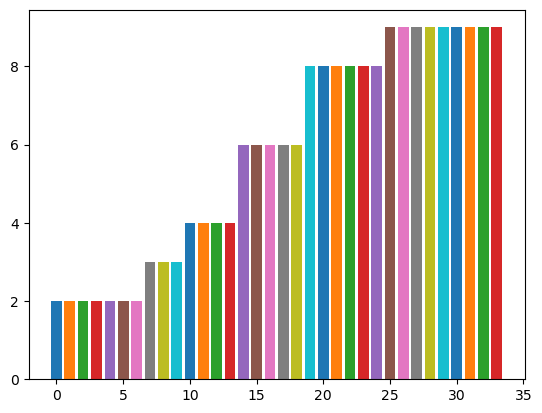

In [8]:
arr = [2,2,2,2,2,2,2,3,3,3,4,4,4,4,6,6,6,6,6,8,8,8,8,8,8,9,9,9,9,9,9,9,9,9]
for i in range(len(arr)):
    plt.bar(i,arr[i])
plt.show()

C:\Users\anime\AppData\Local\Temp\ipykernel_19556\3132159534.py:26: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


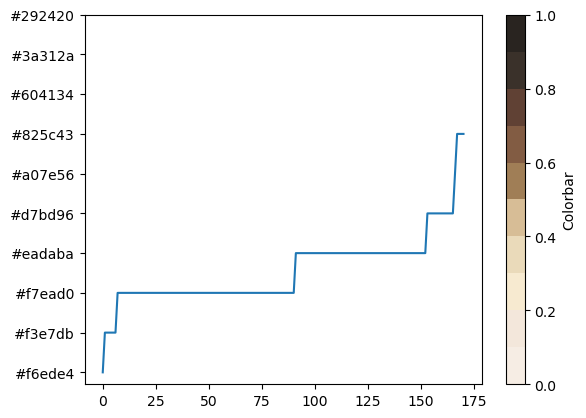

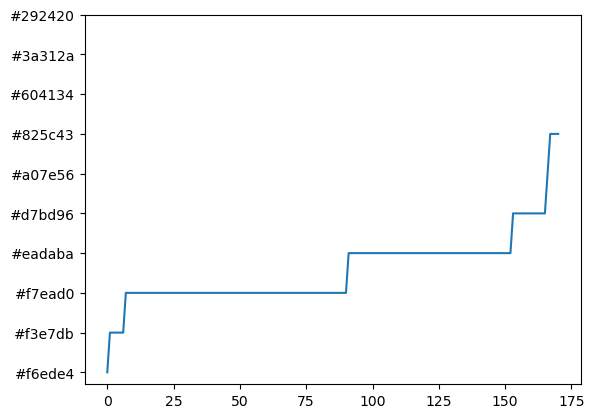

In [53]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import ScalarMappable

# Generate some data for plotting
# x = np.linspace(0, 10, 100)
# y = np.sin(x)
x = ['#f6ede4', '#f3e7db', '#f3e7db', '#f3e7db', '#f3e7db', '#f3e7db', '#f3e7db', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#d7bd96', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#a07e56', '#825c43', '#825c43', '#825c43', '#825c43', '#825c43', '#825c43', '#825c43', '#825c43', '#825c43', '#825c43', '#825c43', '#825c43', '#825c43', '#604134', '#3a312a', '#3a312a', '#3a312a', '#3a312a']
z = np.linspace(0, 1, len(x))

# Define your custom colormap
colors = ['darkblue', 'blue', 'lightblue', 'white', 'lightgreen', 'green', 'darkgreen']
std_skin_tones = ["#f6ede4","#f3e7db","#f7ead0","#eadaba","#d7bd96","#a07e56","#825c43","#604134","#3a312a","#292420"]
custom_cmap = plt.cm.colors.ListedColormap(std_skin_tones)

# Create a dummy ScalarMappable object for colorbar creation
sm = ScalarMappable(cmap=custom_cmap)
sm.set_array([])  # An empty array is used since we are setting the colors manually

# Create the plot using plt.plot and set the color for each segment
for i in range(len(x) - 1):
    plt.plot([0], c=custom_cmap(z[i]))
plt.plot(x)
plt.yticks(np.arange(0,10),std_skin_tones)
# Create a colorbar with the custom colormap
cbar = plt.colorbar(sm)
cbar.set_label('Colorbar')

# Show the plot
plt.show()
plt.plot(x)
plt.yticks(np.arange(0,10),std_skin_tones)
plt.show()

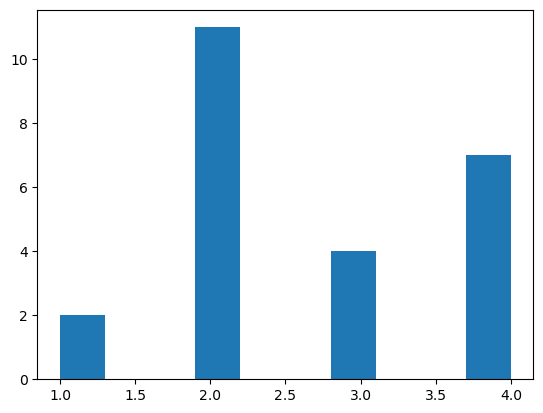

In [58]:
x = [1,1,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,4,4,4,4,4,4,4]
plt.hist(x)
plt.show()

In [46]:
a = [1,2,3,4,5]
def fun(a):
    a.append(9)
print(a)
fun(a)
print(a)

[1, 2, 3, 4, 5]
[1, 2, 3, 4, 5, 9]
